# Data Loading, Cleaning and Feature Selection
The following tasks are executed:
- Data is loaded from raw files
- Columnnames are fixed
- Columns get correct object type
- Class columns are put as the last columns
- Missing data is replaced by NaN
- Data characteristics are visualized
- Missing data is visualized
- Data is saved to a new, cleaned file as a df

## Set Parameters

In [242]:
dataset_name = "omxs30"
class_name = "LongTrend"
outcome_columns = ['1dTrend', '5dTrend', '20dTrend', class_name]

filenameprefix = dataset_name + "_" + class_name
filenamesuffix = ''
filenameXsuffix = filenamesuffix
filenameysuffix = filenamesuffix

image_save_directory = '02_Training_Data/images'
filedataresultdirectory = '02_Training_Data'
#filedataresultdirectory = '03_Test_Prepared_Data'
#image_save_directory = '03_Test_Prepared_Data/images'

data_file = filedataresultdirectory + "/" + filenameprefix + "_dataset.csv"
print("Source path: ", data_file)

#To save time in the generation of test data and to skip the feature analysis, set this option to false. For training 
#data, set it to true.
#do_feature_analysis = True
skip_feature_analysis = False
skip_feature_selection = False

missingValueModelPath = filedataresultdirectory + "/" + filenameprefix + "_missing_value_model" + filenameXsuffix + ".csv"
X_filename = filedataresultdirectory + "/" + filenameprefix + "_X" + filenameXsuffix + ".csv"
y_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + filenameysuffix + ".csv"
ylabel_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + "_labels" + filenameysuffix + ".csv"
X_filename_selected_feature_column = filedataresultdirectory + "/" + filenameprefix + "_X" + filenameXsuffix + "_selected_feature_columns.csv"
filename_timegraph = filedataresultdirectory + "/" + filenameprefix + "_timegraph" + filenameXsuffix + ".csv"

print("Missing value path: ", missingValueModelPath)
print("Save features to X: ", X_filename)
print("Save features to y: ", y_filename)
print("Define y labels to ", ylabel_filename)
print("Selected feature column file name: ", X_filename_selected_feature_column)
print("Time graph path: ", filename_timegraph)

print("Feature analysis to be skipped: ", skip_feature_analysis)
print("Feature selection to be skipped: ", skip_feature_selection)

Source path:  02_Training_Data/omxs30_LongTrend_dataset.csv
Missing value path:  02_Training_Data/omxs30_LongTrend_missing_value_model.csv
Save features to X:  02_Training_Data/omxs30_LongTrend_X.csv
Save features to y:  02_Training_Data/omxs30_LongTrend_y.csv
Define y labels to  02_Training_Data/omxs30_LongTrend_y_labels.csv
Selected feature column file name:  02_Training_Data/omxs30_LongTrend_X_selected_feature_columns.csv
Time graph path:  02_Training_Data/omxs30_LongTrend_timegraph.csv
Feature analysis to be skipped:  False
Feature selection to be skipped:  False


## Load Libraries

In [243]:
# Import libraries
#%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.ticker import FuncFormatter, MaxNLocator
import DatavisualizationFunctions as vis
import DataSupportFunctions as sup

#Global settings
np.set_printoptions(precision=3)

#Suppress print out in scientific notiation
np.set_printoptions(suppress=True)

#Load skip cell kernel extension
#Source: https://stackoverflow.com/questions/26494747/simple-way-to-choose-which-cells-to-run-in-ipython-notebook-during-run-all
#%%skip True  #skips cell
#%%skip False #won't skip
#should_skip = True
#%%skip $should_skip
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


## Load dataset

### Load Features and Outcomes

In [244]:
#Load dataset
df = pd.read_csv(data_file, sep=';').set_index('id') #Set ID to be the data id
display(df.head(1))

#=== Get classes into a dict ===#
class_labels = dict(zip(df[class_name].unique(), list(range(1,len(df[class_name].unique())+1, 1))))
#Load class labels instead
df_y_classes = pd.read_csv(ylabel_filename, delimiter=';', header=None)
class_labels = sup.inverse_dict(df_y_classes.set_index(df_y_classes.columns[0]).to_dict()[1])
print("Loaded  classes from file", class_labels)

#=== Define classes manually ===#
#class_labels = {
#    0 : 'class1',
#    1 : 'class2'
#}

print(class_labels)

#=== Define index name ===#
#Define name if there is no index name

#df.index.name = 'id'

#=== rename colums ===#
#df.rename(columns={'model.year':'year'}, inplace=True)

#Rename columns with " "
df.columns = [x.replace(" ", "_") for x in df.columns]
df.columns = [x.replace("/", "-") for x in df.columns]

print("df size : ", df.shape)
display(df.head(5))

MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.000887  0.005474  0.006129  0.007285  0.002936 -0.000072  0.001049   

     MA20Norm  MA22Norm  MA34Norm    ...      week_month__1  week_month__2  \
id                                   ...                                     
400  0.004271  0.005723 -0.000678    ...                  0              0   

     week_month__3  week_month__4  week_month__5  week_month__6  1dTrend  \
id                                                                         
400              1              0              0              0        0   

     5dTrend  20dTrend  LongTrend  
id                                 
400        0         1          1  

[1 rows x 120 columns]

Loaded  classes from file {0: 'neutral', 1: 'positive', 2: 'negative'}
{0: 'neutral', 1: 'positive', 2: 'negative'}
df size :  (7687, 120)


MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.000887  0.005474  0.006129  0.007285  0.002936 -0.000072  0.001049   
401 -0.000501  0.000770  0.004823  0.005799  0.003158  0.000472 -0.001806   
402  0.004116  0.004845  0.011318  0.011539  0.012066  0.009370  0.006001   
403  0.000466  0.004928  0.009813  0.011324  0.012705  0.010773  0.007302   
404 -0.004963 -0.004325 -0.002414  0.000777  0.002350  0.001898 -0.001364   

     MA20Norm  MA22Norm  MA34Norm    ...      week_month__1  week_month__2  \
id                                   ...                                     
400  0.004271  0.005723 -0.000678    ...                  0              0   
401  0.001748  0.004173 -0.001803    ...                  0              0   
402  0.007862  0.010850  0.006276    ...                  0              0   
403  0.006661  0.009984  0.006794    ...                  0              0   
404 -0.003247 -0.001553 -0.003386    ...                  0              0   

     week_month__3  week_month__4  week_month__5  week_month__6  1dTrend  \
id                                                                         
400              1              0              0              0        0   
401              1              0              0              0        0   
402              1              0              0              0        0   
403              1              0              0              0        1   
404              0              1              0              0        0   

     5dTrend  20dTrend  LongTrend  
id                                 
400        0         1          1  
401        0         1          1  
402        0         1          1  
403        0         1          1  
404        0         1          1  

[5 rows x 120 columns]

### Load Time Series

In [245]:
#Load original data for visualization
import matplotlib.dates as mdates
import datetime

df_timegraph = pd.read_csv(filename_timegraph, delimiter=';').set_index('id')
df_timegraph['Time'] = pd.to_datetime(df_timegraph['Time'])
df_timegraph['Time'].apply(mdates.date2num)
print("Loaded feature names for time graph={}".format(df_timegraph.columns))
print("X. Shape={}".format(df_timegraph.shape))
display(df_timegraph.head())

Loaded feature names for time graph=Index(['Time', 'High', 'Low', 'Close'], dtype='object')
X. Shape=(7687, 4)


Time    High     Low   Close
id                                    
400 1988-05-09  129.71  129.71  129.71
401 1988-05-10  129.84  129.84  129.84
402 1988-05-11  128.78  128.78  128.78
403 1988-05-13  128.66  128.66  128.66
404 1988-05-16  129.95  129.95  129.95

## Data Cleanup of Features and Outcomes before Features are Modified

In [246]:
#Strip all string values to find the missing data
from pandas.api.types import is_string_dtype

for col in df.columns:
    if is_string_dtype(df[col]):
        print("Strip column {}".format(col))
        df[col]=df[col].str.strip()

In [247]:
#Replace values for missing data

#=== Replace all missing values with np.nan
for col in df.columns[0:-1]:
    df[col] = df[col].replace('?', np.nan)
    #df[col] = df[col].replace('unknown', np.nan)
    
print("Missing data in the data frame")
print(sum(df.isna().sum()))

Missing data in the data frame
0


In [248]:
#Get column types
print("Column types:")
print(df.dtypes)
print("\n")

Column types:
MA2Norm           float64
MA5Norm           float64
MA8Norm           float64
MA10Norm          float64
MA13Norm          float64
MA15Norm          float64
MA18Norm          float64
MA20Norm          float64
MA22Norm          float64
MA34Norm          float64
MA40Norm          float64
MA50Norm          float64
MA75Norm          float64
MA100Norm         float64
MA125Norm         float64
MA150Norm         float64
MA175Norm         float64
MA200Norm         float64
MA225Norm         float64
MA250Norm         float64
MA275Norm         float64
MA300Norm         float64
MA325Norm         float64
MA350Norm         float64
MA375Norm         float64
MA400Norm         float64
MA2NormDiff       float64
MA5NormDiff       float64
MA8NormDiff       float64
MA10NormDiff      float64
                   ...   
day_of_month        int64
day_week__0         int64
day_week__1         int64
day_week__2         int64
day_week__3         int64
day_week__4         int64
day_week__5         int6

## Split Features from Outcomes

In [249]:
#=== Extract Outcome columns ===#
outcomes_raw = df[outcome_columns]
print("Outcomes raw data")
display(outcomes_raw.head())
print(outcomes_raw.shape)

#=== Drop alternative y values ===#
features_raw=df.drop(outcomes_raw.columns, axis=1)

#=== Reorder columns to have the class as the last column if it is not done yet ===# -- OBSOLETE
#df = df[[c for c in df if c not in [class_name]] + [class_name]]

#=== Use only a subset header ===#
#header = ['Elevation', 'Aspect', 'Slope', 
#          'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
#          'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
#          'Horizontal_Distance_To_Fire_Points'] + \
#         ['Wilderness_Area_{:d}'.format(i) for i in range(4)] + \
#         ['Soil_Type_{:d}'.format(i) for i in range(40)] + \
#          ['Cover_type']
# header=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
#         'marital-status', 'occupation', 'relationship', 'race', 'sex', 
#         'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Income50K']
#features.columns = header

print("Features")
display(features_raw.head())
print(features_raw.shape)


Outcomes raw data


1dTrend  5dTrend  20dTrend  LongTrend
id                                        
400        0        0         1          1
401        0        0         1          1
402        0        0         1          1
403        1        0         1          1
404        0        0         1          1

(7687, 4)
Features


MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.000887  0.005474  0.006129  0.007285  0.002936 -0.000072  0.001049   
401 -0.000501  0.000770  0.004823  0.005799  0.003158  0.000472 -0.001806   
402  0.004116  0.004845  0.011318  0.011539  0.012066  0.009370  0.006001   
403  0.000466  0.004928  0.009813  0.011324  0.012705  0.010773  0.007302   
404 -0.004963 -0.004325 -0.002414  0.000777  0.002350  0.001898 -0.001364   

     MA20Norm  MA22Norm  MA34Norm      ...        month_year__9  \
id                                     ...                        
400  0.004271  0.005723 -0.000678      ...                    0   
401  0.001748  0.004173 -0.001803      ...                    0   
402  0.007862  0.010850  0.006276      ...                    0   
403  0.006661  0.009984  0.006794      ...                    0   
404 -0.003247 -0.001553 -0.003386      ...                    0   

     month_year__10  month_year__11  month_year__12  week_month__1  \
id                                                                   
400               0               0               0              0   
401               0               0               0              0   
402               0               0               0              0   
403               0               0               0              0   
404               0               0               0              0   

     week_month__2  week_month__3  week_month__4  week_month__5  week_month__6  
id                                                                              
400              0              1              0              0              0  
401              0              1              0              0              0  
402              0              1              0              0              0  
403              0              1              0              0              0  
404              0              0              1              0              0  

[5 rows x 116 columns]

(7687, 116)


In [250]:
print("feature columns: {}".format(features_raw.columns))

feature columns: Index(['MA2Norm', 'MA5Norm', 'MA8Norm', 'MA10Norm', 'MA13Norm', 'MA15Norm',
       'MA18Norm', 'MA20Norm', 'MA22Norm', 'MA34Norm',
       ...
       'month_year__9', 'month_year__10', 'month_year__11', 'month_year__12',
       'week_month__1', 'week_month__2', 'week_month__3', 'week_month__4',
       'week_month__5', 'week_month__6'],
      dtype='object', length=116)


## Get Feature and Outcome Characteristics

In [251]:
#Show possible classes
print(class_labels)

{0: 'neutral', 1: 'positive', 2: 'negative'}


In [252]:
# Get number of samples
numSamples=features_raw.shape[0]
print("Number of samples={}".format(numSamples))

# Get number of features
numFeatures=features_raw.shape[1]
print("Number of features={}".format(numFeatures))

#Get the number of classes for the supervised learning
numClasses = outcomes_raw[class_name].value_counts().shape[0]
print("Number of classes={}".format(numClasses))

Number of samples=7687
Number of features=116
Number of classes=2


## Analyse and Transform time series

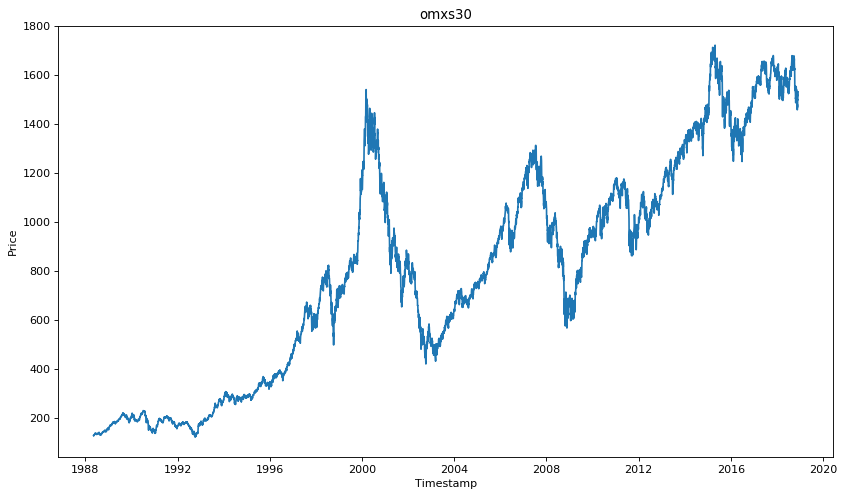

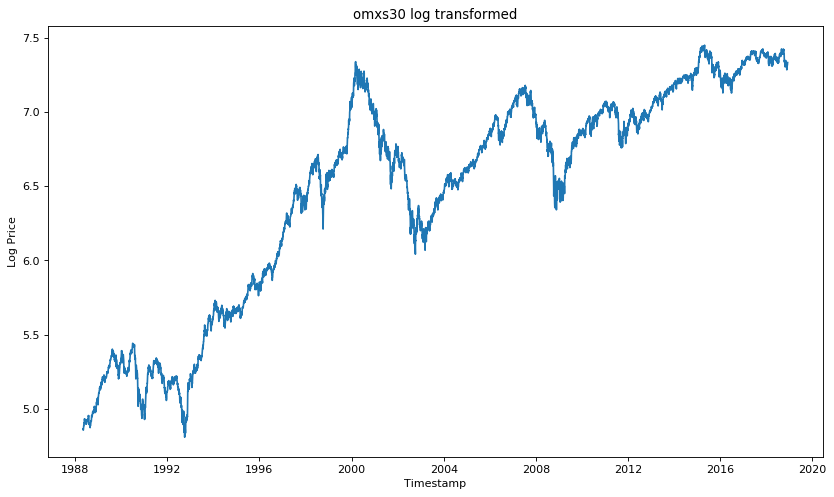

In [253]:
m.rc_file_defaults() #Reset sns

datatitle = dataset_name

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_timegraph['Time'],df_timegraph['Close']) #To get scatter plot, add 'o' as the last parameter
plt.title(datatitle)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.show()

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_timegraph['Time'],np.log(df_timegraph['Close']))
plt.title(datatitle + ' log transformed')
plt.xlabel("Timestamp")
plt.ylabel("Log Price")
plt.show()

## Analyse the Features Individually

In [254]:
# Print graphs for all features

def print_characteristics(df, save_graphs=False):
    for i, d in enumerate(df.dtypes):
        if is_string_dtype(d):
            print("Column {} is a categorical string".format(df.columns[i]))
            source = df[df.columns[i]].value_counts()/numSamples
            fig = vis.paintBarChartForCategorical(source.index, source)
        else:
            print("Column {} is a numerical value".format(df.columns[i]))
            fig = vis.paintHistogram(df, df.columns[i])

        plt.figure(fig.number)
        if save_graphs == True:
            plt.savefig(image_save_directory + '/{}-{}'.format(i, df.columns[i]), dpi=300)
        plt.show()

Column MA2Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  134
n=7687, q25=-0.00, q75=0.00, min=-0.05, max=0.05, interval length=0.00. Number of intervals=134
Feature characteristics for MA2Norm:
Min value =  -0.05218524078195865
Max value =  0.04599550597865965
Mean =  -0.0
Median = -0.0003159235668705834
Standard deviation = 0.007
Skew = 0.0669
kurtosis = 4.3275


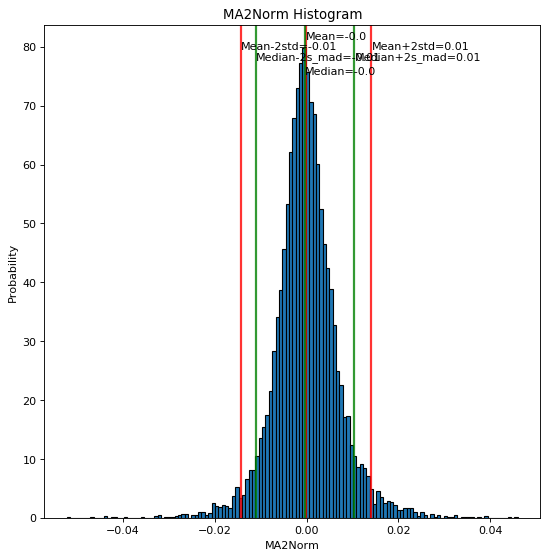

Column MA5Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  116
n=7687, q25=-0.01, q75=0.01, min=-0.10, max=0.10, interval length=0.00. Number of intervals=116
Feature characteristics for MA5Norm:
Min value =  -0.09645756457564714
Max value =  0.09596046346939492
Mean =  -0.0
Median = -0.0016486021957969172
Standard deviation = 0.0154
Skew = 0.4687
kurtosis = 3.2531


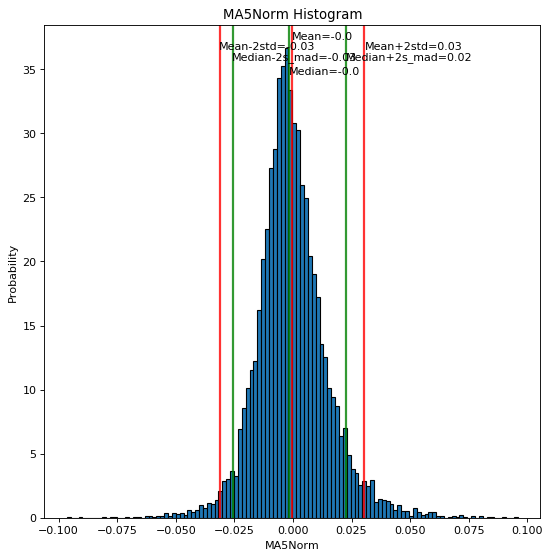

Column MA8Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  117
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.14, interval length=0.00. Number of intervals=117
Feature characteristics for MA8Norm:
Min value =  -0.11993908993192527
Max value =  0.14134281999421555
Mean =  -0.0
Median = -0.002638639792758151
Standard deviation = 0.0204
Skew = 0.5976
kurtosis = 3.2099


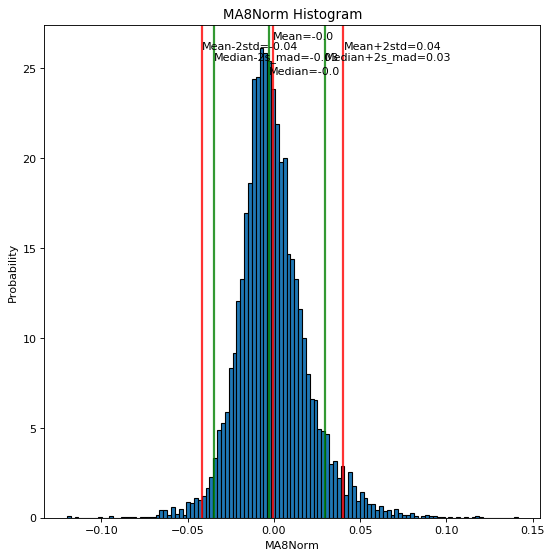

Column MA10Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  112
n=7687, q25=-0.01, q75=0.01, min=-0.13, max=0.16, interval length=0.00. Number of intervals=112
Feature characteristics for MA10Norm:
Min value =  -0.12773796727576628
Max value =  0.1607258659989083
Mean =  -0.0
Median = -0.0032478737828183194
Standard deviation = 0.023
Skew = 0.6774
kurtosis = 3.2092


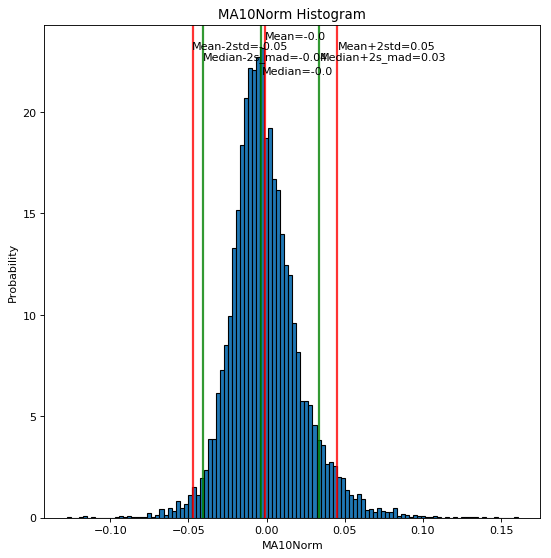

Column MA13Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  112
n=7687, q25=-0.02, q75=0.01, min=-0.14, max=0.20, interval length=0.00. Number of intervals=112
Feature characteristics for MA13Norm:
Min value =  -0.13559150750121884
Max value =  0.19846173602313533
Mean =  -0.0
Median = -0.004279036298088093
Standard deviation = 0.0265
Skew = 0.7679
kurtosis = 3.2674


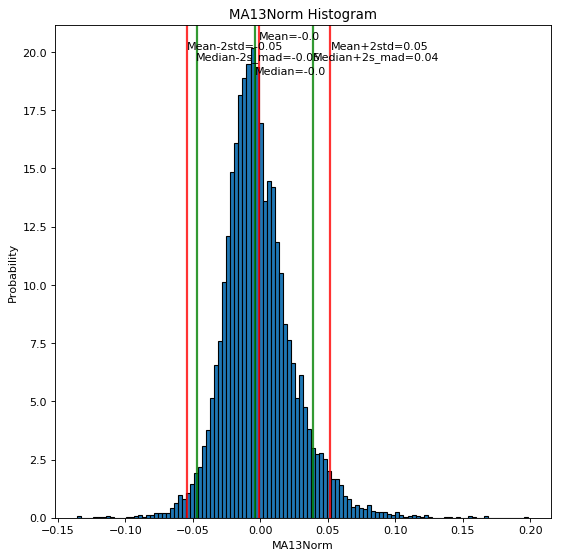

Column MA15Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  110
n=7687, q25=-0.02, q75=0.01, min=-0.14, max=0.22, interval length=0.00. Number of intervals=110
Feature characteristics for MA15Norm:
Min value =  -0.1412781257248916
Max value =  0.2160443887979324
Mean =  -0.0
Median = -0.004813790860304212
Standard deviation = 0.0286
Skew = 0.7971
kurtosis = 3.138


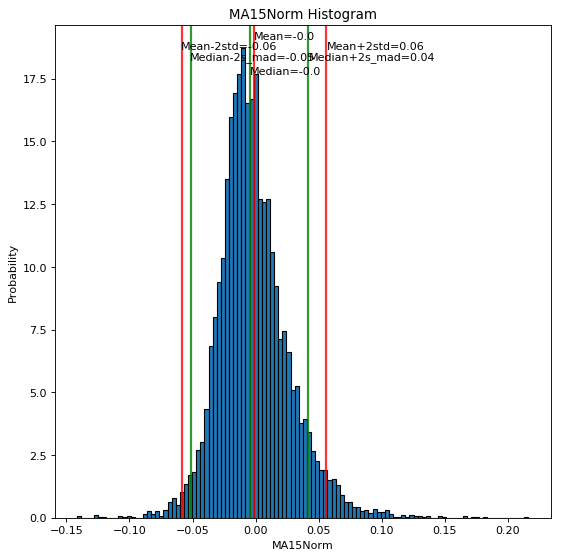

Column MA18Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  104
n=7687, q25=-0.02, q75=0.01, min=-0.15, max=0.23, interval length=0.00. Number of intervals=104
Feature characteristics for MA18Norm:
Min value =  -0.14944006288822045
Max value =  0.2285208014525141
Mean =  -0.0
Median = -0.006003612569494543
Standard deviation = 0.0316
Skew = 0.8296
kurtosis = 2.8857


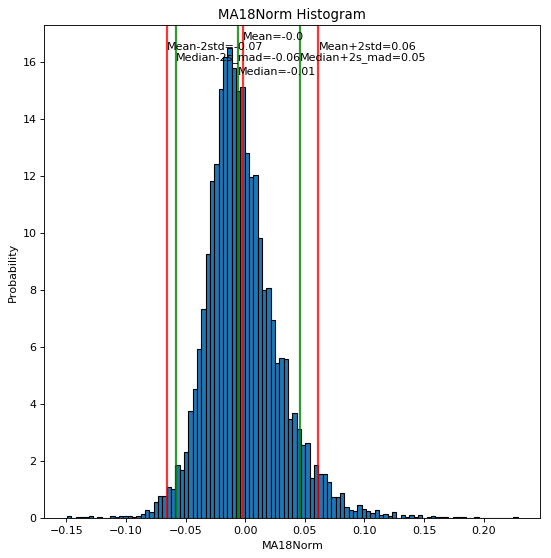

Column MA20Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  101
n=7687, q25=-0.02, q75=0.01, min=-0.16, max=0.24, interval length=0.00. Number of intervals=101
Feature characteristics for MA20Norm:
Min value =  -0.15528879610299212
Max value =  0.2366127323509575
Mean =  -0.0
Median = -0.0064812613172874406
Standard deviation = 0.0335
Skew = 0.8512
kurtosis = 2.828


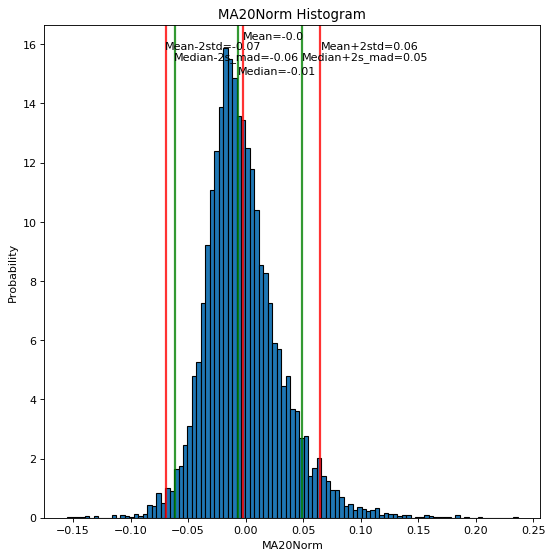

Column MA22Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  100
n=7687, q25=-0.02, q75=0.02, min=-0.16, max=0.25, interval length=0.00. Number of intervals=100
Feature characteristics for MA22Norm:
Min value =  -0.15842664642247056
Max value =  0.24643940123570499
Mean =  -0.0
Median = -0.007134128809659875
Standard deviation = 0.0354
Skew = 0.8702
kurtosis = 2.7844


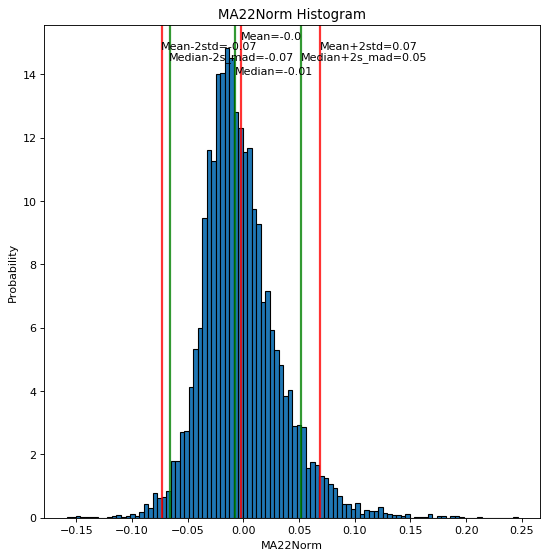

Column MA34Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  95
n=7687, q25=-0.03, q75=0.02, min=-0.19, max=0.29, interval length=0.01. Number of intervals=95
Feature characteristics for MA34Norm:
Min value =  -0.18716484506119865
Max value =  0.2943636185091406
Mean =  -0.0
Median = -0.010483305312057977
Standard deviation = 0.0454
Skew = 0.9116
kurtosis = 2.7179


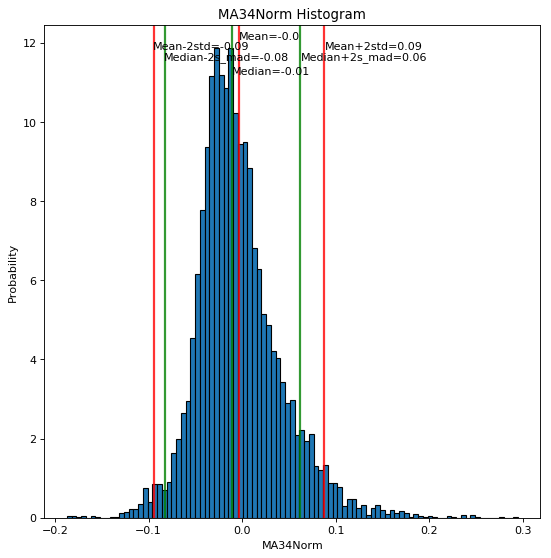

Column MA40Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  93
n=7687, q25=-0.03, q75=0.02, min=-0.20, max=0.31, interval length=0.01. Number of intervals=93
Feature characteristics for MA40Norm:
Min value =  -0.2004517476989117
Max value =  0.3076092998210879
Mean =  -0.0
Median = -0.011700748314441102
Standard deviation = 0.05
Skew = 0.9246
kurtosis = 2.7276


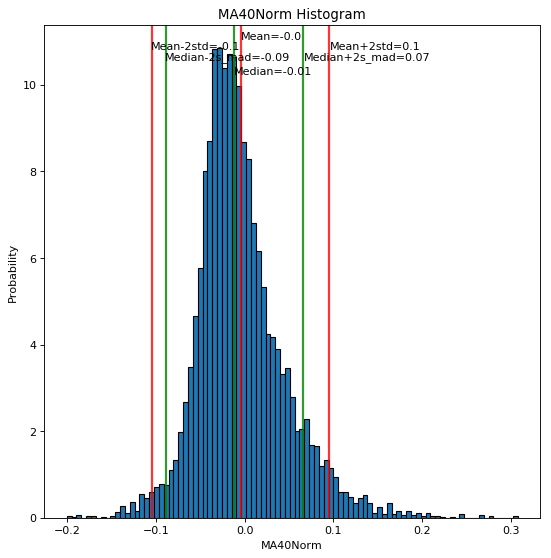

Column MA50Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  90
n=7687, q25=-0.04, q75=0.02, min=-0.21, max=0.34, interval length=0.01. Number of intervals=90
Feature characteristics for MA50Norm:
Min value =  -0.2107030323564291
Max value =  0.3441326362230984
Mean =  -0.01
Median = -0.01485895813561096
Standard deviation = 0.057
Skew = 0.9705
kurtosis = 2.7091


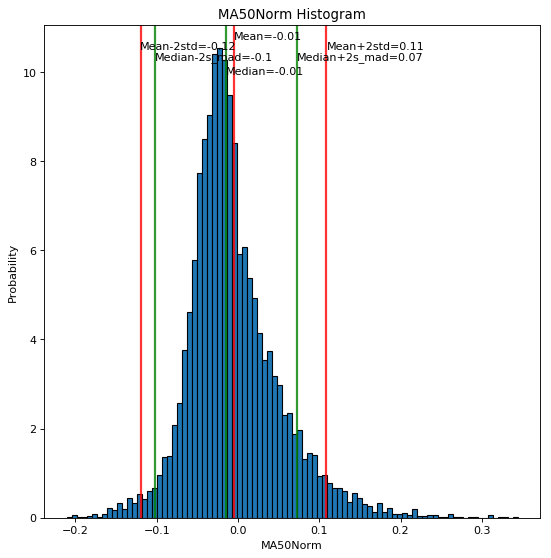

Column MA75Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  82
n=7687, q25=-0.05, q75=0.02, min=-0.22, max=0.41, interval length=0.01. Number of intervals=82
Feature characteristics for MA75Norm:
Min value =  -0.22466133278917533
Max value =  0.4071201668538447
Mean =  -0.01
Median = -0.02120223005169961
Standard deviation = 0.0724
Skew = 1.071
kurtosis = 2.4994


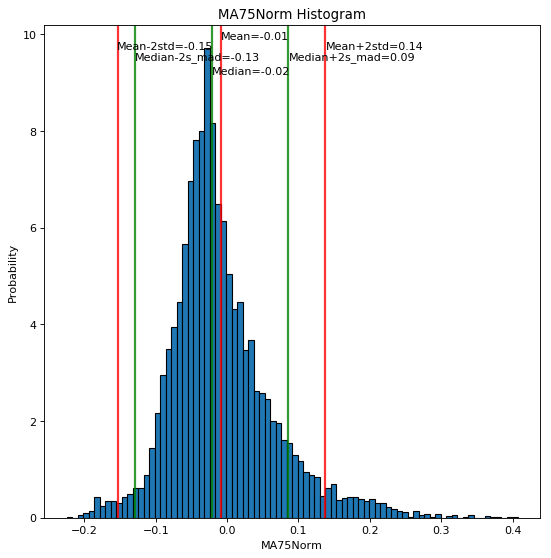

Column MA100Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  76
n=7687, q25=-0.06, q75=0.03, min=-0.26, max=0.44, interval length=0.01. Number of intervals=76
Feature characteristics for MA100Norm:
Min value =  -0.2555756787492979
Max value =  0.4421622463602546
Mean =  -0.01
Median = -0.027345241518113676
Standard deviation = 0.0859
Skew = 1.1255
kurtosis = 2.3348


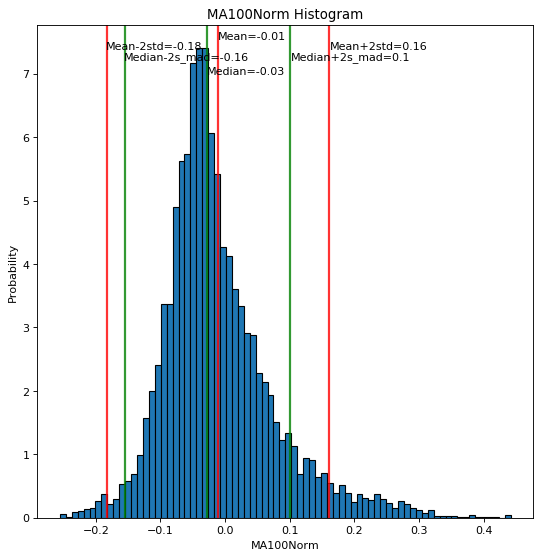

Column MA125Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.08, q75=0.03, min=-0.29, max=0.50, interval length=0.01. Number of intervals=74
Feature characteristics for MA125Norm:
Min value =  -0.2939653599299363
Max value =  0.4972511854926981
Mean =  -0.01
Median = -0.0318073838024816
Standard deviation = 0.0979
Skew = 1.1568
kurtosis = 2.2019


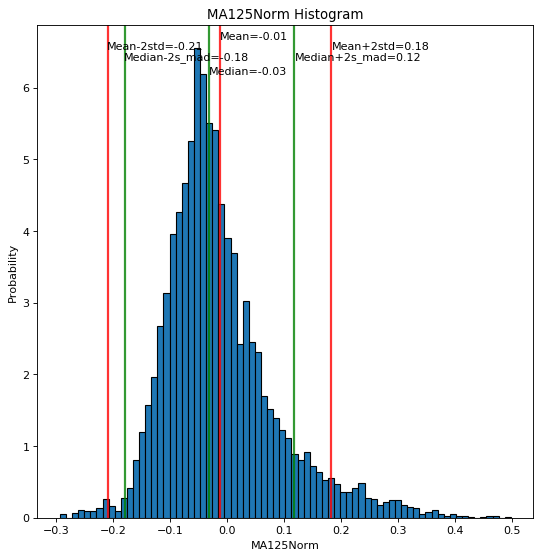

Column MA150Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  72
n=7687, q25=-0.09, q75=0.03, min=-0.32, max=0.53, interval length=0.01. Number of intervals=72
Feature characteristics for MA150Norm:
Min value =  -0.3205693854496657
Max value =  0.5304258509782107
Mean =  -0.02
Median = -0.036954525635435546
Standard deviation = 0.1084
Skew = 1.1743
kurtosis = 2.1279


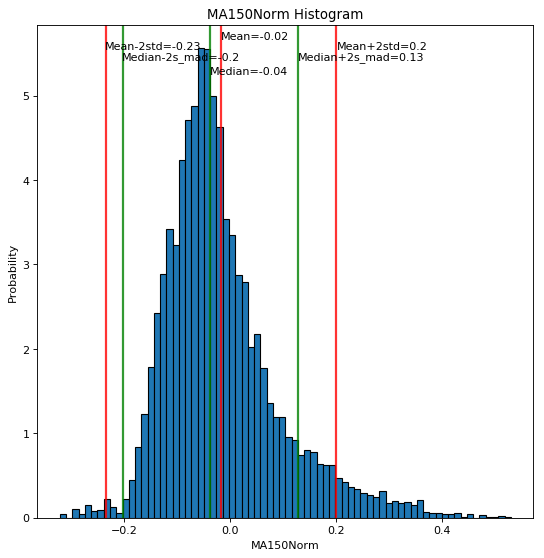

Column MA175Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  70
n=7687, q25=-0.09, q75=0.03, min=-0.34, max=0.55, interval length=0.01. Number of intervals=70
Feature characteristics for MA175Norm:
Min value =  -0.3409960311523413
Max value =  0.5457910604793557
Mean =  -0.02
Median = -0.04269838825582823
Standard deviation = 0.1177
Skew = 1.1677
kurtosis = 1.9687


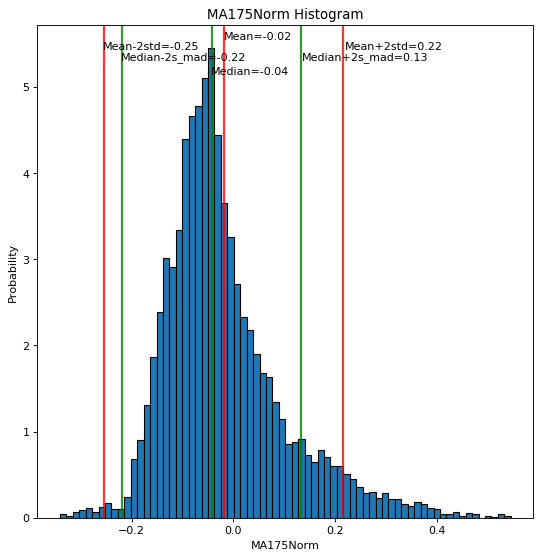

Column MA200Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  70
n=7687, q25=-0.10, q75=0.03, min=-0.36, max=0.58, interval length=0.01. Number of intervals=70
Feature characteristics for MA200Norm:
Min value =  -0.3575649014850423
Max value =  0.5783557699144379
Mean =  -0.02
Median = -0.04822581102943296
Standard deviation = 0.1263
Skew = 1.1546
kurtosis = 1.8145


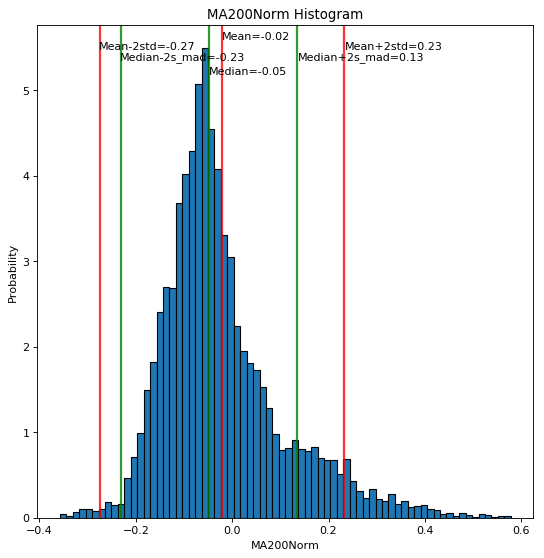

Column MA225Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  71
n=7687, q25=-0.11, q75=0.03, min=-0.37, max=0.62, interval length=0.01. Number of intervals=71
Feature characteristics for MA225Norm:
Min value =  -0.3726084112642615
Max value =  0.624454504038318
Mean =  -0.02
Median = -0.05251233313295218
Standard deviation = 0.1347
Skew = 1.1477
kurtosis = 1.704


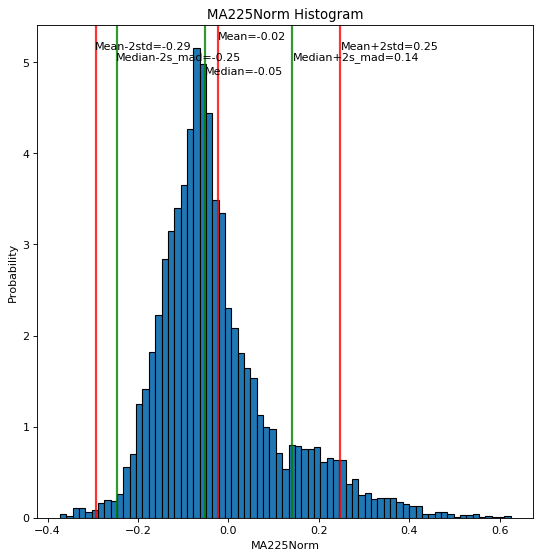

Column MA250Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  71
n=7687, q25=-0.12, q75=0.03, min=-0.39, max=0.64, interval length=0.01. Number of intervals=71
Feature characteristics for MA250Norm:
Min value =  -0.3872006400707715
Max value =  0.6433312272867596
Mean =  -0.03
Median = -0.057841383826416966
Standard deviation = 0.1431
Skew = 1.1508
kurtosis = 1.6178


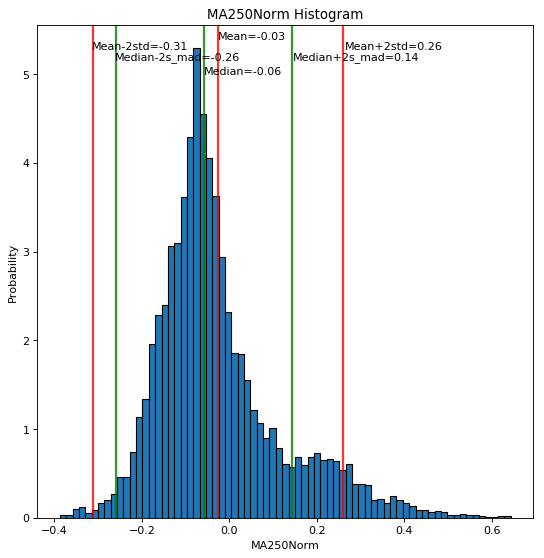

Column MA275Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  71
n=7687, q25=-0.12, q75=0.03, min=-0.40, max=0.67, interval length=0.02. Number of intervals=71
Feature characteristics for MA275Norm:
Min value =  -0.4000031932577313
Max value =  0.6692200144959343
Mean =  -0.03
Median = -0.06379649698472409
Standard deviation = 0.1513
Skew = 1.1725
kurtosis = 1.6145


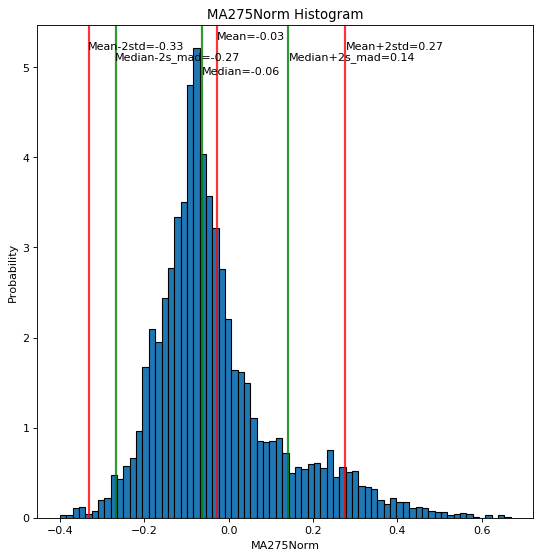

Column MA300Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  73
n=7687, q25=-0.13, q75=0.03, min=-0.41, max=0.70, interval length=0.02. Number of intervals=73
Feature characteristics for MA300Norm:
Min value =  -0.411281572596644
Max value =  0.7026428815433695
Mean =  -0.03
Median = -0.06908093896713549
Standard deviation = 0.1595
Skew = 1.2071
kurtosis = 1.6799


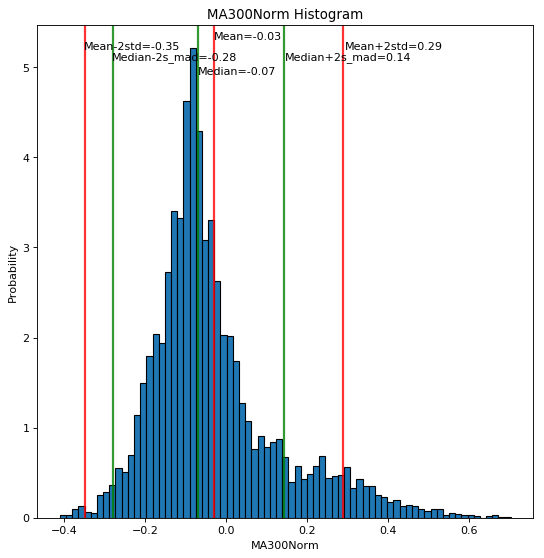

Column MA325Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.13, q75=0.02, min=-0.42, max=0.74, interval length=0.02. Number of intervals=74
Feature characteristics for MA325Norm:
Min value =  -0.42232568053803576
Max value =  0.7356988761702966
Mean =  -0.03
Median = -0.0749230916373497
Standard deviation = 0.1672
Skew = 1.2409
kurtosis = 1.7448


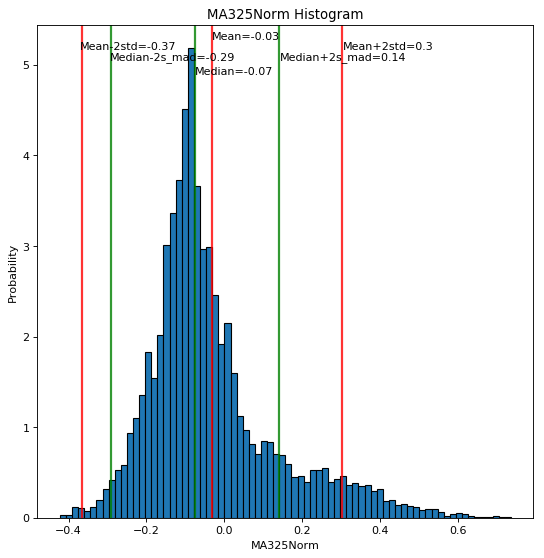

Column MA350Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.14, q75=0.02, min=-0.43, max=0.77, interval length=0.02. Number of intervals=74
Feature characteristics for MA350Norm:
Min value =  -0.4344271840510137
Max value =  0.7693974893113349
Mean =  -0.03
Median = -0.07972117443553194
Standard deviation = 0.1745
Skew = 1.2744
kurtosis = 1.8214


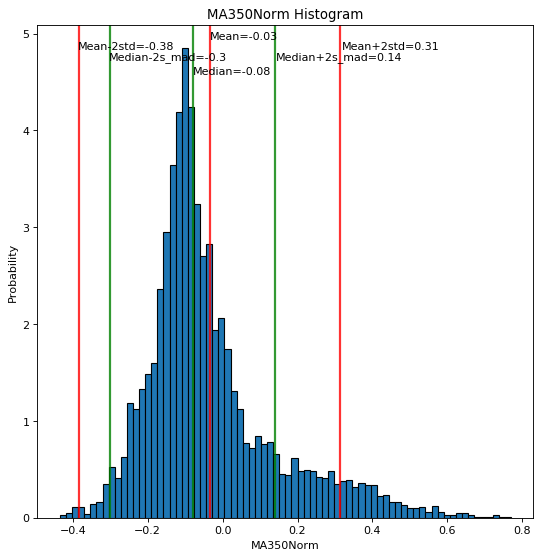

Column MA375Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  74
n=7687, q25=-0.14, q75=0.02, min=-0.45, max=0.80, interval length=0.02. Number of intervals=74
Feature characteristics for MA375Norm:
Min value =  -0.44683954648644203
Max value =  0.7974837794491461
Mean =  -0.04
Median = -0.08448856902101022
Standard deviation = 0.1812
Skew = 1.3061
kurtosis = 1.8968


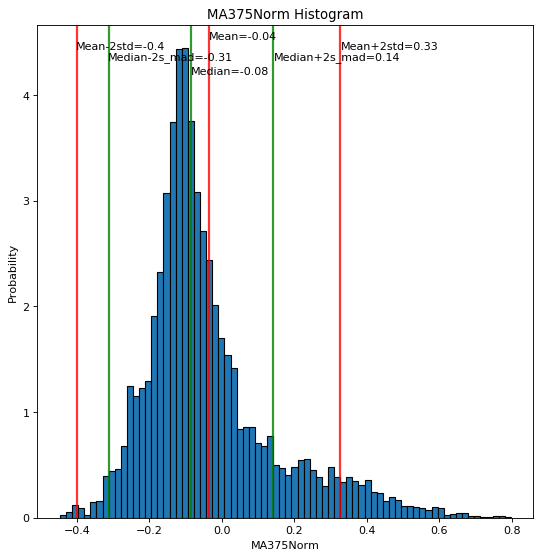

Column MA400Norm is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  72
n=7687, q25=-0.15, q75=0.02, min=-0.45, max=0.82, interval length=0.02. Number of intervals=72
Feature characteristics for MA400Norm:
Min value =  -0.4532537256151911
Max value =  0.8210164839936754
Mean =  -0.04
Median = -0.0889776526087516
Standard deviation = 0.1875
Skew = 1.3414
kurtosis = 1.9977


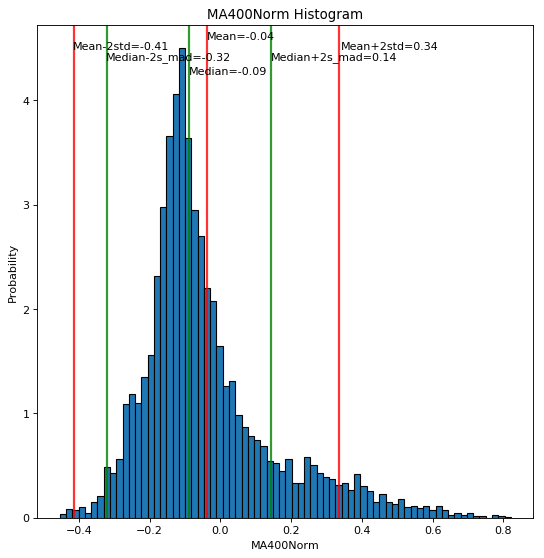

Column MA2NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  120
n=7687, q25=-0.01, q75=0.01, min=-0.07, max=0.05, interval length=0.00. Number of intervals=120
Feature characteristics for MA2NormDiff:
Min value =  -0.07049484763103052
Max value =  0.05493745307104738
Mean =  -0.0
Median = 0.00012415913045910702
Standard deviation = 0.0099
Skew = -0.327
kurtosis = 4.5574


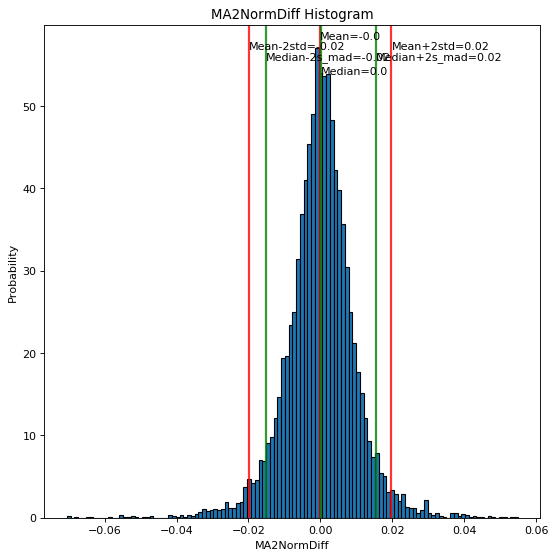

Column MA5NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  137
n=7687, q25=-0.01, q75=0.01, min=-0.10, max=0.08, interval length=0.00. Number of intervals=137
Feature characteristics for MA5NormDiff:
Min value =  -0.10133325706239146
Max value =  0.08217953343895837
Mean =  -0.0
Median = 0.0004696736474149501
Standard deviation = 0.0128
Skew = -0.5102
kurtosis = 5.1965


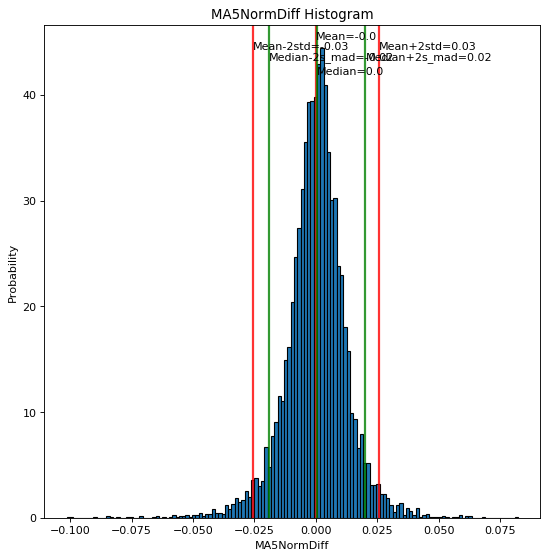

Column MA8NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  144
n=7687, q25=-0.01, q75=0.01, min=-0.11, max=0.09, interval length=0.00. Number of intervals=144
Feature characteristics for MA8NormDiff:
Min value =  -0.11071688100197777
Max value =  0.08640256135221752
Mean =  -0.0
Median = 0.0004219323554831389
Standard deviation = 0.0134
Skew = -0.5261
kurtosis = 5.7263


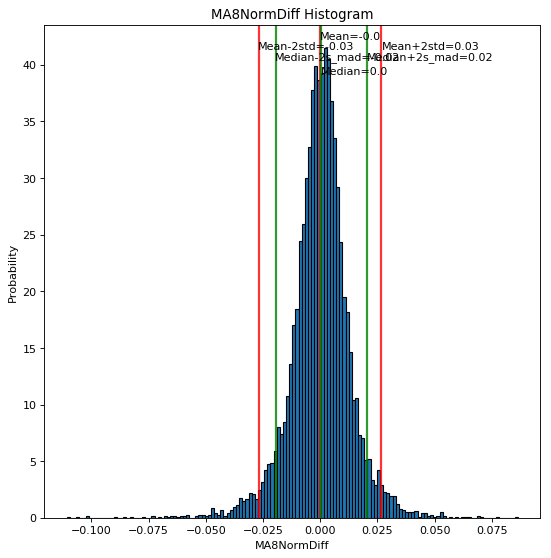

Column MA10NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  146
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.08, interval length=0.00. Number of intervals=146
Feature characteristics for MA10NormDiff:
Min value =  -0.11702390639012362
Max value =  0.08346634033662326
Mean =  -0.0
Median = 0.0003837792344338672
Standard deviation = 0.0135
Skew = -0.5504
kurtosis = 5.8075


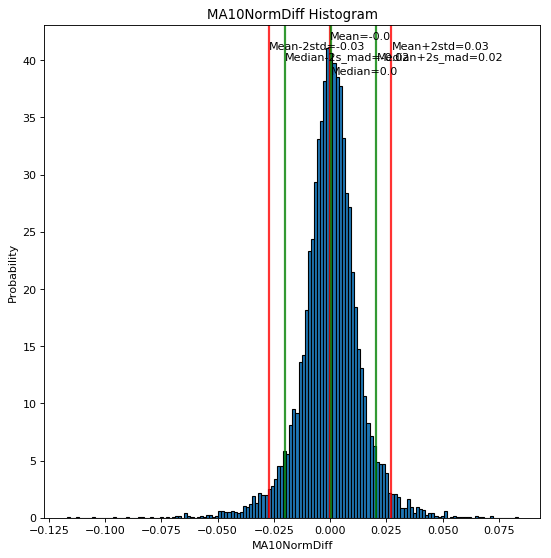

Column MA13NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  143
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.08, interval length=0.00. Number of intervals=143
Feature characteristics for MA13NormDiff:
Min value =  -0.11740393920398146
Max value =  0.08216833814810272
Mean =  -0.0
Median = 0.0003574789494456103
Standard deviation = 0.0137
Skew = -0.5533
kurtosis = 5.9563


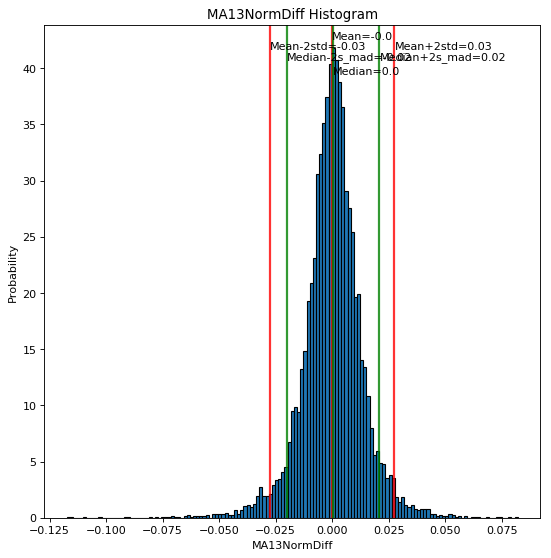

Column MA15NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  143
n=7687, q25=-0.01, q75=0.01, min=-0.11, max=0.08, interval length=0.00. Number of intervals=143
Feature characteristics for MA15NormDiff:
Min value =  -0.11382571776316225
Max value =  0.08383048780741517
Mean =  -0.0
Median = 0.00029319245875172525
Standard deviation = 0.0138
Skew = -0.5139
kurtosis = 5.8087


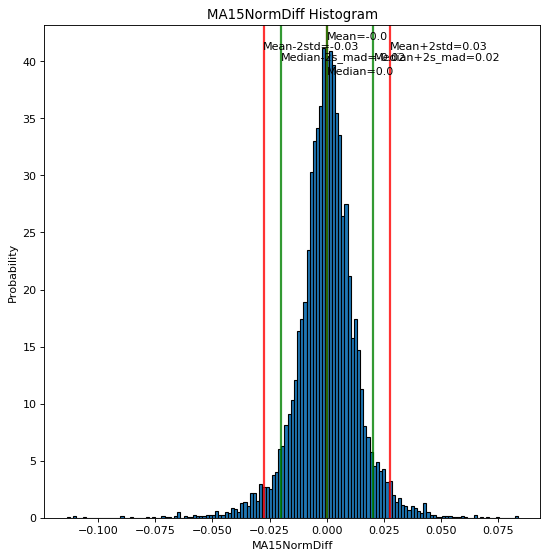

Column MA18NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  146
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.08, interval length=0.00. Number of intervals=146
Feature characteristics for MA18NormDiff:
Min value =  -0.11876883777671315
Max value =  0.08498926210245701
Mean =  -0.0
Median = 0.00022330543076986079
Standard deviation = 0.0139
Skew = -0.4864
kurtosis = 5.7577


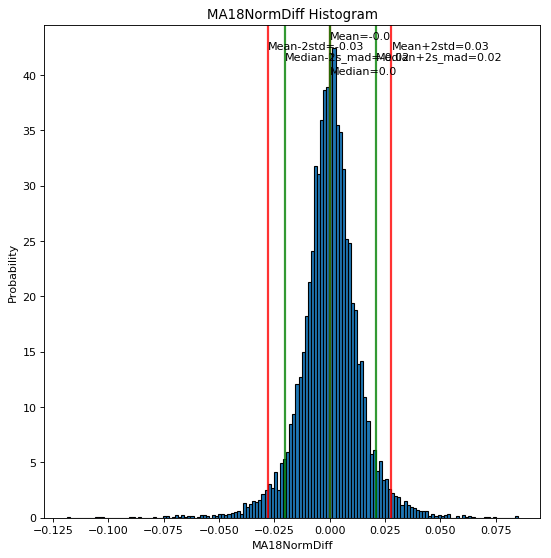

Column MA20NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  146
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.09, interval length=0.00. Number of intervals=146
Feature characteristics for MA20NormDiff:
Min value =  -0.12092608889639092
Max value =  0.08537410220582717
Mean =  -0.0
Median = 0.00023006620756338414
Standard deviation = 0.014
Skew = -0.485
kurtosis = 5.8056


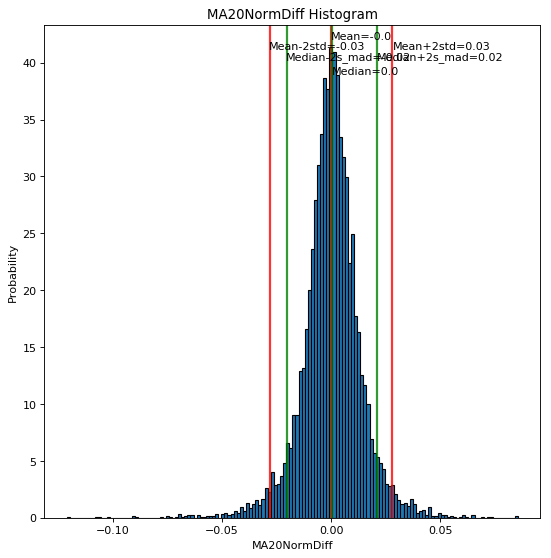

Column MA22NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  148
n=7687, q25=-0.01, q75=0.01, min=-0.12, max=0.09, interval length=0.00. Number of intervals=148
Feature characteristics for MA22NormDiff:
Min value =  -0.1214854426068573
Max value =  0.08757232581837876
Mean =  -0.0
Median = 0.00019261920356574043
Standard deviation = 0.0141
Skew = -0.474
kurtosis = 5.84


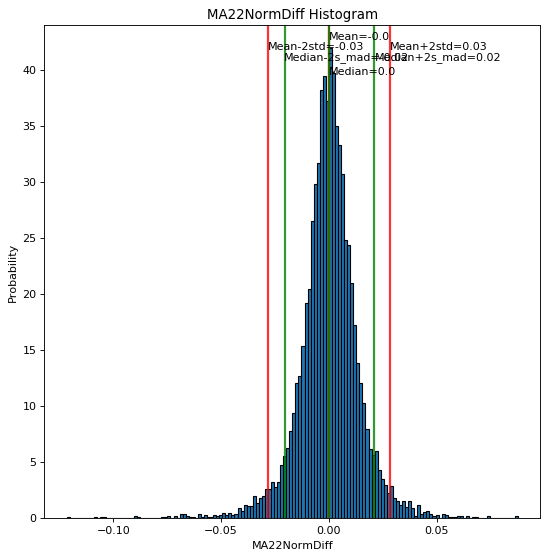

Column MA34NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  158
n=7687, q25=-0.01, q75=0.01, min=-0.13, max=0.09, interval length=0.00. Number of intervals=158
Feature characteristics for MA34NormDiff:
Min value =  -0.12985525905642262
Max value =  0.09363733035696303
Mean =  -0.0
Median = 9.649028879546613e-05
Standard deviation = 0.0143
Skew = -0.4415
kurtosis = 6.2622


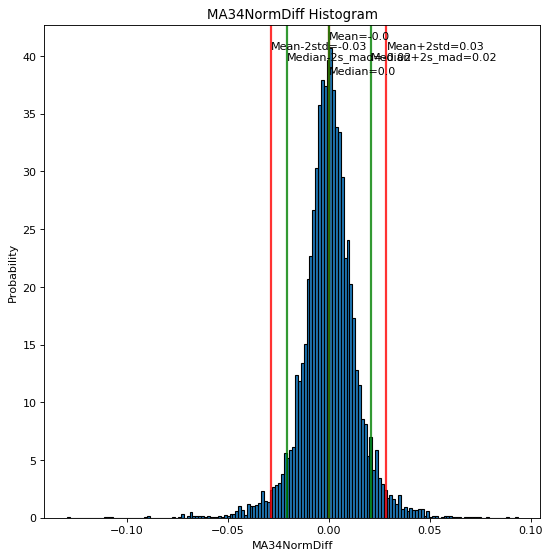

Column MA40NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  158
n=7687, q25=-0.01, q75=0.01, min=-0.13, max=0.09, interval length=0.00. Number of intervals=158
Feature characteristics for MA40NormDiff:
Min value =  -0.1319956565273233
Max value =  0.09355447059206047
Mean =  -0.0
Median = 9.259892160900716e-05
Standard deviation = 0.0143
Skew = -0.4415
kurtosis = 6.4671


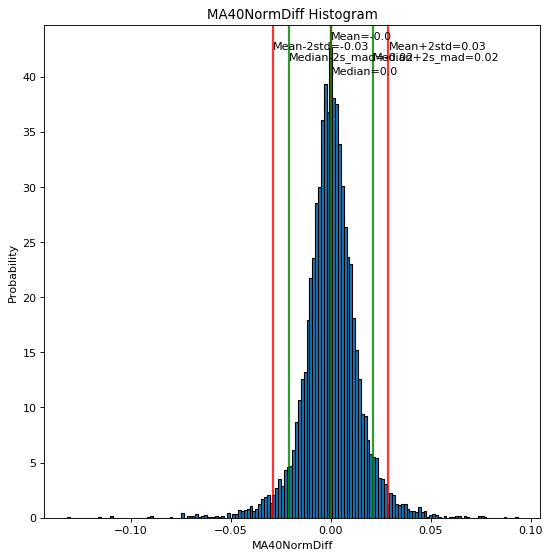

Column MA50NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  162
n=7687, q25=-0.01, q75=0.01, min=-0.14, max=0.09, interval length=0.00. Number of intervals=162
Feature characteristics for MA50NormDiff:
Min value =  -0.13691148265412198
Max value =  0.09337296535370262
Mean =  0.0
Median = 1.0018197139152753e-05
Standard deviation = 0.0145
Skew = -0.4479
kurtosis = 6.8417


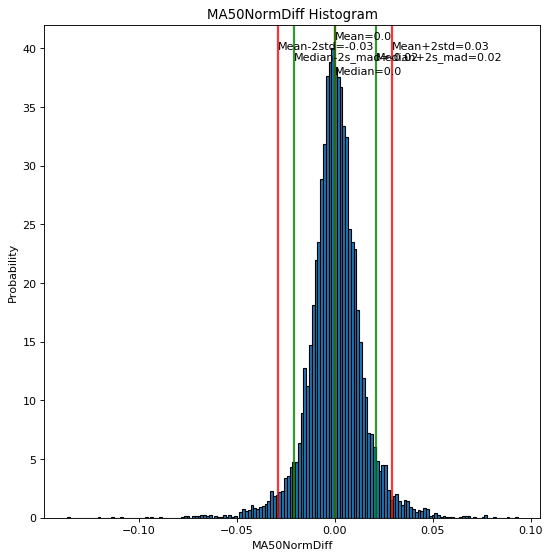

Column MA75NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  170
n=7687, q25=-0.01, q75=0.01, min=-0.14, max=0.10, interval length=0.00. Number of intervals=170
Feature characteristics for MA75NormDiff:
Min value =  -0.14494035166626434
Max value =  0.0970073928773045
Mean =  0.0
Median = -5.173796770736872e-05
Standard deviation = 0.0147
Skew = -0.4559
kurtosis = 7.6522


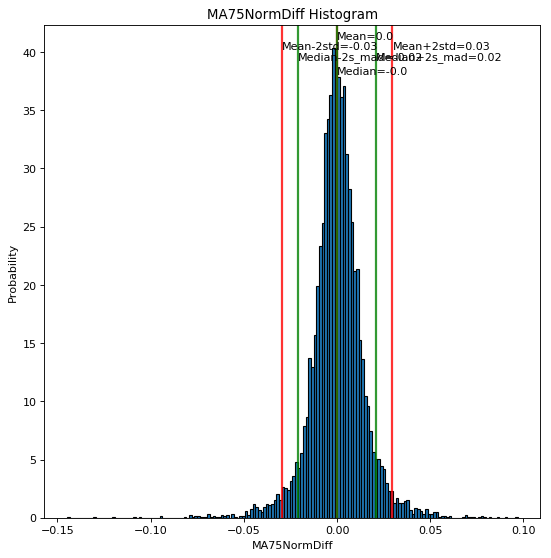

Column MA100NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  175
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.10, interval length=0.00. Number of intervals=175
Feature characteristics for MA100NormDiff:
Min value =  -0.14712553970424555
Max value =  0.10143541012438342
Mean =  0.0
Median = -9.642432887553088e-05
Standard deviation = 0.0149
Skew = -0.457
kurtosis = 8.1619


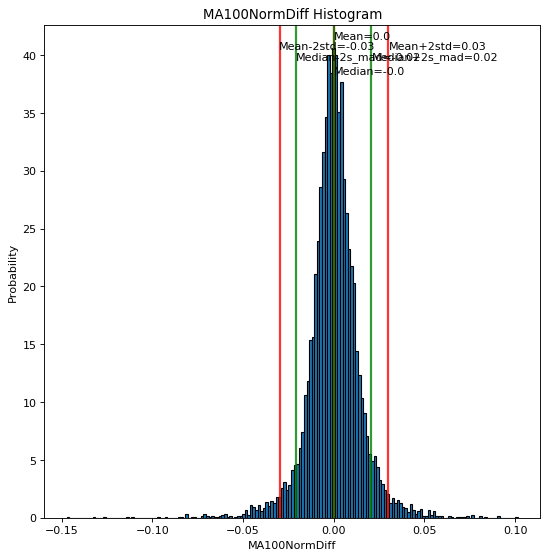

Column MA125NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  177
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.10, interval length=0.00. Number of intervals=177
Feature characteristics for MA125NormDiff:
Min value =  -0.1479957782738029
Max value =  0.1019217665986858
Mean =  0.0
Median = -0.00011664957359841348
Standard deviation = 0.0151
Skew = -0.4597
kurtosis = 8.6091


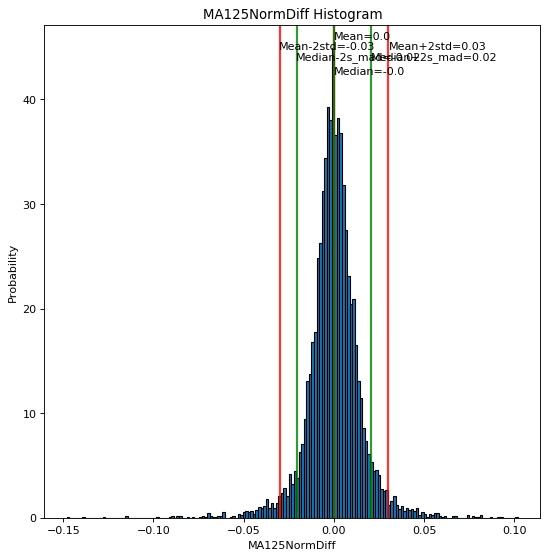

Column MA150NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  178
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.10, interval length=0.00. Number of intervals=178
Feature characteristics for MA150NormDiff:
Min value =  -0.14683325117558332
Max value =  0.10354533668884094
Mean =  0.0
Median = -0.00014813610438552116
Standard deviation = 0.0152
Skew = -0.456
kurtosis = 8.979


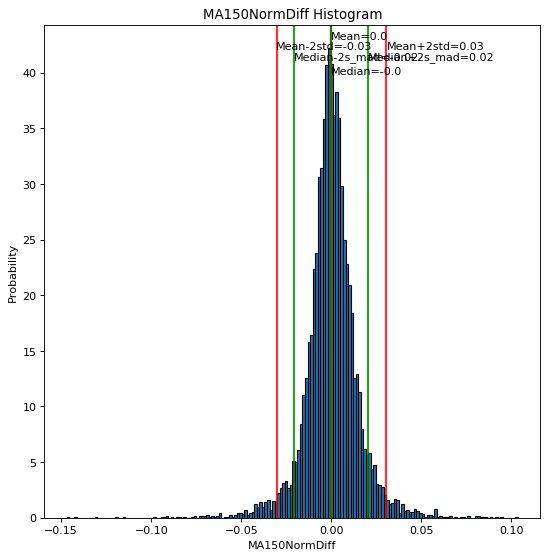

Column MA175NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  180
n=7687, q25=-0.01, q75=0.01, min=-0.14, max=0.11, interval length=0.00. Number of intervals=180
Feature characteristics for MA175NormDiff:
Min value =  -0.14433727245614153
Max value =  0.10751223591827803
Mean =  0.0
Median = -0.00015479581116031868
Standard deviation = 0.0153
Skew = -0.4415
kurtosis = 9.185


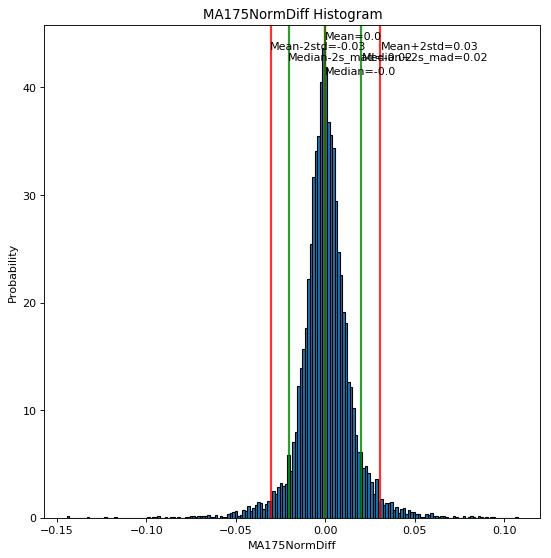

Column MA200NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  186
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.11, interval length=0.00. Number of intervals=186
Feature characteristics for MA200NormDiff:
Min value =  -0.14588250084162865
Max value =  0.11060976849753146
Mean =  0.0
Median = -0.00017869857755326013
Standard deviation = 0.0154
Skew = -0.434
kurtosis = 9.3155


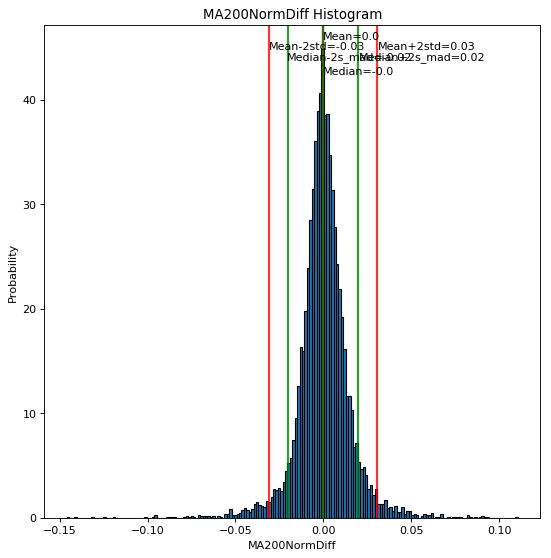

Column MA225NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  190
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.11, interval length=0.00. Number of intervals=190
Feature characteristics for MA225NormDiff:
Min value =  -0.1481145364253938
Max value =  0.11366179601395825
Mean =  0.0
Median = -0.00016731860896600917
Standard deviation = 0.0154
Skew = -0.4362
kurtosis = 9.5051


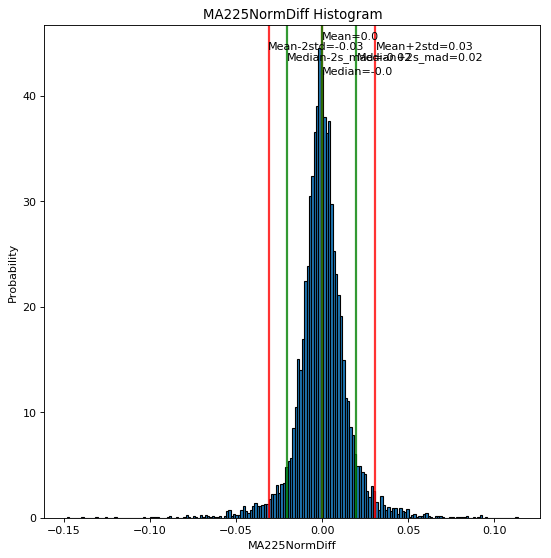

Column MA250NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  195
n=7687, q25=-0.01, q75=0.01, min=-0.15, max=0.12, interval length=0.00. Number of intervals=195
Feature characteristics for MA250NormDiff:
Min value =  -0.15159571387001994
Max value =  0.11620591886590065
Mean =  0.0
Median = -0.0001815846398883769
Standard deviation = 0.0155
Skew = -0.4457
kurtosis = 9.8538


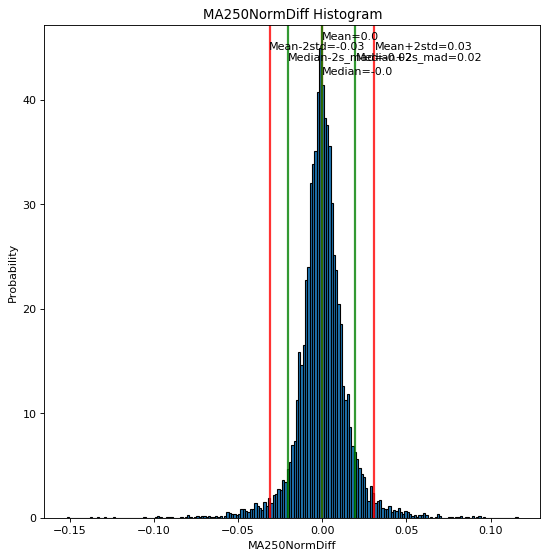

Column MA275NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  202
n=7687, q25=-0.01, q75=0.01, min=-0.16, max=0.12, interval length=0.00. Number of intervals=202
Feature characteristics for MA275NormDiff:
Min value =  -0.15532175397531822
Max value =  0.12021147393462868
Mean =  0.0
Median = -0.00019297255110173328
Standard deviation = 0.0156
Skew = -0.4482
kurtosis = 10.2068


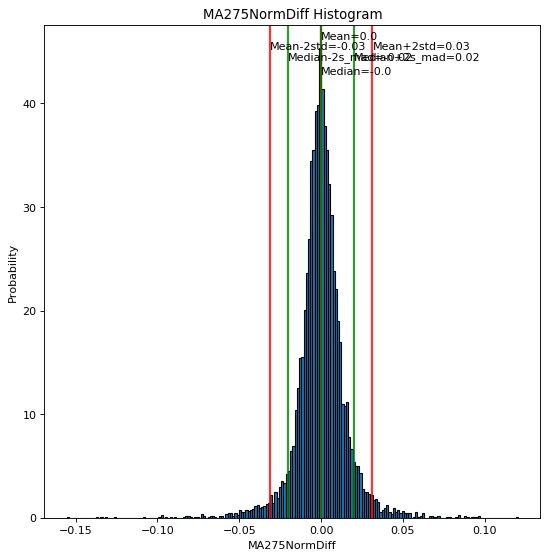

Column MA300NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  208
n=7687, q25=-0.01, q75=0.01, min=-0.16, max=0.12, interval length=0.00. Number of intervals=208
Feature characteristics for MA300NormDiff:
Min value =  -0.15929746477209872
Max value =  0.1236838971084992
Mean =  0.0
Median = -0.00016450017570572226
Standard deviation = 0.0157
Skew = -0.4577
kurtosis = 10.6596


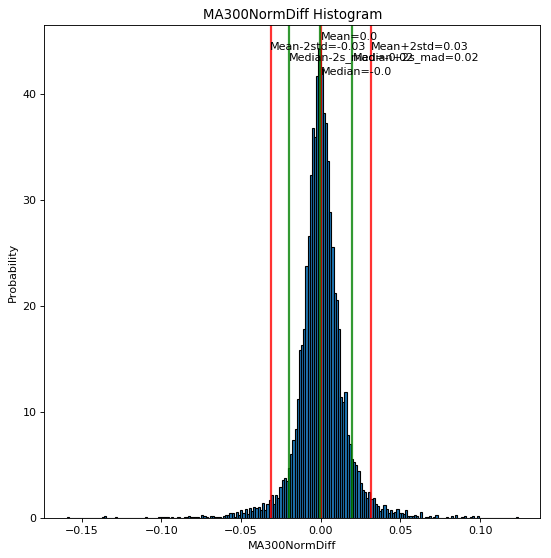

Column MA325NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  214
n=7687, q25=-0.01, q75=0.01, min=-0.16, max=0.13, interval length=0.00. Number of intervals=214
Feature characteristics for MA325NormDiff:
Min value =  -0.16237949961261675
Max value =  0.12697536709257906
Mean =  0.0
Median = -0.0002007805524457916
Standard deviation = 0.0158
Skew = -0.4592
kurtosis = 11.0318


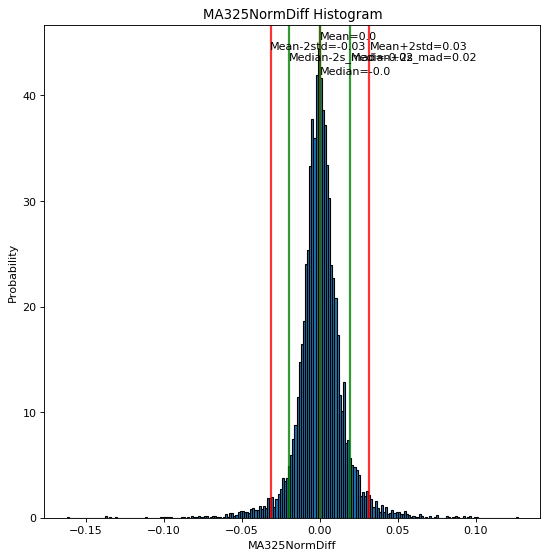

Column MA350NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  220
n=7687, q25=-0.01, q75=0.01, min=-0.17, max=0.13, interval length=0.00. Number of intervals=220
Feature characteristics for MA350NormDiff:
Min value =  -0.16603585612469166
Max value =  0.12986409616907096
Mean =  0.0
Median = -0.00017175111633085938
Standard deviation = 0.0158
Skew = -0.4682
kurtosis = 11.4444


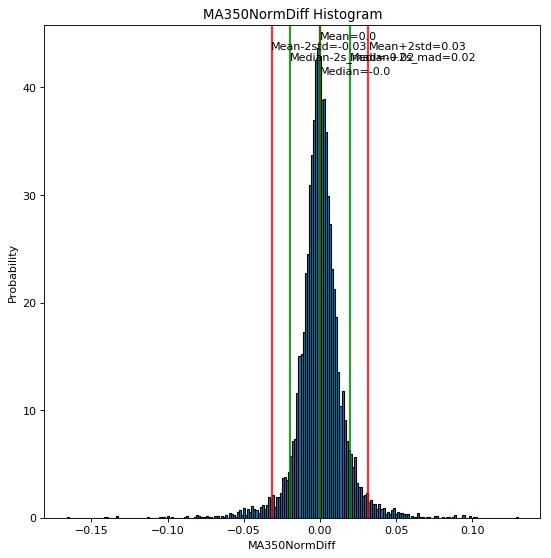

Column MA375NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  225
n=7687, q25=-0.01, q75=0.01, min=-0.17, max=0.13, interval length=0.00. Number of intervals=225
Feature characteristics for MA375NormDiff:
Min value =  -0.1688352345731915
Max value =  0.13201261336758952
Mean =  0.0
Median = -0.00017670100817609308
Standard deviation = 0.0159
Skew = -0.473
kurtosis = 11.8154


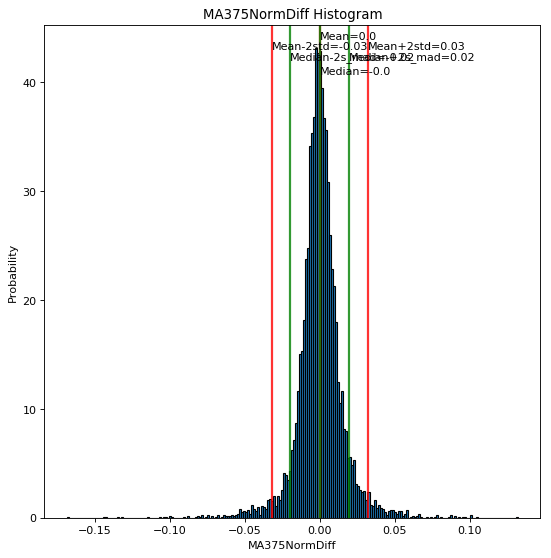

Column MA400NormDiff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  230
n=7687, q25=-0.01, q75=0.01, min=-0.17, max=0.13, interval length=0.00. Number of intervals=230
Feature characteristics for MA400NormDiff:
Min value =  -0.17126792621653386
Max value =  0.13494158740196793
Mean =  0.0
Median = -0.000209220980054034
Standard deviation = 0.0159
Skew = -0.4751
kurtosis = 12.1676


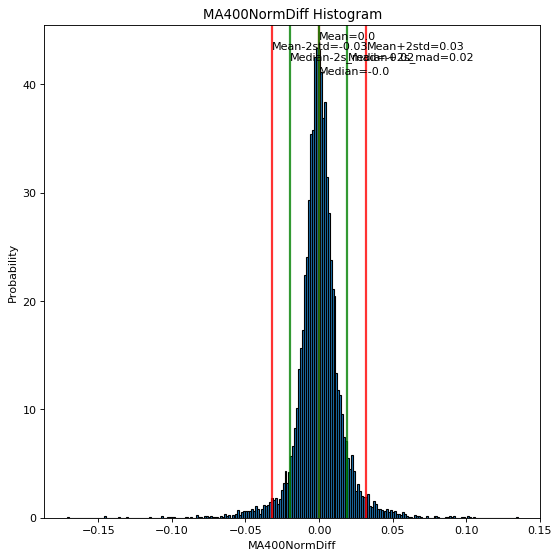

Column RSI2 is a numerical value
Number of unique features 7671 
Number of bins with Freedman und Diaconis:  17
n=7687, q25=24.21, q75=83.53, min=0.01, max=99.99, interval length=6.01. Number of intervals=17
Feature characteristics for RSI2:
Min value =  0.008837094541702496
Max value =  99.99192461593552
Mean =  53.85
Median = 57.15671368467896
Standard deviation = 31.6885
Skew = -0.1667
kurtosis = -1.3464


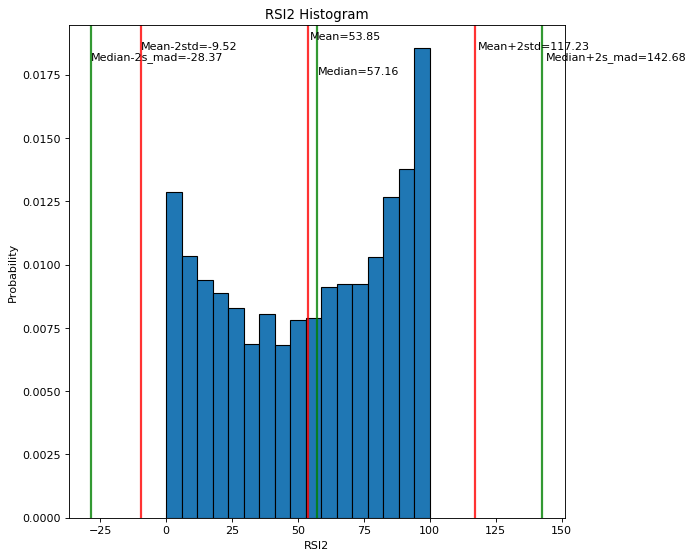

Column RSI3 is a numerical value
Number of unique features 7675 
Number of bins with Freedman und Diaconis:  23
n=7687, q25=33.12, q75=75.69, min=0.21, max=99.74, interval length=4.31. Number of intervals=23
Feature characteristics for RSI3:
Min value =  0.20883075116599864
Max value =  99.74195982371431
Mean =  53.92
Median = 55.77805711109225
Standard deviation = 26.0052
Skew = -0.1706
kurtosis = -1.0533


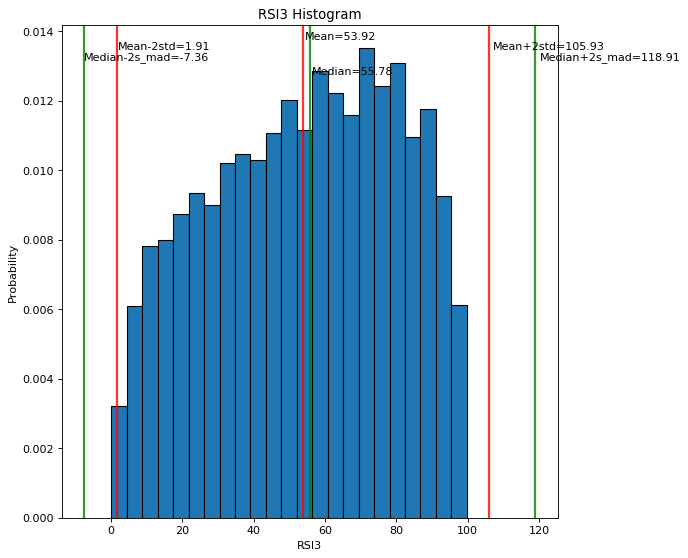

Column RSI5 is a numerical value
Number of unique features 7677 
Number of bins with Freedman und Diaconis:  31
n=7687, q25=38.78, q75=69.79, min=1.34, max=97.67, interval length=3.14. Number of intervals=31
Feature characteristics for RSI5:
Min value =  1.3420248809317057
Max value =  97.66800793564396
Mean =  53.82
Median = 54.896361194729536
Standard deviation = 20.2981
Skew = -0.1605
kurtosis = -0.7463


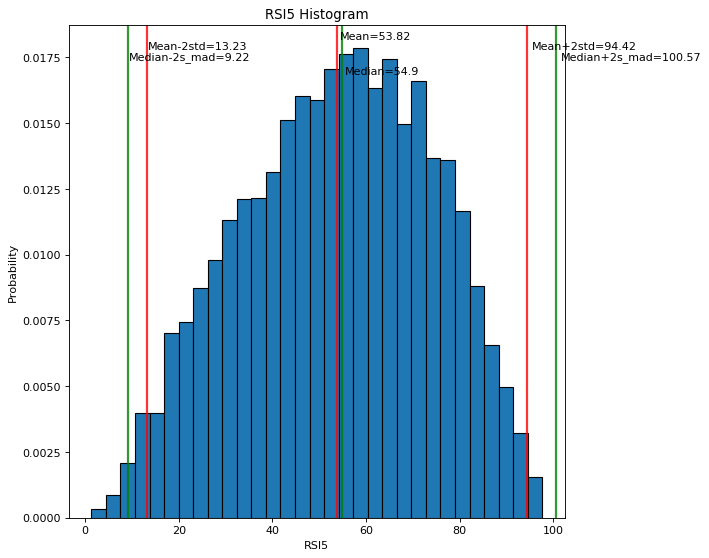

Column RSI9 is a numerical value
Number of unique features 7676 
Number of bins with Freedman und Diaconis:  38
n=7687, q25=42.49, q75=65.04, min=5.93, max=92.58, interval length=2.29. Number of intervals=38
Feature characteristics for RSI9:
Min value =  5.931982220079013
Max value =  92.5805461991548
Mean =  53.57
Median = 54.20834323471838
Standard deviation = 15.2956
Skew = -0.1362
kurtosis = -0.4972


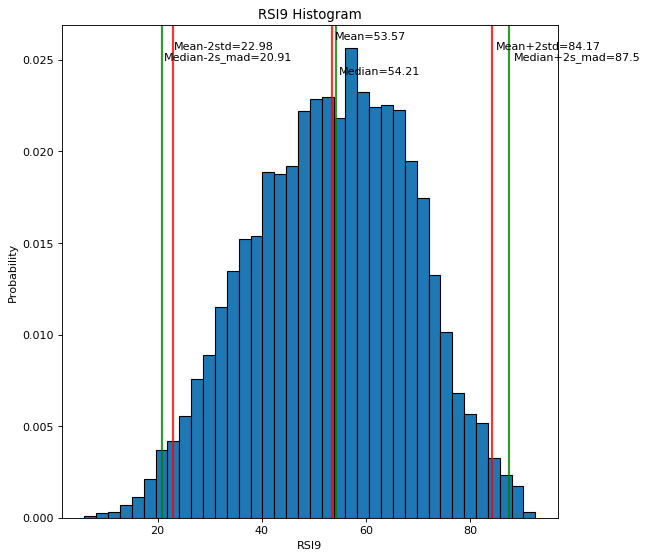

Column RSI10 is a numerical value
Number of unique features 7676 
Number of bins with Freedman und Diaconis:  39
n=7687, q25=43.13, q75=64.38, min=7.15, max=91.46, interval length=2.15. Number of intervals=39
Feature characteristics for RSI10:
Min value =  7.150170364097347
Max value =  91.45959915511428
Mean =  53.52
Median = 54.17553213833477
Standard deviation = 14.5497
Skew = -0.1306
kurtosis = -0.4614


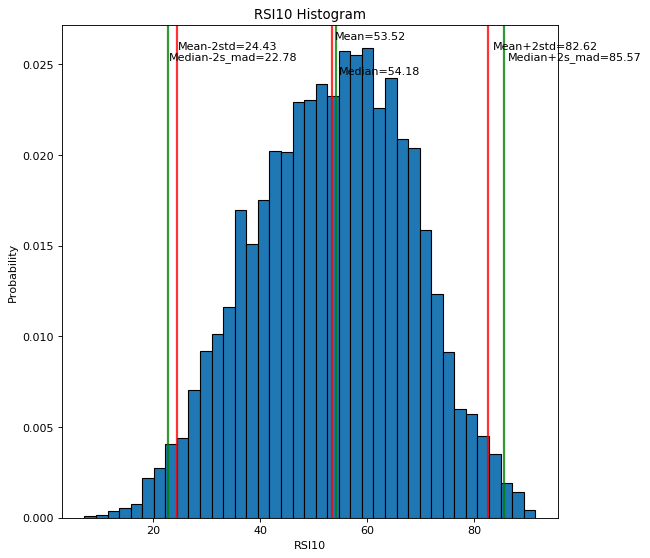

Column RSI14 is a numerical value
Number of unique features 7675 
Number of bins with Freedman und Diaconis:  42
n=7687, q25=44.43, q75=62.37, min=11.39, max=87.74, interval length=1.82. Number of intervals=42
Feature characteristics for RSI14:
Min value =  11.3910038871705
Max value =  87.74390754649792
Mean =  53.37
Median = 53.874426180978354
Standard deviation = 12.4306
Skew = -0.1132
kurtosis = -0.3577


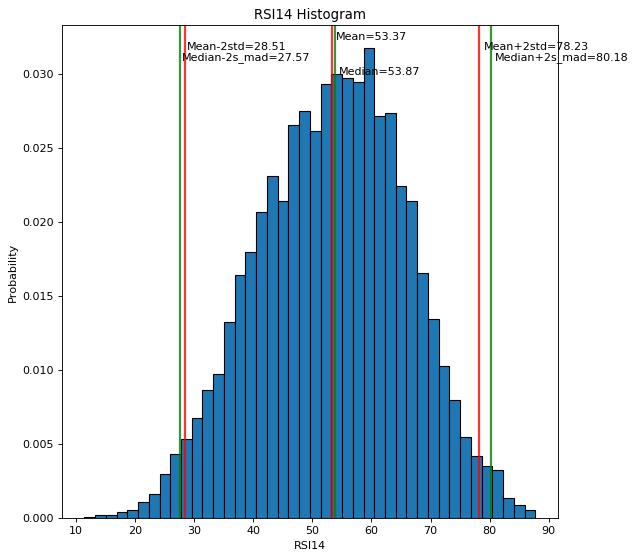

Column RSI20 is a numerical value
Number of unique features 7678 
Number of bins with Freedman und Diaconis:  46
n=7687, q25=45.82, q75=60.56, min=16.04, max=84.65, interval length=1.49. Number of intervals=46
Feature characteristics for RSI20:
Min value =  16.039556149763506
Max value =  84.65211025807436
Mean =  53.21
Median = 53.69664128834537
Standard deviation = 10.5657
Skew = -0.1018
kurtosis = -0.2725


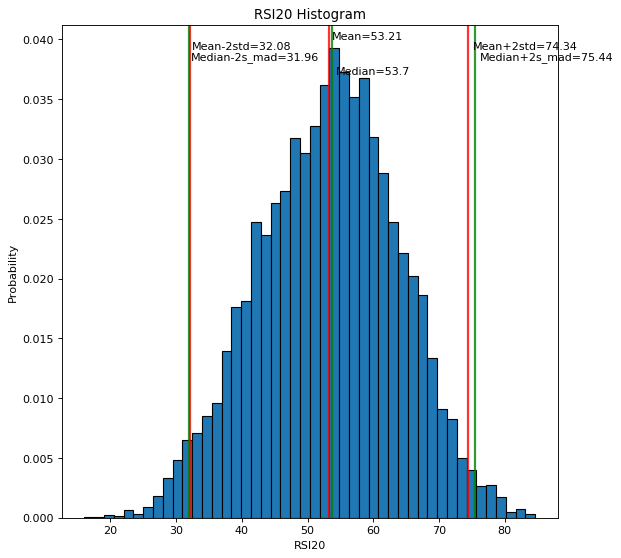

Column RSI25 is a numerical value
Number of unique features 7674 
Number of bins with Freedman und Diaconis:  48
n=7687, q25=46.53, q75=59.73, min=18.98, max=82.87, interval length=1.34. Number of intervals=48
Feature characteristics for RSI25:
Min value =  18.98358055733759
Max value =  82.87428334883086
Mean =  53.12
Median = 53.48864402363478
Standard deviation = 9.5672
Skew = -0.0991
kurtosis = -0.2381


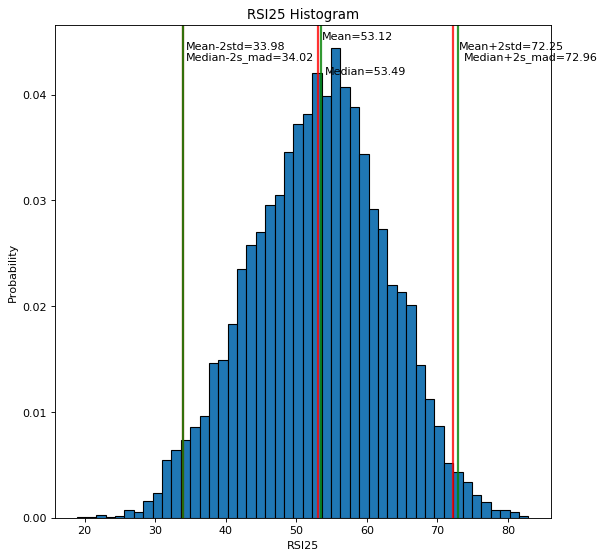

Column RSI2_diff is a numerical value
Number of unique features 7672 
Number of bins with Freedman und Diaconis:  48
n=7687, q25=-17.92, q75=17.28, min=-86.83, max=85.56, interval length=3.57. Number of intervals=48
Feature characteristics for RSI2_diff:
Min value =  -86.83469044352677
Max value =  85.56481995833677
Mean =  0.01
Median = 0.4629408050961388
Standard deviation = 28.8214
Skew = 0.0057
kurtosis = -0.062


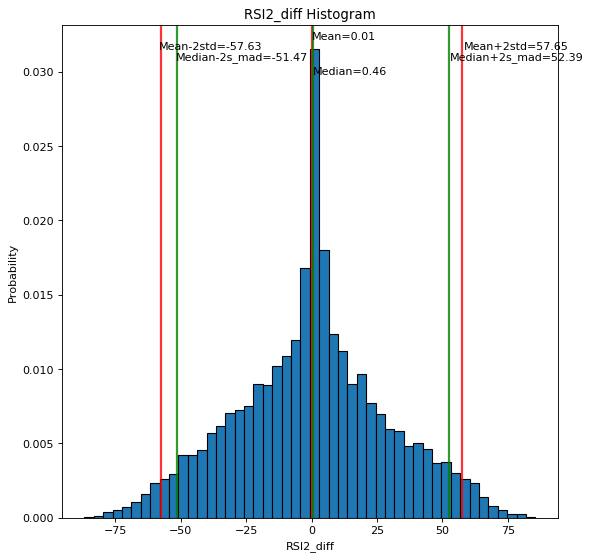

Column RSI3_diff is a numerical value
Number of unique features 7676 
Number of bins with Freedman und Diaconis:  56
n=7687, q25=-12.67, q75=11.59, min=-71.51, max=66.01, interval length=2.46. Number of intervals=56
Feature characteristics for RSI3_diff:
Min value =  -71.51025648025454
Max value =  66.00797499233533
Mean =  0.01
Median = 0.7138493602241169
Standard deviation = 19.5106
Skew = -0.0049
kurtosis = 0.2294


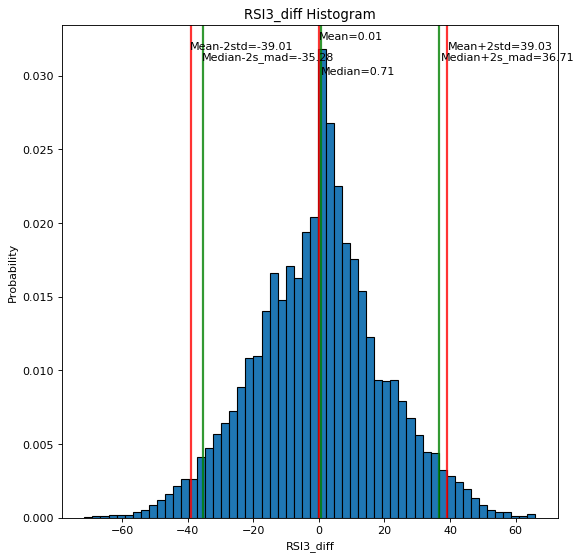

Column RSI5_diff is a numerical value
Number of unique features 7677 
Number of bins with Freedman und Diaconis:  66
n=7687, q25=-7.69, q75=7.21, min=-55.06, max=44.76, interval length=1.51. Number of intervals=66
Feature characteristics for RSI5_diff:
Min value =  -55.058978464665095
Max value =  44.760619125115355
Mean =  0.0
Median = 0.6004861890495903
Standard deviation = 11.9956
Skew = -0.0445
kurtosis = 0.5272


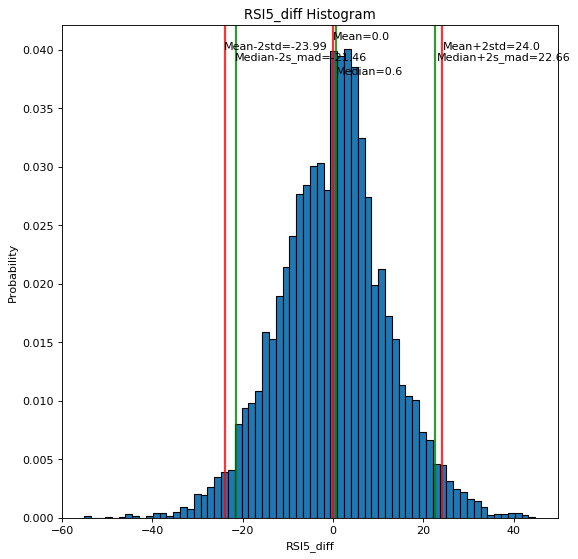

Column RSI9_diff is a numerical value
Number of unique features 7676 
Number of bins with Freedman und Diaconis:  79
n=7687, q25=-4.35, q75=4.21, min=-41.44, max=27.05, interval length=0.87. Number of intervals=79
Feature characteristics for RSI9_diff:
Min value =  -41.439108613078076
Max value =  27.04810298624001
Mean =  0.0
Median = 0.3629859615694215
Standard deviation = 6.8354
Skew = -0.1116
kurtosis = 0.9387


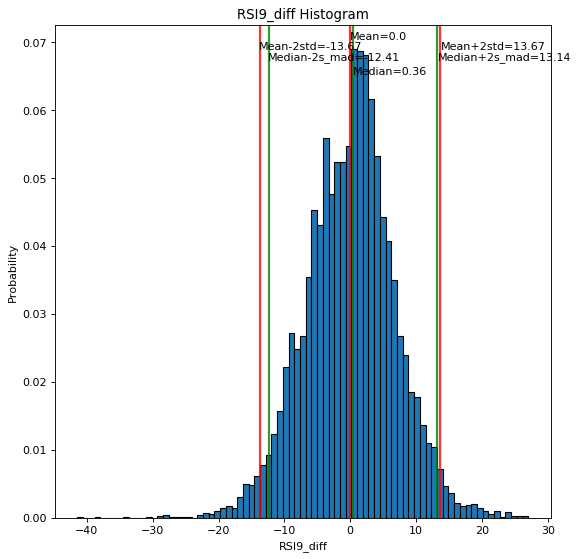

Column RSI10_diff is a numerical value
Number of unique features 7674 
Number of bins with Freedman und Diaconis:  81
n=7687, q25=-3.94, q75=3.83, min=-38.48, max=25.37, interval length=0.79. Number of intervals=81
Feature characteristics for RSI10_diff:
Min value =  -38.478973718003054
Max value =  25.36703426000175
Mean =  0.0
Median = 0.32437706488275353
Standard deviation = 6.1776
Skew = -0.1231
kurtosis = 1.0215


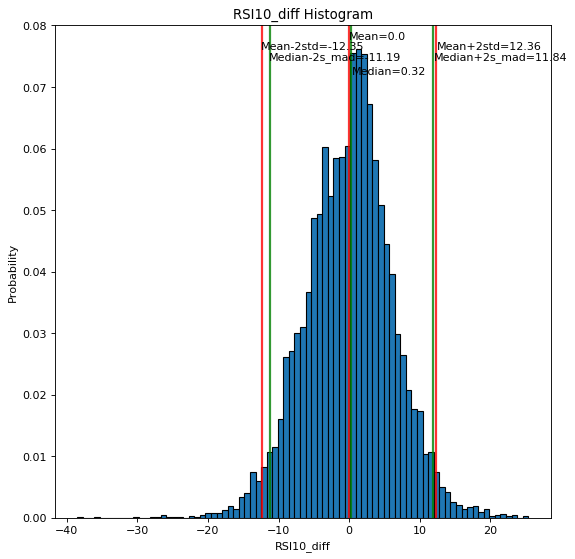

Column RSI14_diff is a numerical value
Number of unique features 7675 
Number of bins with Freedman und Diaconis:  88
n=7687, q25=-2.85, q75=2.80, min=-29.84, max=20.35, interval length=0.57. Number of intervals=88
Feature characteristics for RSI14_diff:
Min value =  -29.84406529719872
Max value =  20.346068208419343
Mean =  0.0
Median = 0.2354068334510089
Standard deviation = 4.4703
Skew = -0.161
kurtosis = 1.3159


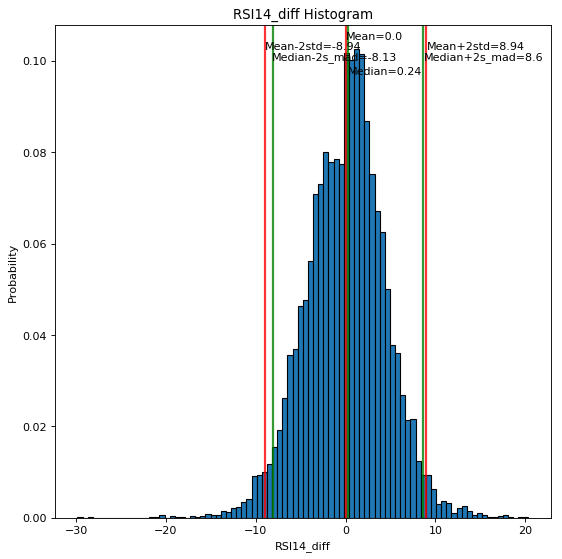

Column RSI20_diff is a numerical value
Number of unique features 7677 
Number of bins with Freedman und Diaconis:  95
n=7687, q25=-2.00, q75=2.00, min=-22.81, max=15.62, interval length=0.41. Number of intervals=95
Feature characteristics for RSI20_diff:
Min value =  -22.81423499703928
Max value =  15.619328293655373
Mean =  -0.0
Median = 0.16588767029874418
Standard deviation = 3.1718
Skew = -0.2106
kurtosis = 1.7199


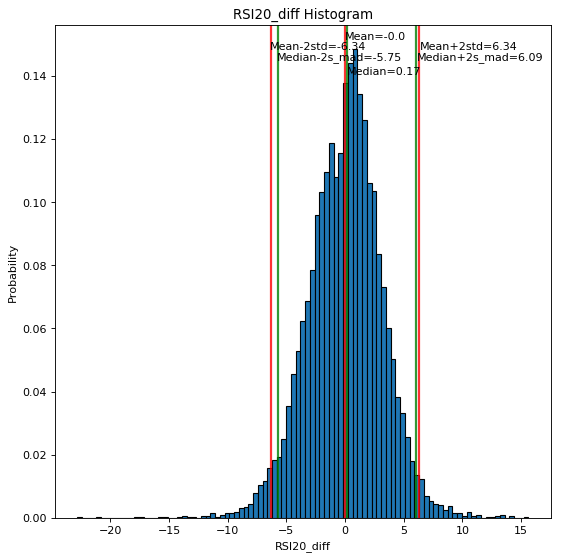

Column RSI25_diff is a numerical value
Number of unique features 7676 
Number of bins with Freedman und Diaconis:  100
n=7687, q25=-1.59, q75=1.61, min=-19.46, max=13.04, interval length=0.33. Number of intervals=100
Feature characteristics for RSI25_diff:
Min value =  -19.45607290945786
Max value =  13.0382903096526
Mean =  -0.0
Median = 0.1343289232691376
Standard deviation = 2.5589
Skew = -0.2478
kurtosis = 2.0365


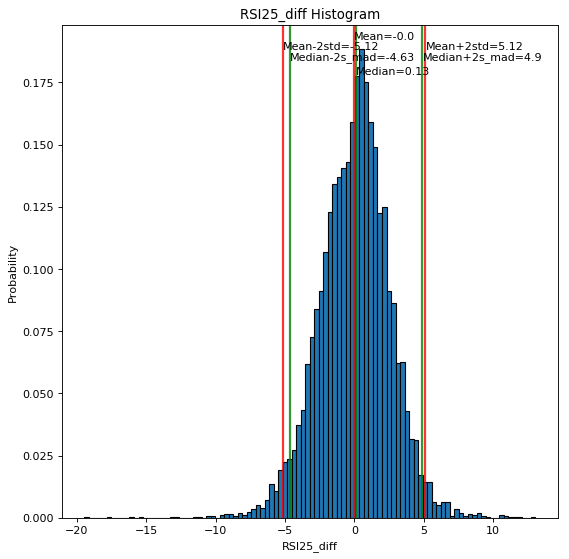

Column Stoch_Sk1383 is a numerical value
Number of unique features 7413 
Number of bins with Freedman und Diaconis:  21
n=7687, q25=34.66, q75=82.75, min=-0.00, max=100.00, interval length=4.87. Number of intervals=21
Feature characteristics for Stoch_Sk1383:
Min value =  -1.0835776720341528e-13
Max value =  100.00000000000004
Mean =  58.37
Median = 62.21054288419594
Standard deviation = 27.3451
Skew = -0.2941
kurtosis = -1.1505


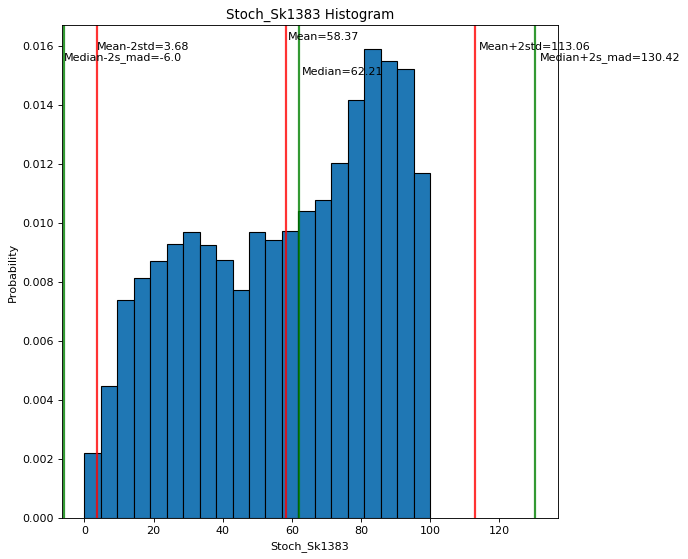

Column Stoch_Sd1383 is a numerical value
Number of unique features 7651 
Number of bins with Freedman und Diaconis:  21
n=7687, q25=35.13, q75=82.60, min=0.31, max=100.00, interval length=4.81. Number of intervals=21
Feature characteristics for Stoch_Sd1383:
Min value =  0.312499999999571
Max value =  99.9999999999996
Mean =  58.37
Median = 62.025731767293294
Standard deviation = 27.0272
Skew = -0.2934
kurtosis = -1.1478


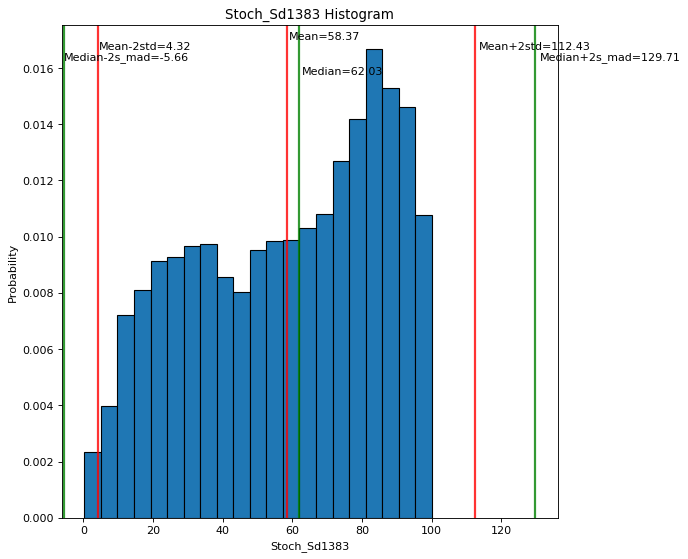

Column Stoch_Sk533 is a numerical value
Number of unique features 6869 
Number of bins with Freedman und Diaconis:  19
n=7687, q25=29.85, q75=82.79, min=-0.00, max=100.00, interval length=5.36. Number of intervals=19
Feature characteristics for Stoch_Sk533:
Min value =  -4.263256414560601e-14
Max value =  100.00000000000034
Mean =  55.74
Median = 58.505354058721984
Standard deviation = 30.1111
Skew = -0.2004
kurtosis = -1.1999


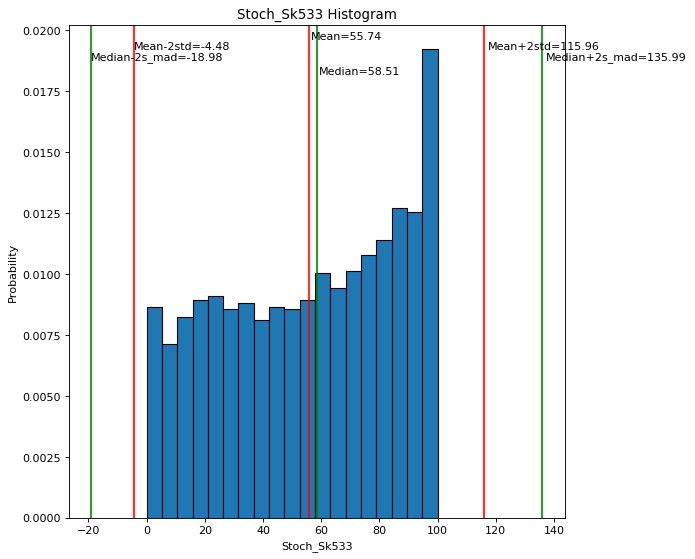

Column Stoch_Sd533 is a numerical value
Number of unique features 7527 
Number of bins with Freedman und Diaconis:  21
n=7687, q25=32.18, q75=79.95, min=-0.00, max=100.00, interval length=4.84. Number of intervals=21
Feature characteristics for Stoch_Sd533:
Min value =  -1.3766765505351941e-14
Max value =  100.00000000000044
Mean =  55.73
Median = 58.05305920169302
Standard deviation = 27.773
Skew = -0.192
kurtosis = -1.1327


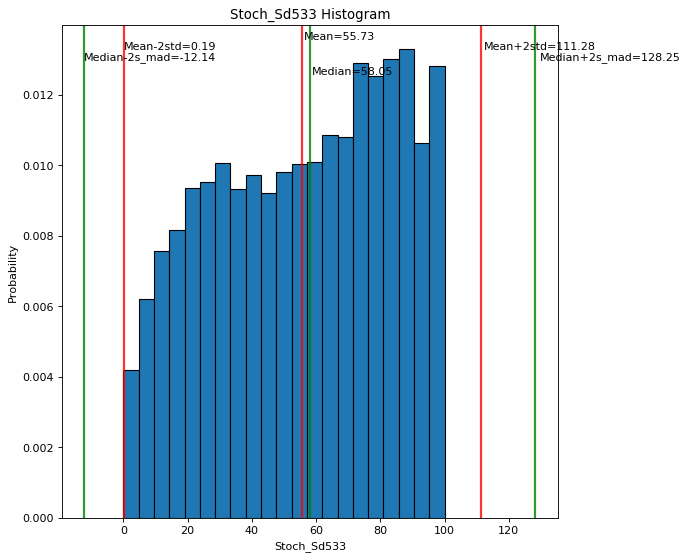

Column Stoch_Sk2177 is a numerical value
Number of unique features 7443 
Number of bins with Freedman und Diaconis:  18
n=7687, q25=32.62, q75=86.48, min=0.00, max=100.00, interval length=5.46. Number of intervals=18
Feature characteristics for Stoch_Sk2177:
Min value =  1.2935684269775395e-13
Max value =  100.00000000000028
Mean =  59.61
Median = 66.19860237437874
Standard deviation = 29.3707
Skew = -0.3465
kurtosis = -1.2623


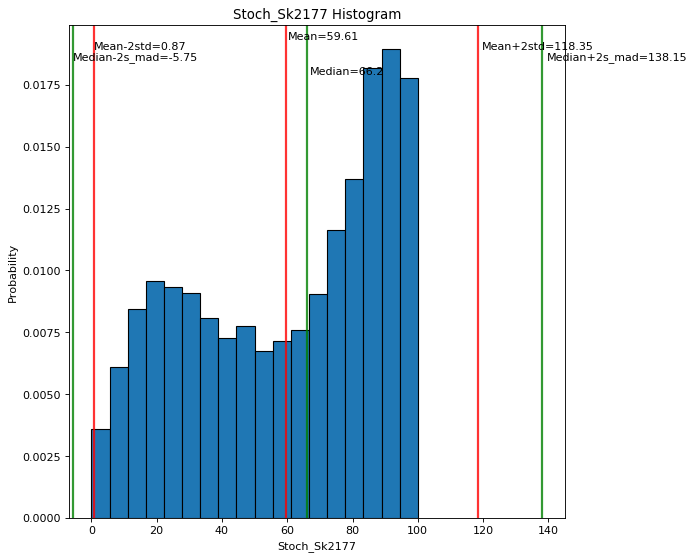

Column Stoch_Sd2177 is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  19
n=7687, q25=34.04, q75=85.25, min=2.11, max=99.73, interval length=5.19. Number of intervals=19
Feature characteristics for Stoch_Sd2177:
Min value =  2.112032308553176
Max value =  99.72571349333772
Mean =  59.62
Median = 65.17608442014208
Standard deviation = 28.1494
Skew = -0.3371
kurtosis = -1.2388


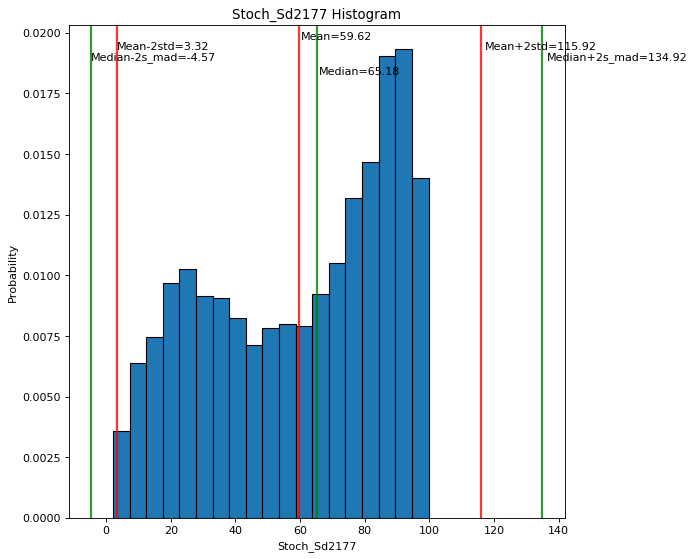

Column Stoch_Sk211414 is a numerical value
Number of unique features 7484 
Number of bins with Freedman und Diaconis:  21
n=7687, q25=37.03, q75=83.43, min=2.55, max=99.72, interval length=4.70. Number of intervals=21
Feature characteristics for Stoch_Sk211414:
Min value =  2.553810071670118
Max value =  99.7203685185508
Mean =  59.62
Median = 63.22977381383499
Standard deviation = 26.4244
Skew = -0.3198
kurtosis = -1.1443


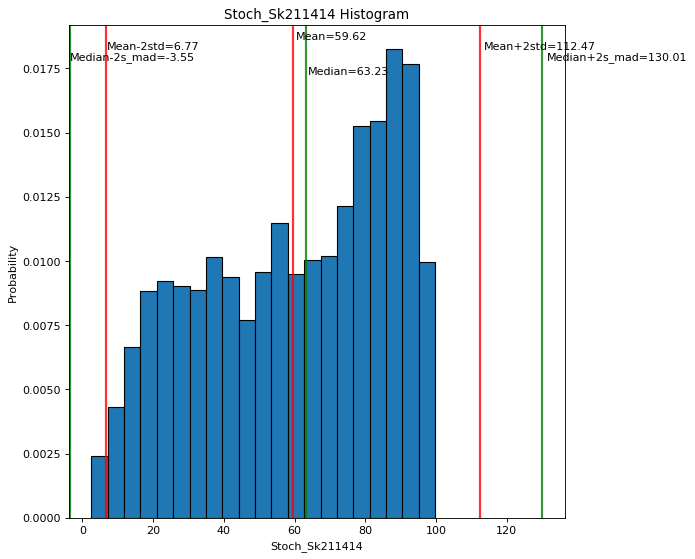

Column Stoch_Sd211414 is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  23
n=7687, q25=40.10, q75=81.15, min=3.98, max=98.47, interval length=4.16. Number of intervals=23
Feature characteristics for Stoch_Sd211414:
Min value =  3.981882712356478
Max value =  98.47145319047922
Mean =  59.64
Median = 62.205360245643064
Standard deviation = 24.4044
Skew = -0.3126
kurtosis = -1.0546


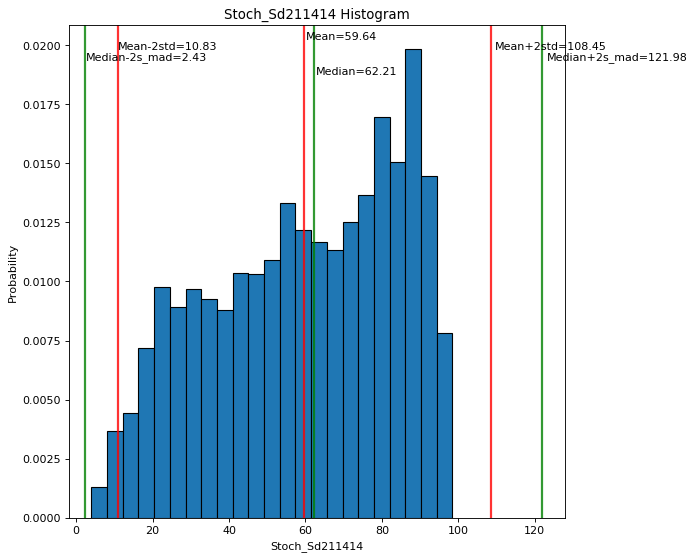

Column MACD12_26_9 is a numerical value
Number of unique features 7683 
Number of bins with Freedman und Diaconis:  89
n=7687, q25=-5.30, q75=10.49, min=-74.30, max=67.91, interval length=1.60. Number of intervals=89
Feature characteristics for MACD12_26_9:
Min value =  -74.29532051282342
Max value =  67.91070512820396
Mean =  1.25
Median = 2.3449999999963893
Standard deviation = 16.6327
Skew = -0.5839
kurtosis = 2.1439


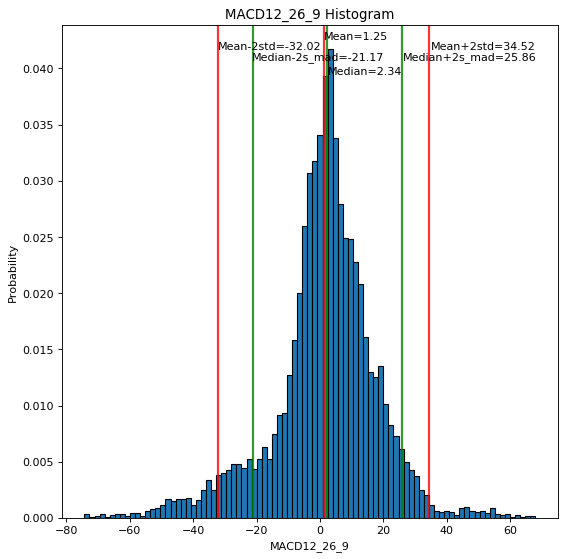

Column MACDsig12_26_9 is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  88
n=7687, q25=-4.79, q75=9.94, min=-69.92, max=61.31, interval length=1.49. Number of intervals=88
Feature characteristics for MACDsig12_26_9:
Min value =  -69.92047720798011
Max value =  61.31461538461414
Mean =  1.26
Median = 2.280334757833853
Standard deviation = 15.8183
Skew = -0.5629
kurtosis = 2.1781


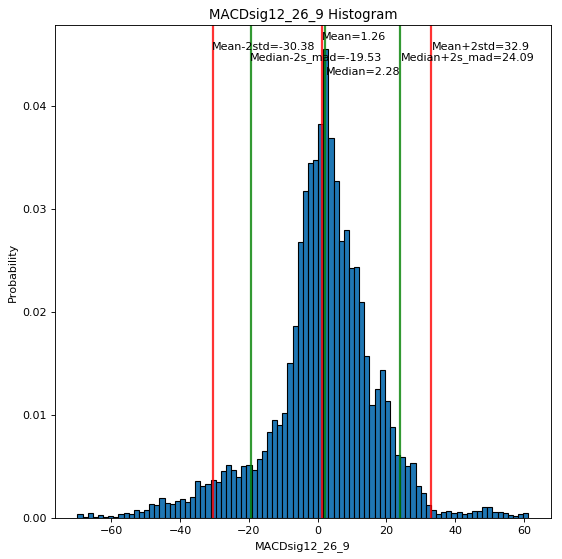

Column MACD5_35_5 is a numerical value
Number of unique features 7684 
Number of bins with Freedman und Diaconis:  105
n=7687, q25=-9.27, q75=19.69, min=-136.87, max=170.89, interval length=2.93. Number of intervals=105
Feature characteristics for MACD5_35_5:
Min value =  -136.873714285716
Max value =  170.89228571428475
Mean =  2.68
Median = 4.933999999996331
Standard deviation = 31.2322
Skew = -0.5106
kurtosis = 2.6513


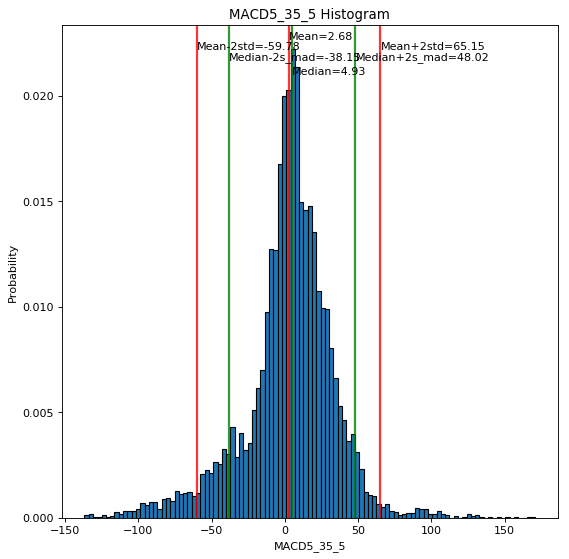

Column MACDsig5_35_5 is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  102
n=7687, q25=-9.13, q75=19.24, min=-134.19, max=159.04, interval length=2.88. Number of intervals=102
Feature characteristics for MACDsig5_35_5:
Min value =  -134.18674285714462
Max value =  159.04057142857042
Mean =  2.68
Median = 4.941600000000075
Standard deviation = 30.6578
Skew = -0.4928
kurtosis = 2.5737


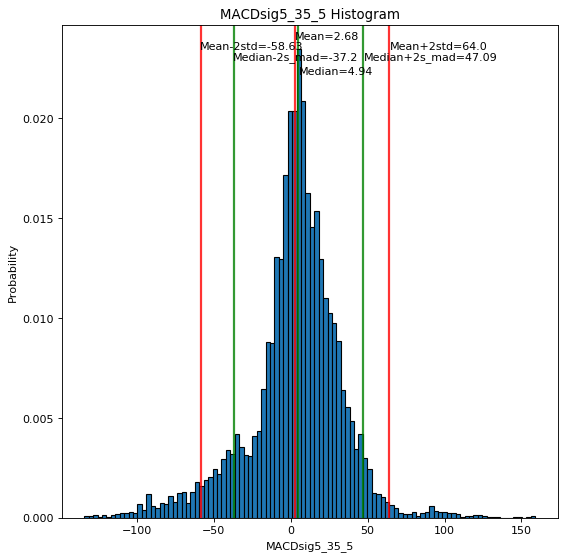

Column MACD12_26_9Diff is a numerical value
Number of unique features 7613 
Number of bins with Freedman und Diaconis:  138
n=7687, q25=-0.99, q75=0.93, min=-11.83, max=14.99, interval length=0.19. Number of intervals=138
Feature characteristics for MACD12_26_9Diff:
Min value =  -11.830128205128176
Max value =  14.987307692307468
Mean =  -0.0
Median = -0.04461538461532655
Standard deviation = 2.2692
Skew = 0.2534
kurtosis = 2.8616


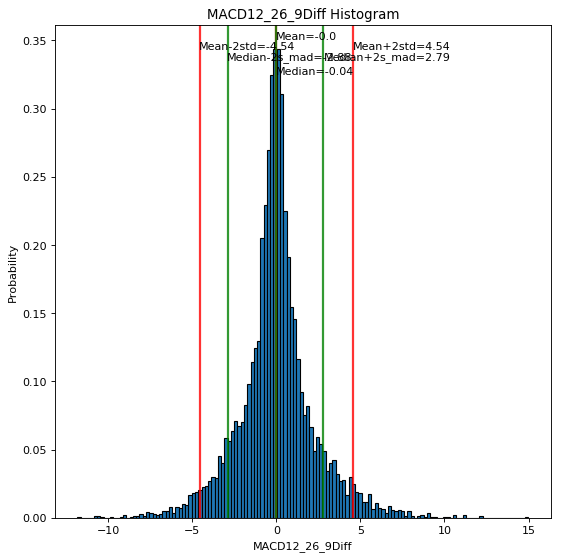

Column MACDsig12_26_9Diff is a numerical value
Number of unique features 7687 
Number of bins with Freedman und Diaconis:  101
n=7687, q25=-0.80, q75=0.74, min=-7.61, max=8.06, interval length=0.16. Number of intervals=101
Feature characteristics for MACDsig12_26_9Diff:
Min value =  -7.606844729344782
Max value =  8.063710826210757
Mean =  -0.0
Median = -0.04036324786325896
Standard deviation = 1.771
Skew = 0.1984
kurtosis = 1.9739


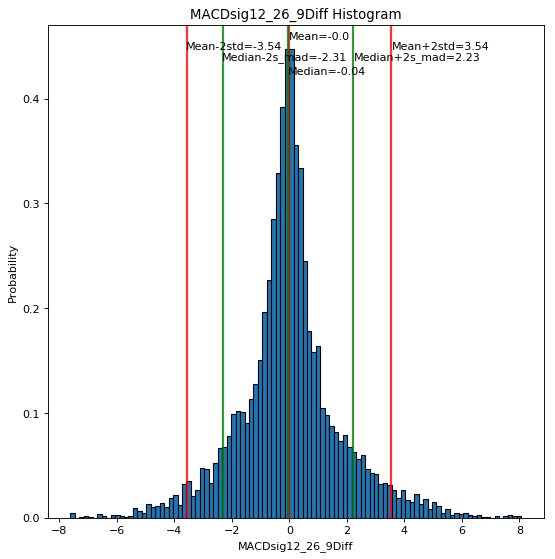

Column MACD5_35_5Diff is a numerical value
Number of unique features 7536 
Number of bins with Freedman und Diaconis:  149
n=7687, q25=-1.92, q75=2.00, min=-30.12, max=28.96, interval length=0.40. Number of intervals=149
Feature characteristics for MACD5_35_5Diff:
Min value =  -30.121428571428623
Max value =  28.955142857142853
Mean =  -0.0
Median = 0.007428571428590658
Standard deviation = 4.6989
Skew = -0.0308
kurtosis = 3.4857


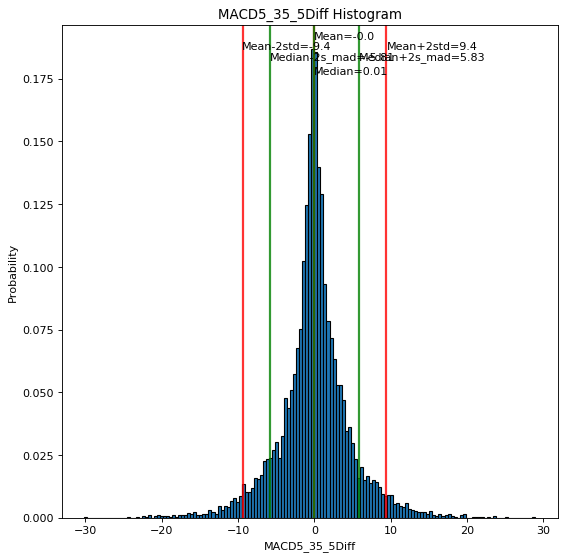

Column MACDsig5_35_5Diff is a numerical value
Number of unique features 7681 
Number of bins with Freedman und Diaconis:  123
n=7687, q25=-1.58, q75=1.62, min=-19.99, max=19.76, interval length=0.32. Number of intervals=123
Feature characteristics for MACDsig5_35_5Diff:
Min value =  -19.985885714285587
Max value =  19.75622857142853
Mean =  -0.0
Median = 0.005142857142862667
Standard deviation = 3.7284
Skew = -0.0272
kurtosis = 3.3085


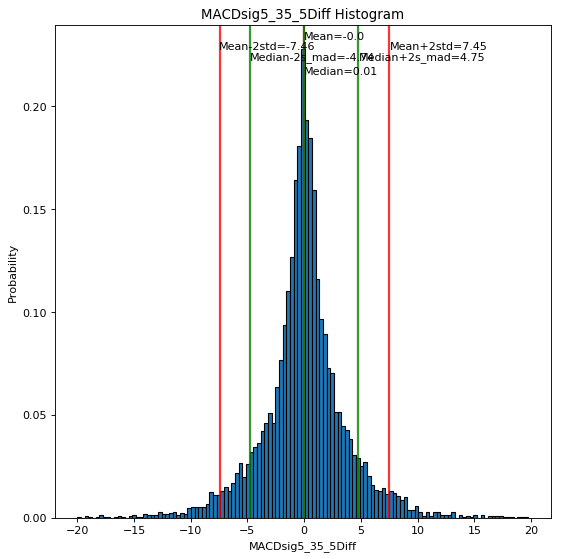

Column MACD12_26_9DiffDirChange is a numerical value
Number of unique features 11 
Number of bins = number of features {}:  11
n=7687, q25=-0.13, q75=0.13, min=-1.00, max=1.00, interval length=0.03. Number of intervals=11
Feature characteristics for MACD12_26_9DiffDirChange:
Min value =  -1.0
Max value =  1.0
Mean =  -0.0
Median = 0.0
Standard deviation = 0.466
Skew = 0.0064
kurtosis = 0.7263


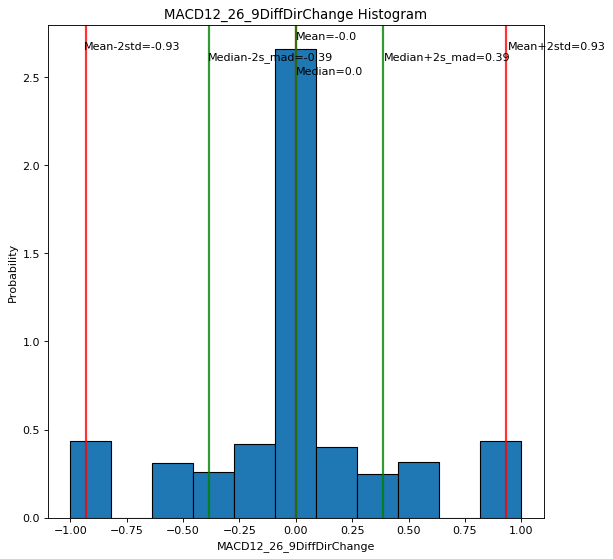

Column MACDsig12_26_9DiffDirChange is a numerical value
Number of unique features 11 
Number of bins <= 100:  11
n=7687, q25=0.00, q75=0.00, min=-1.00, max=1.00, interval length=0.00. Number of intervals=11
Feature characteristics for MACDsig12_26_9DiffDirChange:
Min value =  -1.0
Max value =  1.0
Mean =  -0.0
Median = 0.0
Standard deviation = 0.3138
Skew = 0.0036
kurtosis = 4.5711


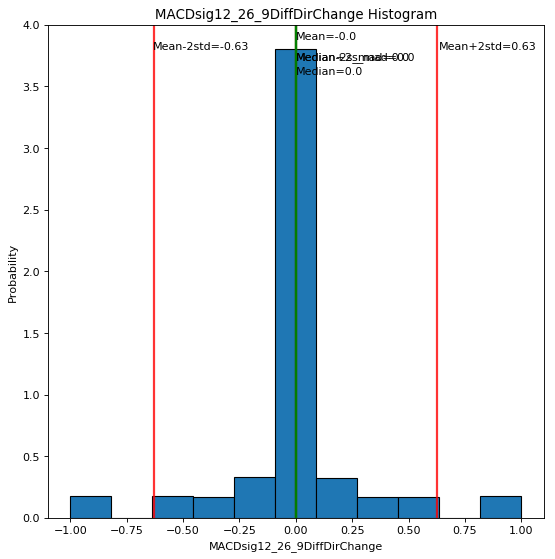

Column MACD5_35_5DiffDirChange is a numerical value
Number of unique features 11 
Number of bins = number of features {}:  11
n=7687, q25=-0.22, q75=0.22, min=-1.00, max=1.00, interval length=0.04. Number of intervals=11
Feature characteristics for MACD5_35_5DiffDirChange:
Min value =  -1.0
Max value =  1.0
Mean =  -0.0
Median = 0.0
Standard deviation = 0.5279
Skew = 0.0092
kurtosis = -0.1179


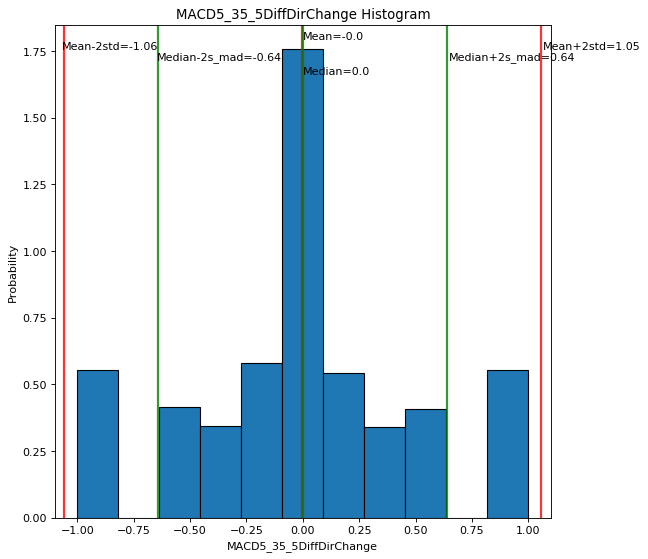

Column MACDsig5_35_5DiffDirChange is a numerical value
Number of unique features 11 
Number of bins = number of features {}:  11
n=7687, q25=-0.13, q75=0.13, min=-1.00, max=1.00, interval length=0.03. Number of intervals=11
Feature characteristics for MACDsig5_35_5DiffDirChange:
Min value =  -1.0
Max value =  1.0
Mean =  -0.0
Median = 0.0
Standard deviation = 0.415
Skew = 0.0045
kurtosis = 1.3908


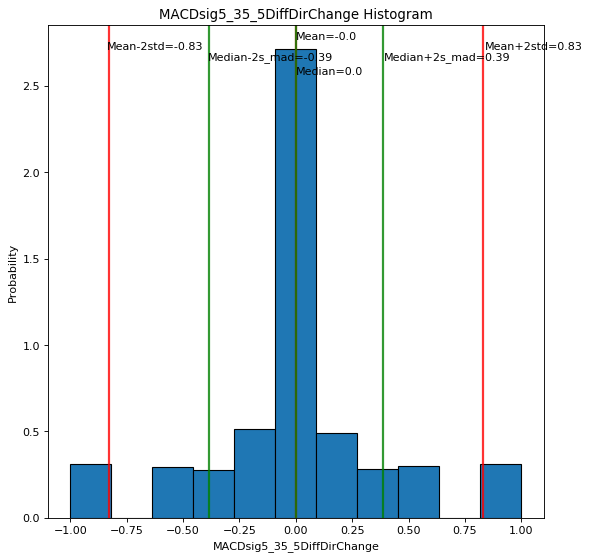

Column week_of_year is a numerical value
Number of unique features 53 
Number of bins with Freedman und Diaconis:  20
n=7687, q25=14.00, q75=40.00, min=1.00, max=53.00, interval length=2.63. Number of intervals=20
Feature characteristics for week_of_year:
Min value =  1
Max value =  53
Mean =  26.8
Median = 27.0
Standard deviation = 14.8757
Skew = -0.0434
kurtosis = -1.202


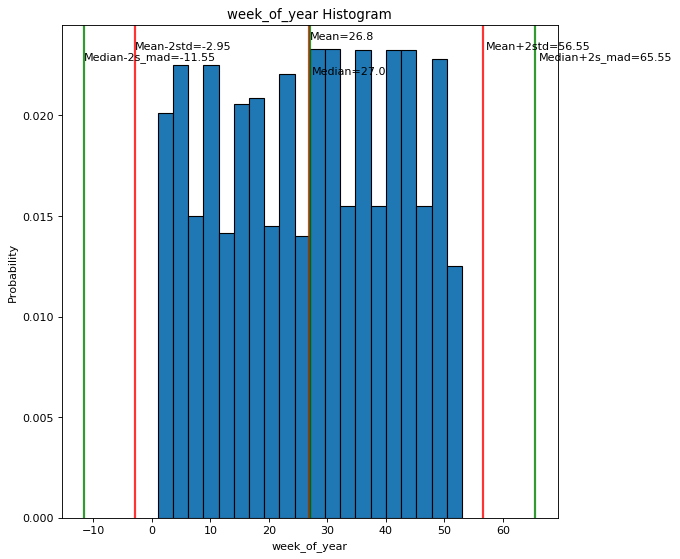

Column day_of_year is a numerical value
Number of unique features 362 
Number of bins with Freedman und Diaconis:  20
n=7687, q25=93.00, q75=274.00, min=2.00, max=365.00, interval length=18.34. Number of intervals=20
Feature characteristics for day_of_year:
Min value =  2
Max value =  365
Mean =  184.25
Median = 188.0
Standard deviation = 104.1578
Skew = -0.0431
kurtosis = -1.2018


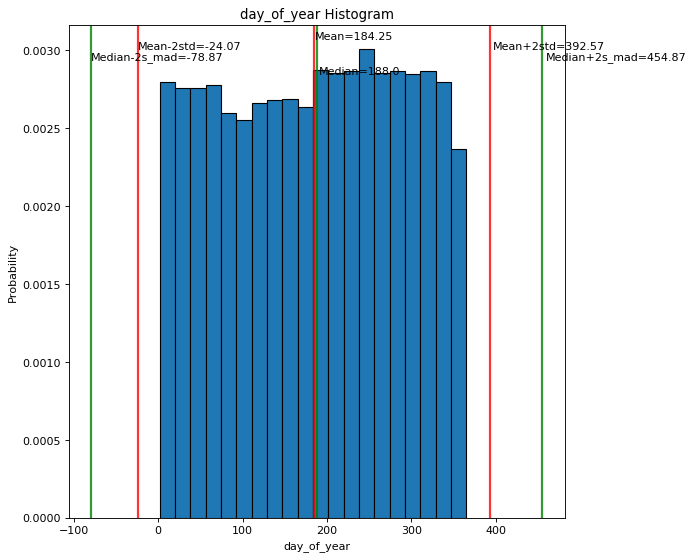

Column day_of_month is a numerical value
Number of unique features 31 
Number of bins with Freedman und Diaconis:  20
n=7687, q25=8.00, q75=23.00, min=1.00, max=31.00, interval length=1.52. Number of intervals=20
Feature characteristics for day_of_month:
Min value =  1
Max value =  31
Mean =  15.73
Median = 16.0
Standard deviation = 8.7327
Skew = 0.0191
kurtosis = -1.18


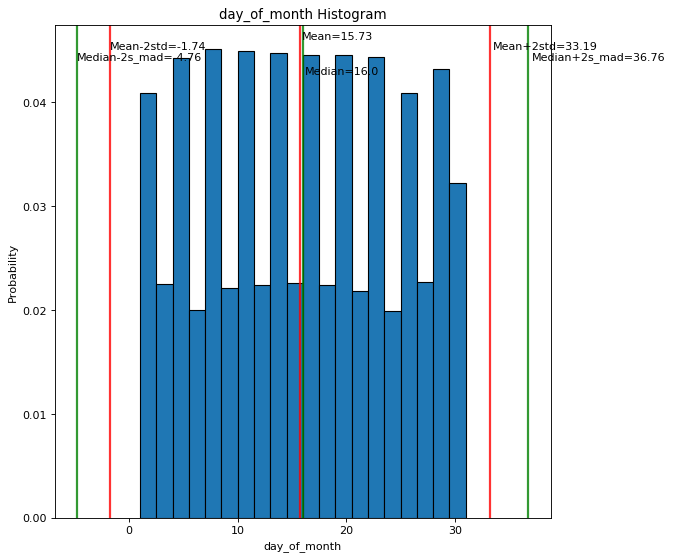

Column day_week__0 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for day_week__0:
Min value =  0
Max value =  1
Mean =  0.2
Median = 0.0
Standard deviation = 0.3977
Skew = 1.5243
kurtosis = 0.3235


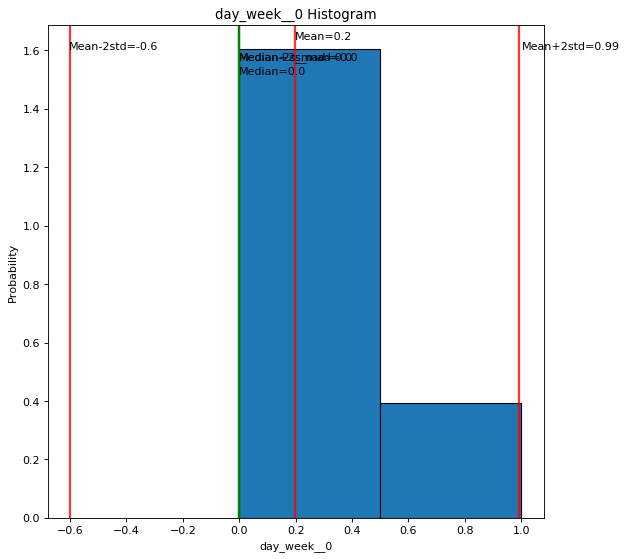

Column day_week__1 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for day_week__1:
Min value =  0
Max value =  1
Mean =  0.2
Median = 0.0
Standard deviation = 0.4026
Skew = 1.4735
kurtosis = 0.1713


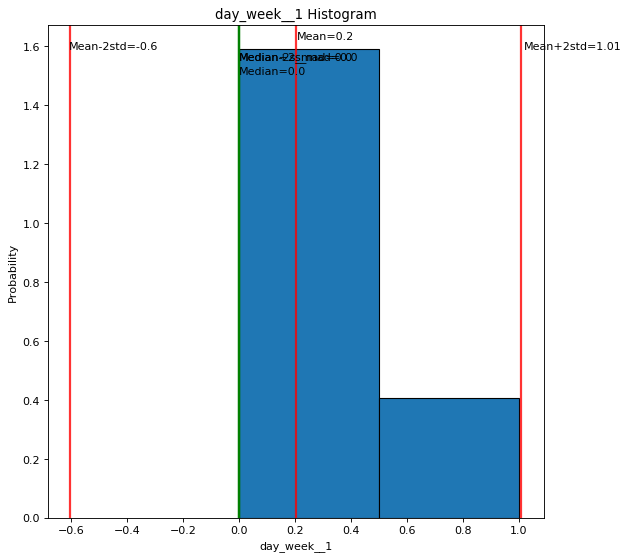

Column day_week__2 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for day_week__2:
Min value =  0
Max value =  1
Mean =  0.2
Median = 0.0
Standard deviation = 0.4027
Skew = 1.4725
kurtosis = 0.1683


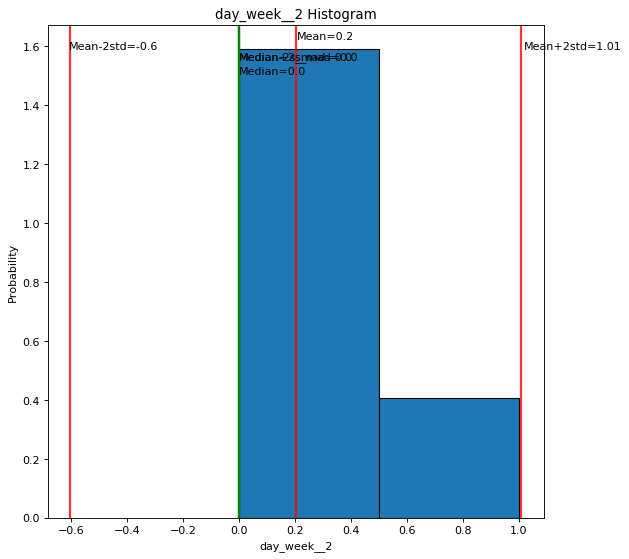

Column day_week__3 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for day_week__3:
Min value =  0
Max value =  1
Mean =  0.2
Median = 0.0
Standard deviation = 0.4
Skew = 1.5007
kurtosis = 0.2522


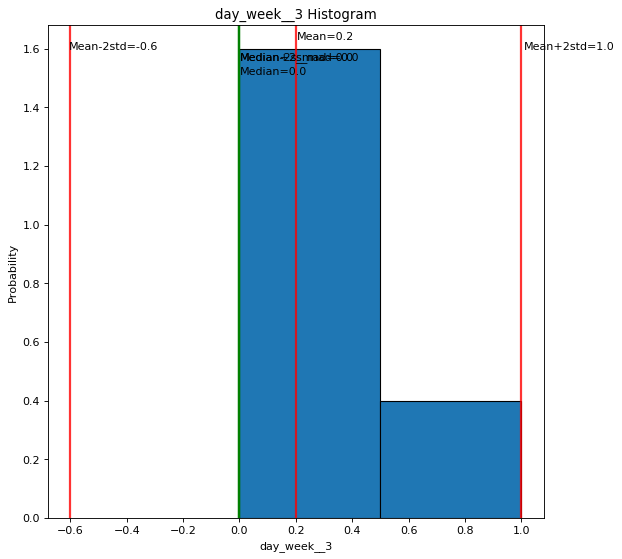

Column day_week__4 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for day_week__4:
Min value =  0
Max value =  1
Mean =  0.2
Median = 0.0
Standard deviation = 0.3968
Skew = 1.5336
kurtosis = 0.3521


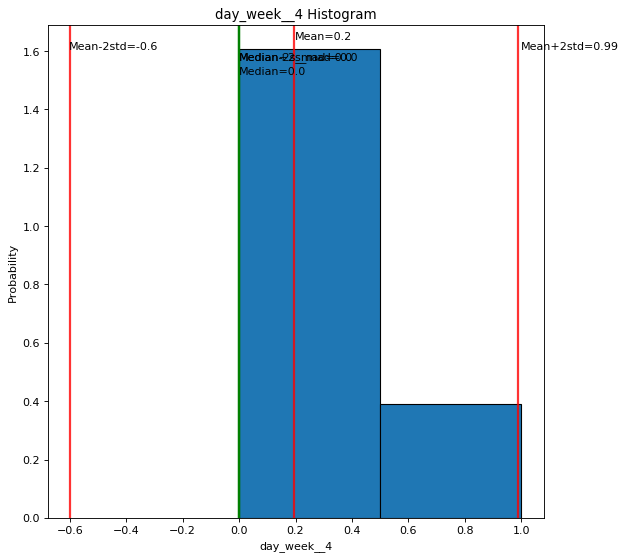

Column day_week__5 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for day_week__5:
Min value =  0
Max value =  1
Mean =  0.0
Median = 0.0
Standard deviation = 0.0114
Skew = 87.6755
kurtosis = 7687.0


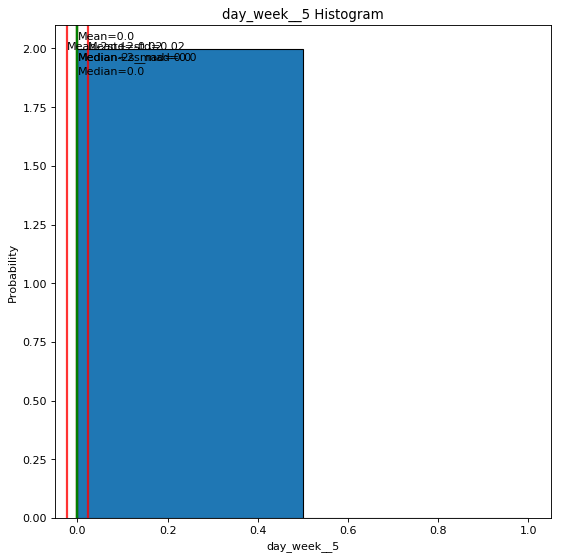

Column day_week__6 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for day_week__6:
Min value =  0
Max value =  1
Mean =  0.0
Median = 0.0
Standard deviation = 0.0114
Skew = 87.6755
kurtosis = 7687.0


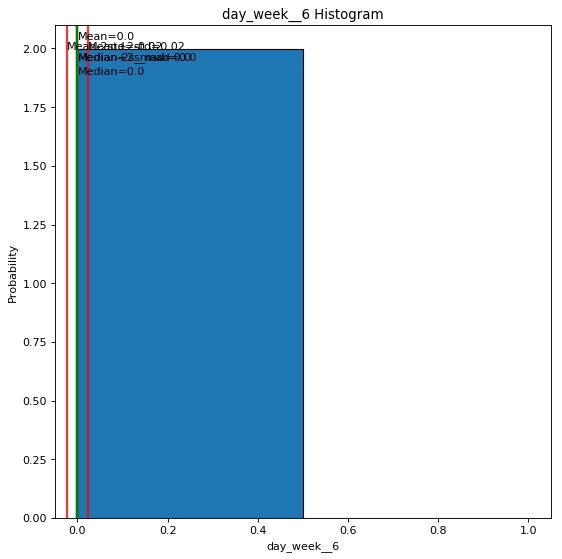

Column month_year__1 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__1:
Min value =  0
Max value =  1
Mean =  0.08
Median = 0.0
Standard deviation = 0.2733
Skew = 3.0645
kurtosis = 7.3933


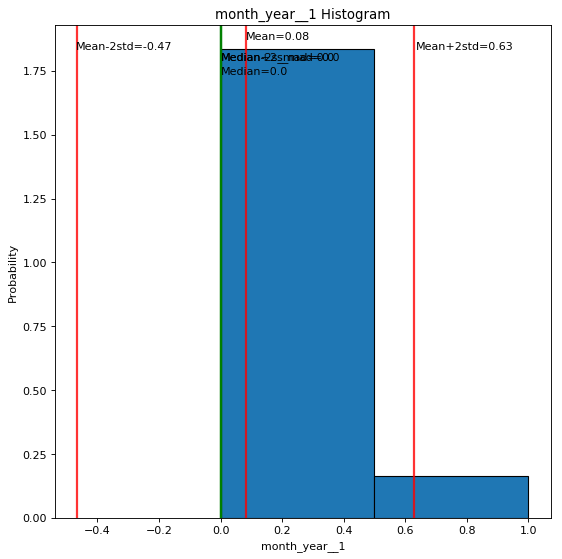

Column month_year__2 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__2:
Min value =  0
Max value =  1
Mean =  0.08
Median = 0.0
Standard deviation = 0.2693
Skew = 3.1297
kurtosis = 7.7971


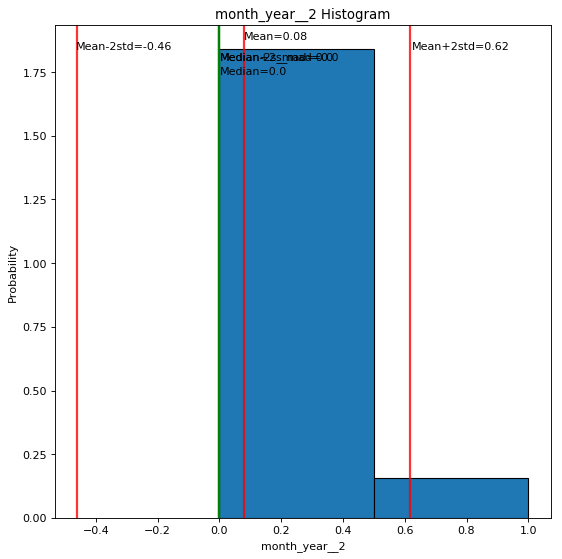

Column month_year__3 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__3:
Min value =  0
Max value =  1
Mean =  0.08
Median = 0.0
Standard deviation = 0.2782
Skew = 2.987
kurtosis = 6.9238


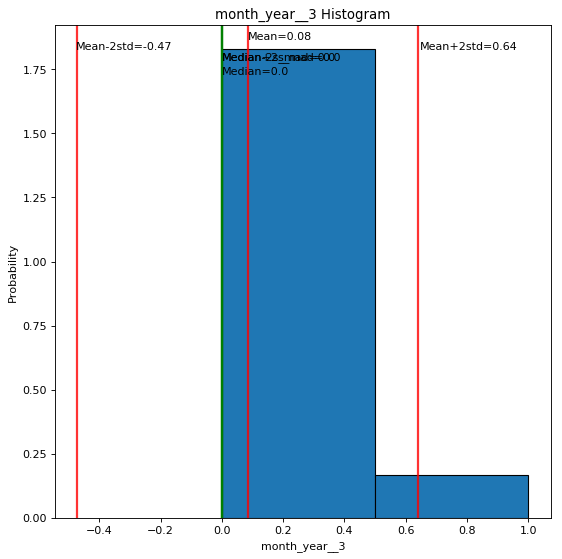

Column month_year__4 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__4:
Min value =  0
Max value =  1
Mean =  0.08
Median = 0.0
Standard deviation = 0.2672
Skew = 3.1634
kurtosis = 8.0092


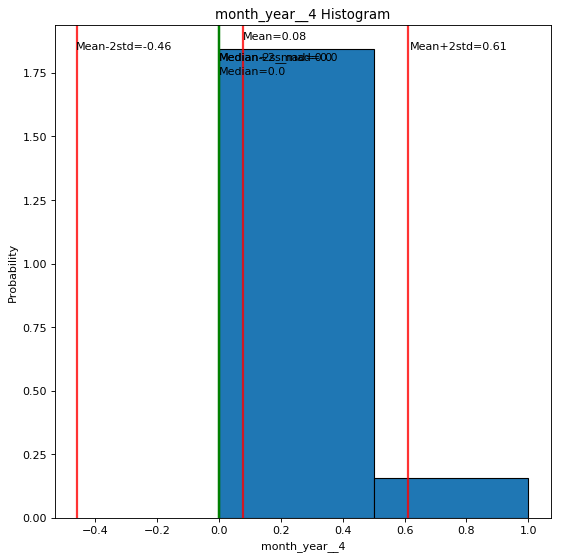

Column month_year__5 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__5:
Min value =  0
Max value =  1
Mean =  0.08
Median = 0.0
Standard deviation = 0.2733
Skew = 3.0645
kurtosis = 7.3933


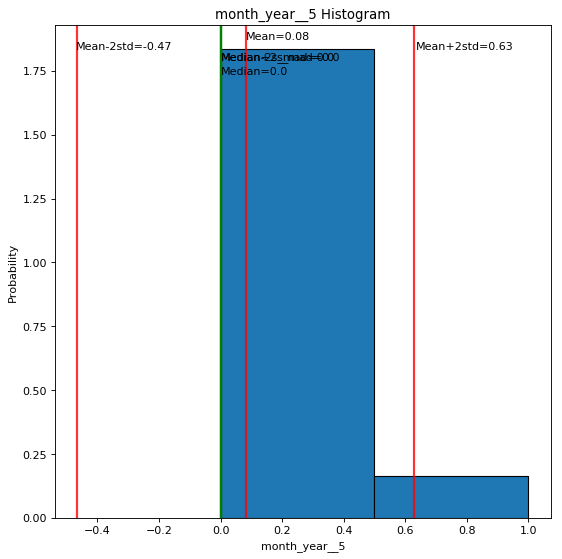

Column month_year__6 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__6:
Min value =  0
Max value =  1
Mean =  0.08
Median = 0.0
Standard deviation = 0.2715
Skew = 3.0935
kurtosis = 7.5717


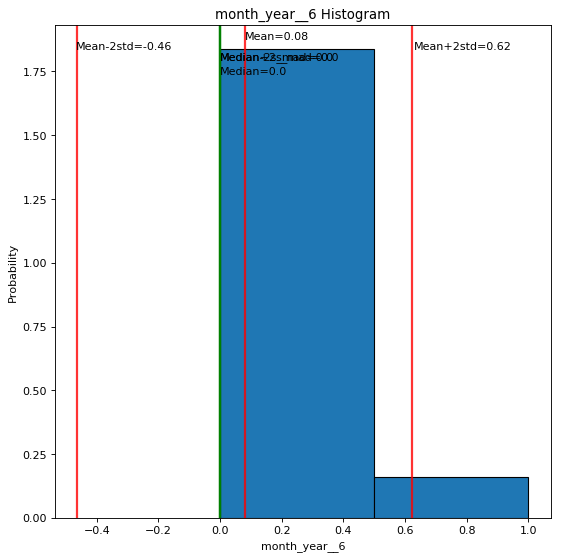

Column month_year__7 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__7:
Min value =  0
Max value =  1
Mean =  0.09
Median = 0.0
Standard deviation = 0.2851
Skew = 2.8821
kurtosis = 6.3084


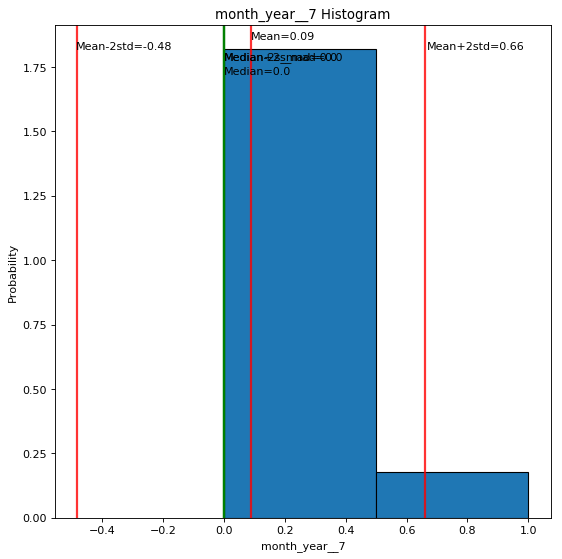

Column month_year__8 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__8:
Min value =  0
Max value =  1
Mean =  0.09
Median = 0.0
Standard deviation = 0.2857
Skew = 2.8737
kurtosis = 6.2601


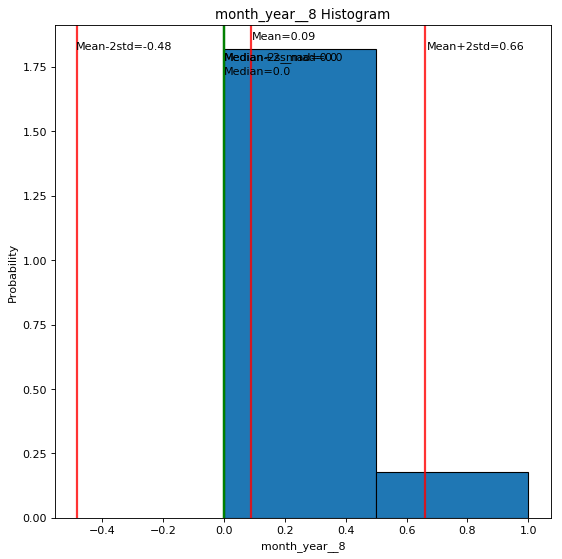

Column month_year__9 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__9:
Min value =  0
Max value =  1
Mean =  0.09
Median = 0.0
Standard deviation = 0.2808
Skew = 2.9482
kurtosis = 6.6938


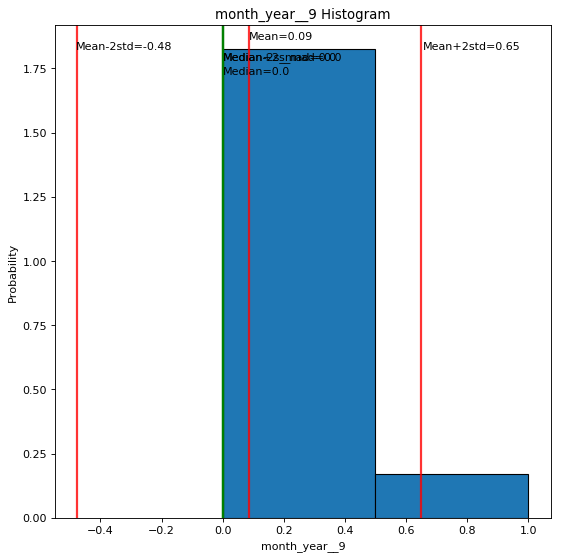

Column month_year__10 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__10:
Min value =  0
Max value =  1
Mean =  0.09
Median = 0.0
Standard deviation = 0.2851
Skew = 2.8821
kurtosis = 6.3084


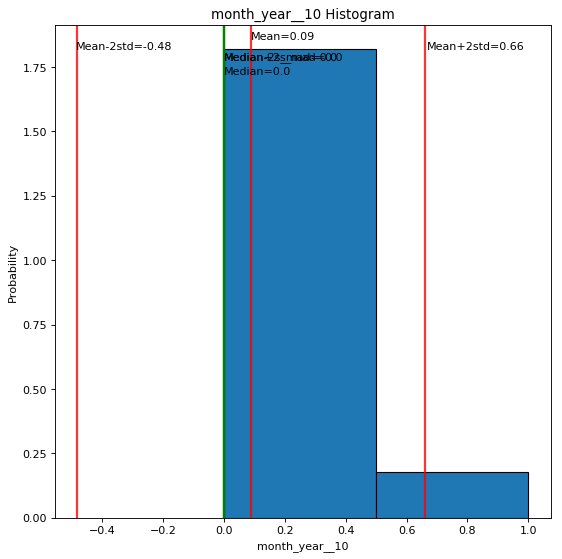

Column month_year__11 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__11:
Min value =  0
Max value =  1
Mean =  0.09
Median = 0.0
Standard deviation = 0.2813
Skew = 2.9394
kurtosis = 6.642


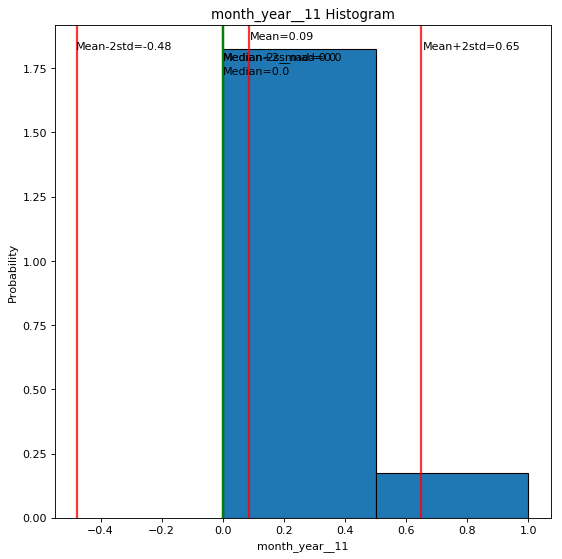

Column month_year__12 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for month_year__12:
Min value =  0
Max value =  1
Mean =  0.08
Median = 0.0
Standard deviation = 0.2643
Skew = 3.2119
kurtosis = 8.3186


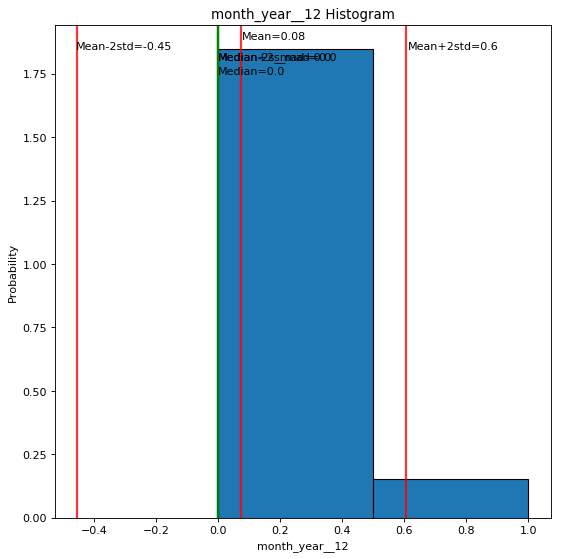

Column week_month__1 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for week_month__1:
Min value =  0
Max value =  1
Mean =  0.09
Median = 0.0
Standard deviation = 0.293
Skew = 2.7663
kurtosis = 5.6538


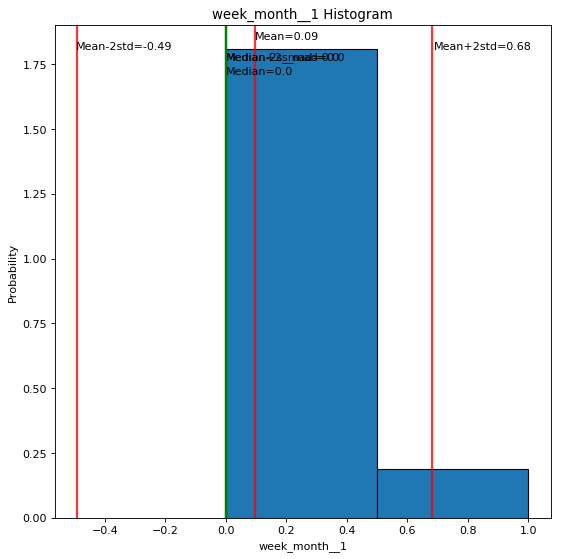

Column week_month__2 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for week_month__2:
Min value =  0
Max value =  1
Mean =  0.23
Median = 0.0
Standard deviation = 0.4218
Skew = 1.2739
kurtosis = -0.3774


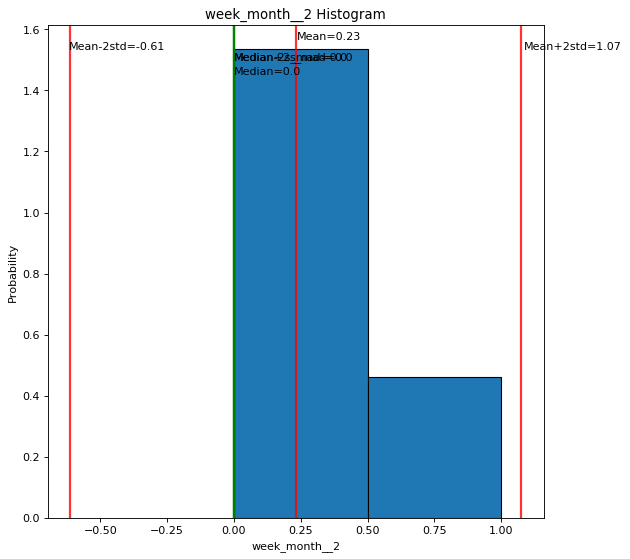

Column week_month__3 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for week_month__3:
Min value =  0
Max value =  1
Mean =  0.24
Median = 0.0
Standard deviation = 0.4241
Skew = 1.2498
kurtosis = -0.4382


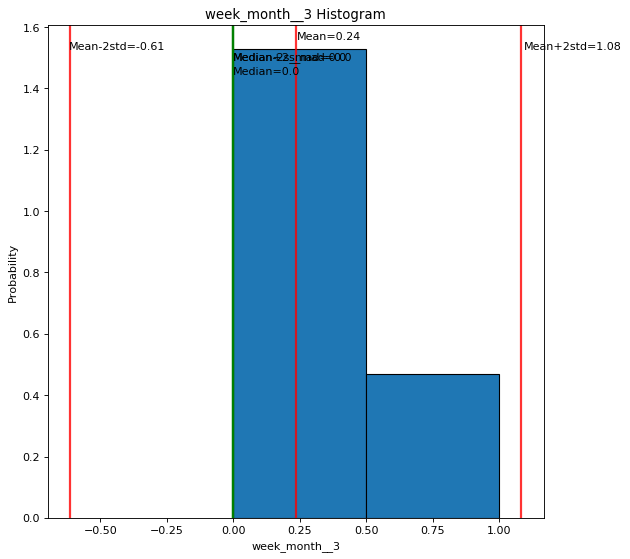

Column week_month__4 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for week_month__4:
Min value =  0
Max value =  1
Mean =  0.23
Median = 0.0
Standard deviation = 0.4201
Skew = 1.2913
kurtosis = -0.3326


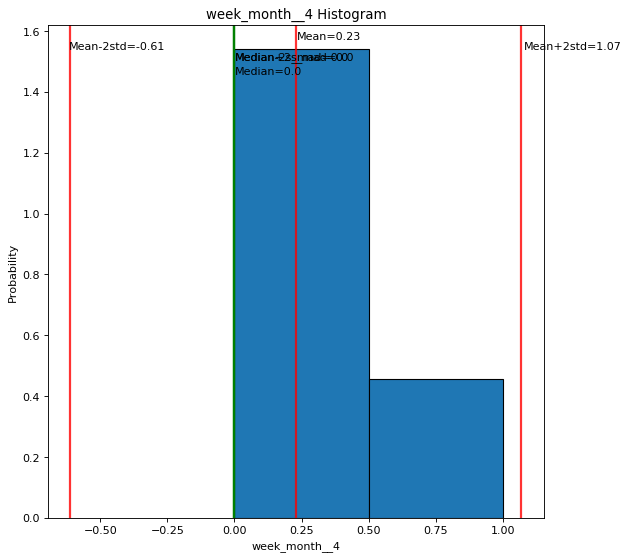

Column week_month__5 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for week_month__5:
Min value =  0
Max value =  1
Mean =  0.2
Median = 0.0
Standard deviation = 0.3975
Skew = 1.5264
kurtosis = 0.3298


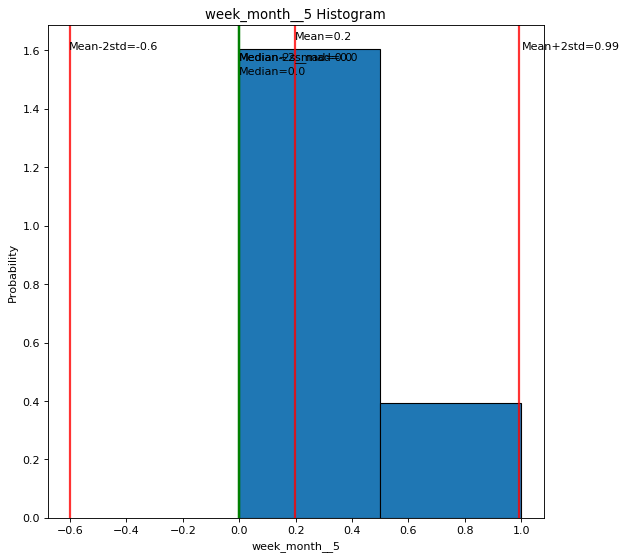

Column week_month__6 is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for week_month__6:
Min value =  0
Max value =  1
Mean =  0.01
Median = 0.0
Standard deviation = 0.1139
Skew = 8.5528
kurtosis = 71.1693


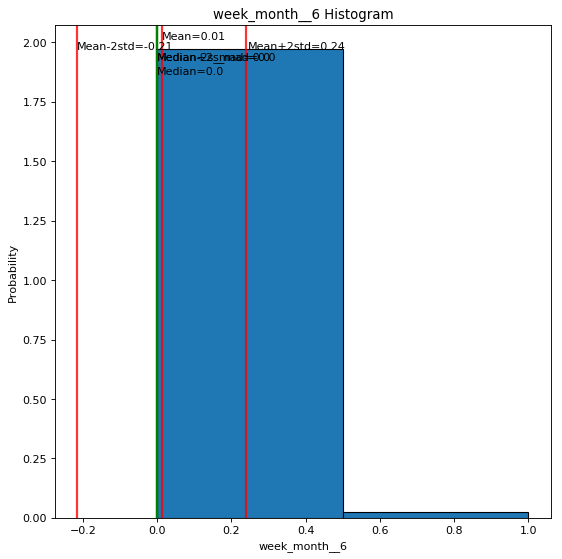

In [255]:
%%skip $skip_feature_analysis
save_graphs = False   #If set true, then all images are saved into the image save directory.

# Print graphs for all features
print_characteristics(features_raw, save_graphs=save_graphs)

Column 1dTrend is a numerical value
Number of unique features 2 
Number of bins <= 100:  2
n=7687, q25=0.00, q75=0.00, min=0.00, max=1.00, interval length=0.00. Number of intervals=2
Feature characteristics for 1dTrend:
Min value =  0
Max value =  1
Mean =  0.15
Median = 0.0
Standard deviation = 0.3549
Skew = 1.9854
kurtosis = 1.9422


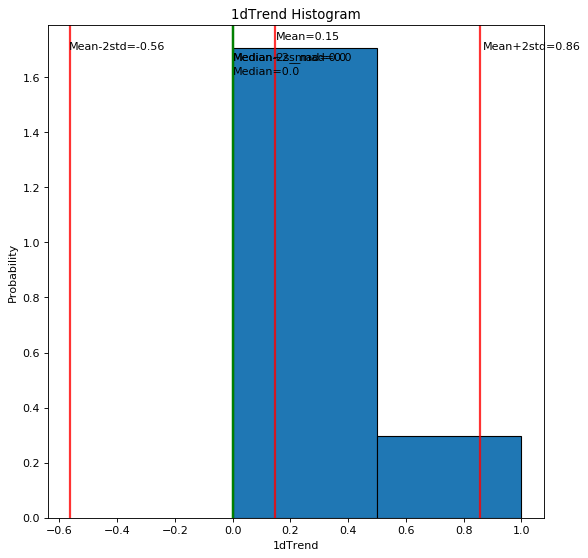

Column 5dTrend is a numerical value
Number of unique features 3 
Number of bins <= 100:  3
n=7687, q25=0.00, q75=0.00, min=0.00, max=2.00, interval length=0.00. Number of intervals=3
Feature characteristics for 5dTrend:
Min value =  0
Max value =  2
Mean =  0.21
Median = 0.0
Standard deviation = 0.5491
Skew = 2.4831
kurtosis = 4.8339


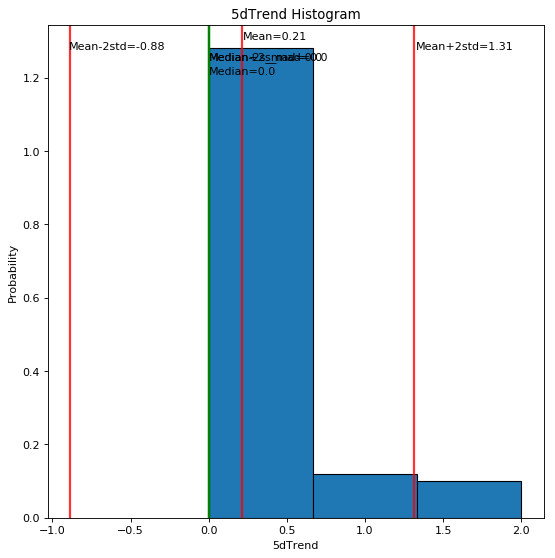

Column 20dTrend is a numerical value
Number of unique features 2 
Number of bins = number of features {}:  2
n=7687, q25=0.00, q75=1.00, min=0.00, max=1.00, interval length=0.10. Number of intervals=2
Feature characteristics for 20dTrend:
Min value =  0
Max value =  1
Mean =  0.59
Median = 1.0
Standard deviation = 0.4927
Skew = -0.3473
kurtosis = -1.8799


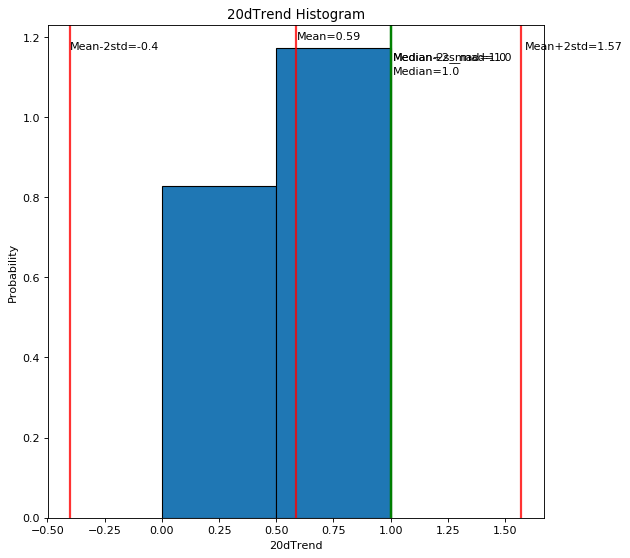

Column LongTrend is a numerical value
Number of unique features 2 
Number of bins = number of features {}:  2
n=7687, q25=0.00, q75=1.00, min=0.00, max=1.00, interval length=0.10. Number of intervals=2
Feature characteristics for LongTrend:
Min value =  0
Max value =  1
Mean =  0.67
Median = 1.0
Standard deviation = 0.4703
Skew = -0.7224
kurtosis = -1.4785


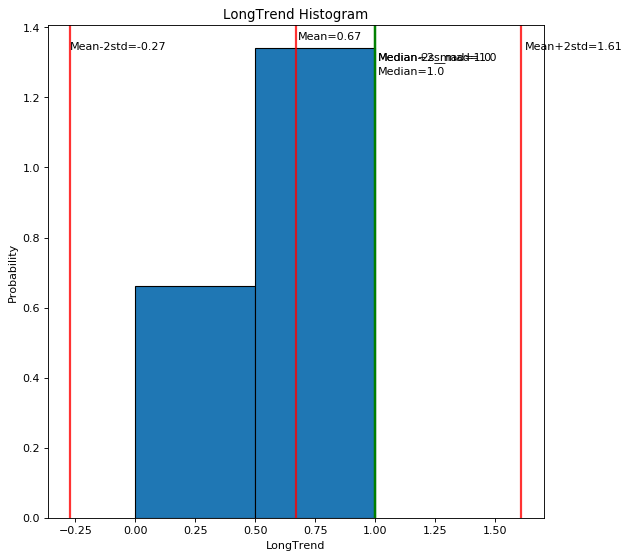

In [256]:
%%skip $skip_feature_analysis
save_graphs = False   #If set true, then all images are saved into the image save directory.

# Print graphs for all features
print_characteristics(outcomes_raw, save_graphs=save_graphs)

In [257]:
#Optional Visualize all numeric values as melted
#melted = pd.melt(df, id_vars=[class_Name], value_name="MergedValues")
#melted['MergedValues'].describe()

#%matplotlib inline
#plt.figure(figsize=(12, 4))
#plt.hist(melted['MergedValues'], bins=list(range(0, 500)), log=True)
#plt.xlabel('Value')
#plt.ylabel('Count (log)')
#plt.title("Histogram of Features")
#plt.show()

In [258]:
#Visualize only the class to see if it is skewed
#vis.paintBarChartForCategorical(df[class_Name].value_counts().index, df[class_Name].value_counts())

## Prepare the Feature Columns

In [259]:
#=== Replace signs for missing values or other values with ===#
features = features_raw.copy()

#Custom replacements, replace only if there is something to replace, else it makes NAN of it
#value_replacements = {
#    'n': 0,
#    'y': 1,
#    'unknown': np.NAN
#}

#=== Replace all custom values and missing values with content from the value_replacement
for col in features.columns:
    #df_dig[col] = df[col].map(value_replacements)
    #df_dig[col] = df[col].replace('?', np.nan)
    
    #Everything to numeric
    features[col] = pd.to_numeric(features[col])
    #df_dig[col] = np.int64(df_dig[col])
    
display(features.head(5))

MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.000887  0.005474  0.006129  0.007285  0.002936 -0.000072  0.001049   
401 -0.000501  0.000770  0.004823  0.005799  0.003158  0.000472 -0.001806   
402  0.004116  0.004845  0.011318  0.011539  0.012066  0.009370  0.006001   
403  0.000466  0.004928  0.009813  0.011324  0.012705  0.010773  0.007302   
404 -0.004963 -0.004325 -0.002414  0.000777  0.002350  0.001898 -0.001364   

     MA20Norm  MA22Norm  MA34Norm      ...        month_year__9  \
id                                     ...                        
400  0.004271  0.005723 -0.000678      ...                    0   
401  0.001748  0.004173 -0.001803      ...                    0   
402  0.007862  0.010850  0.006276      ...                    0   
403  0.006661  0.009984  0.006794      ...                    0   
404 -0.003247 -0.001553 -0.003386      ...                    0   

     month_year__10  month_year__11  month_year__12  week_month__1  \
id                                                                   
400               0               0               0              0   
401               0               0               0              0   
402               0               0               0              0   
403               0               0               0              0   
404               0               0               0              0   

     week_month__2  week_month__3  week_month__4  week_month__5  week_month__6  
id                                                                              
400              0              1              0              0              0  
401              0              1              0              0              0  
402              0              1              0              0              0  
403              0              1              0              0              0  
404              0              0              1              0              0  

[5 rows x 116 columns]

In [260]:
#Create one-hot-encoding for certain classes and replace the original class
#onehotlabels = pd.get_dummies(df_dig.iloc[:,1])

#Add one-hot-encondig columns to the dataset
#for i, name in enumerate(onehotlabels.columns):
#    df_dig.insert(i+1, column='Cylinder' + str(name), value=onehotlabels.loc[:,name])

#Remove the original columns
#df_dig.drop(columns=['cylinders'], inplace=True)

In [261]:
# Replace classes with digital values
outcomes = outcomes_raw.copy()
outcomes = outcomes.astype(int)
print("Outcome types")
print(outcomes.dtypes)

Outcome types
1dTrend      int32
5dTrend      int32
20dTrend     int32
LongTrend    int32
dtype: object


In [262]:
y = outcomes[class_name].values.flatten()
#y_labels = class_labels
#class_labels_inverse = sup.inverse_dict(class_labels)

print("y shape: {}".format(y.shape))
print("y labels: {}".format(class_labels))
print("y unique classes: {}".format(np.unique(y, axis=0)))

y shape: (7687,)
y labels: {0: 'neutral', 1: 'positive', 2: 'negative'}
y unique classes: [0 1]


## Determine Missing Data
Missing data is only visualized here as it is handled in the training algorithm in S40.

In [263]:
# Check if there are any nulls in the data
print("Missing data in the features: ", features.isnull().values.sum())
features[features.isna().any(axis=1)]

Missing data in the features:  0


Empty DataFrame
Columns: [MA2Norm, MA5Norm, MA8Norm, MA10Norm, MA13Norm, MA15Norm, MA18Norm, MA20Norm, MA22Norm, MA34Norm, MA40Norm, MA50Norm, MA75Norm, MA100Norm, MA125Norm, MA150Norm, MA175Norm, MA200Norm, MA225Norm, MA250Norm, MA275Norm, MA300Norm, MA325Norm, MA350Norm, MA375Norm, MA400Norm, MA2NormDiff, MA5NormDiff, MA8NormDiff, MA10NormDiff, MA13NormDiff, MA15NormDiff, MA18NormDiff, MA20NormDiff, MA22NormDiff, MA34NormDiff, MA40NormDiff, MA50NormDiff, MA75NormDiff, MA100NormDiff, MA125NormDiff, MA150NormDiff, MA175NormDiff, MA200NormDiff, MA225NormDiff, MA250NormDiff, MA275NormDiff, MA300NormDiff, MA325NormDiff, MA350NormDiff, MA375NormDiff, MA400NormDiff, RSI2, RSI3, RSI5, RSI9, RSI10, RSI14, RSI20, RSI25, RSI2_diff, RSI3_diff, RSI5_diff, RSI9_diff, RSI10_diff, RSI14_diff, RSI20_diff, RSI25_diff, Stoch_Sk1383, Stoch_Sd1383, Stoch_Sk533, Stoch_Sd533, Stoch_Sk2177, Stoch_Sd2177, Stoch_Sk211414, Stoch_Sd211414, MACD12_26_9, MACDsig12_26_9, MACD5_35_5, MACDsig5_35_5, MACD12_26_9Diff, MACDsig12_26_9Diff, MACD5_35_5Diff, MACDsig5_35_5Diff, MACD12_26_9DiffDirChange, MACDsig12_26_9DiffDirChange, MACD5_35_5DiffDirChange, MACDsig5_35_5DiffDirChange, week_of_year, day_of_year, day_of_month, day_week__0, day_week__1, day_week__2, day_week__3, day_week__4, day_week__5, day_week__6, month_year__1, month_year__2, ...]
Index: []

[0 rows x 116 columns]

Number of missing values per feature


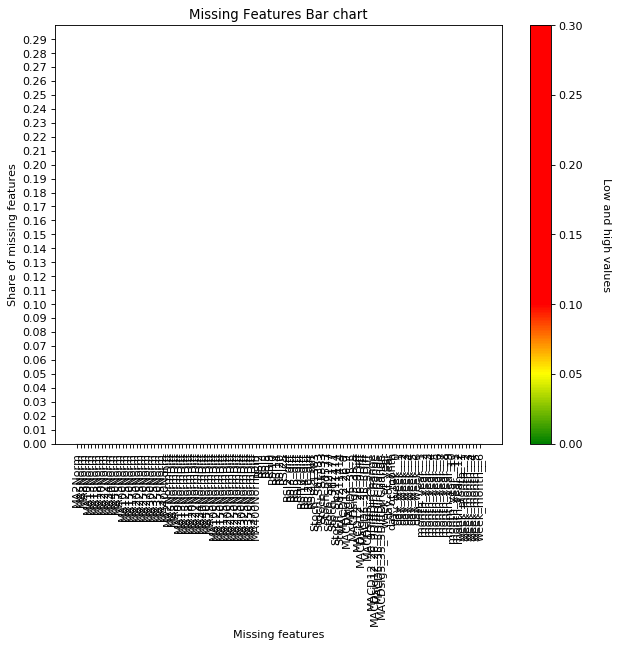

In [264]:
#Missing data part
print("Number of missing values per feature")
missingValueShare = []
for col in features.columns:
    #if is_string_dtype(df_dig[col]):
    missingValueShare.append(sum(features[col].isna())/numSamples)

#Print missing value graph
vis.paintBarChartForMissingValues(features.columns, missingValueShare)

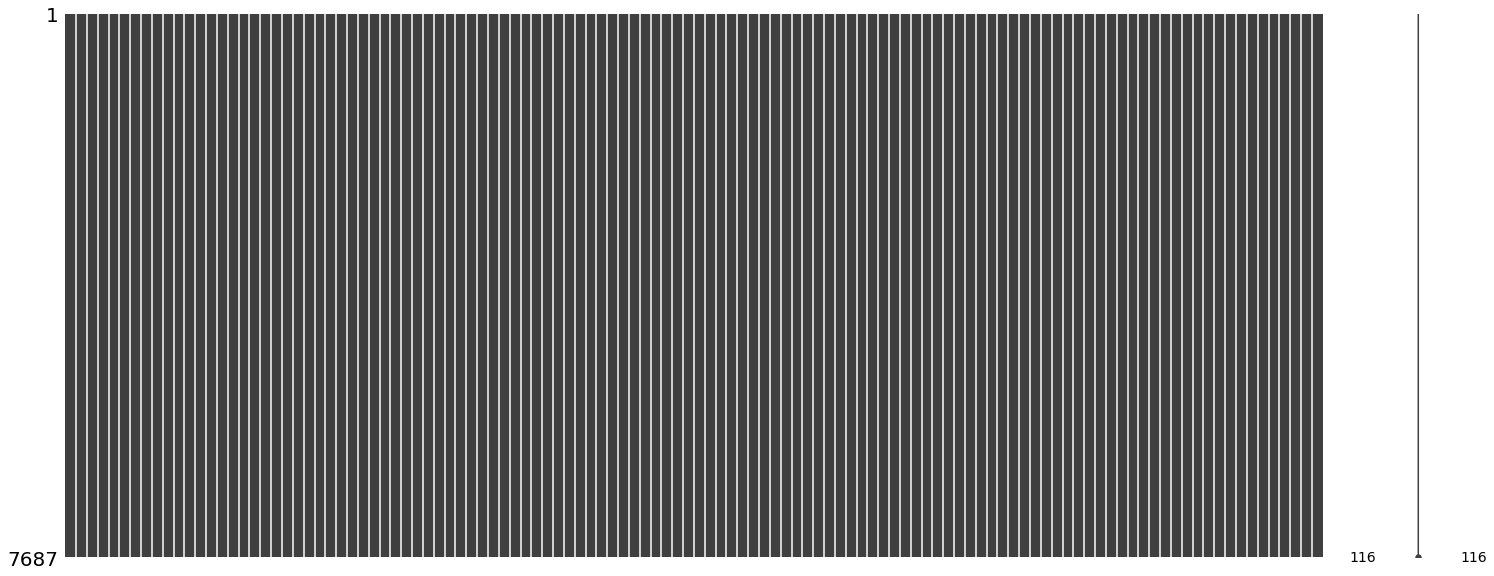

In [265]:
#Visualize missing data with missingno
import missingno as msno
%matplotlib inline
msno.matrix(features)

In [266]:
if features.isnull().values.sum()>0:
    msno.heatmap(features)

#### View Prepared Binary Features

We need some more plots for the binary data types.

In [267]:
#vis.plotBinaryValues(df_dig, df_dig.columns) #0:-1
#plt.savefig(image_save_directory + "/BinaryFeatures.png", dpi=70)

## Feature Visualization

### Auto Correlations of Time Dependent Variables

Source: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

#### Autoregression Intuition

Consider a time series that was generated by an autoregression (AR) process with a lag of k. We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened. We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k. This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

#### Moving Average Intuition

Consider a time series that was generated by a moving average (MA) process with a lag of k. Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated. For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards. Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

if the autocorrelation function has a very long tail, then it is no stationary process

Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.


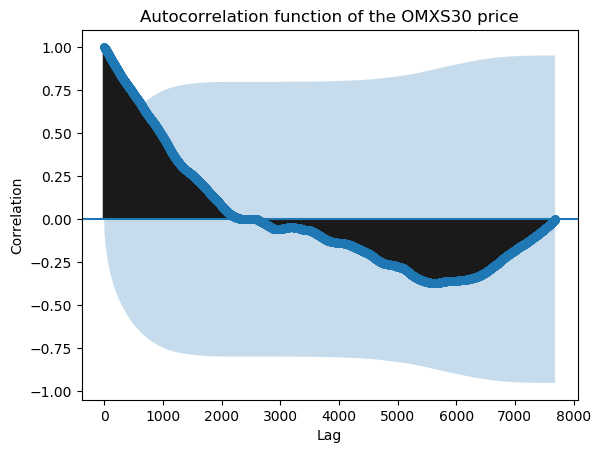

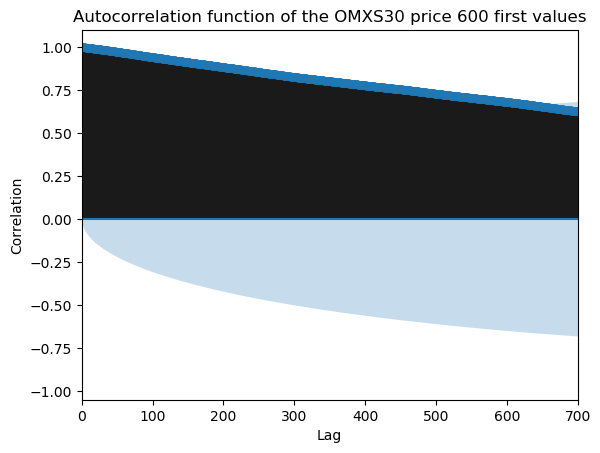

Ljung-Box statistics: p-value= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
If p values > 0.05 then there are significant autocorrelations.


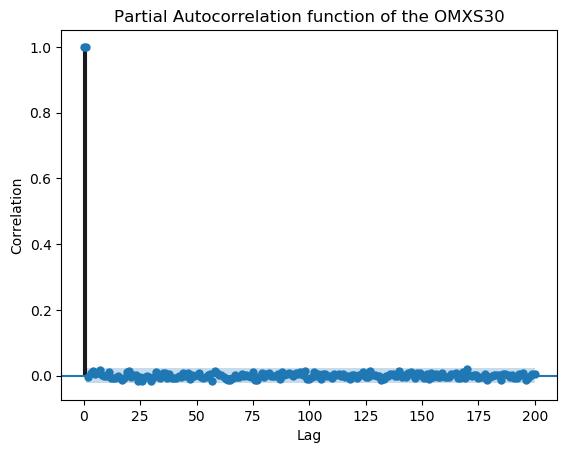

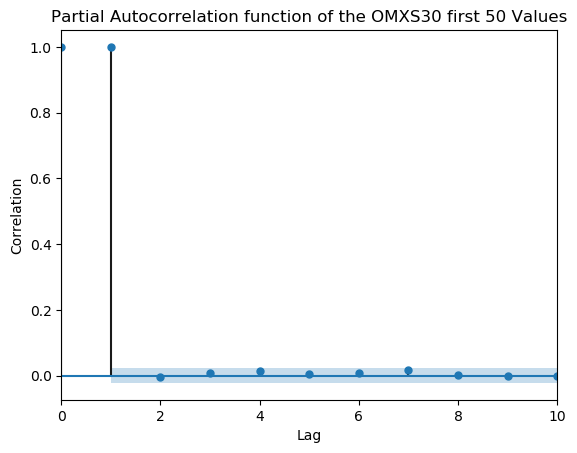

In [268]:
%%skip $skip_feature_analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

m.rc_file_defaults() #Reset sns

#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")
plot_acf(np.log(df_timegraph['Close']))
plt.title("Autocorrelation function of the OMXS30 price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

plot_acf(np.log(df_timegraph['Close']))
plt.title("Autocorrelation function of the OMXS30 price 600 first values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,700])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(np.log(df_timegraph['Close']), lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

plot_pacf(np.log(df_timegraph['Close']), lags=200)
plt.title("Partial Autocorrelation function of the OMXS30")
plt.xlabel("Lag")
plt.ylabel("Correlation")
#plt.xlim([0,700])
plt.show()

plot_pacf(np.log(df_timegraph['Close']), lags=50)
plt.title("Partial Autocorrelation function of the OMXS30 first 50 Values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,10])
plt.show()

Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.


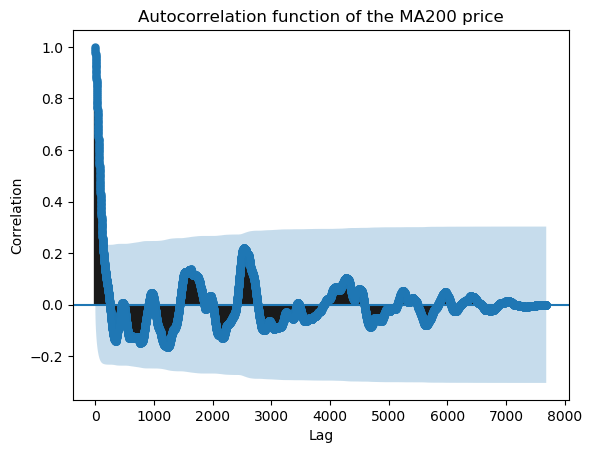

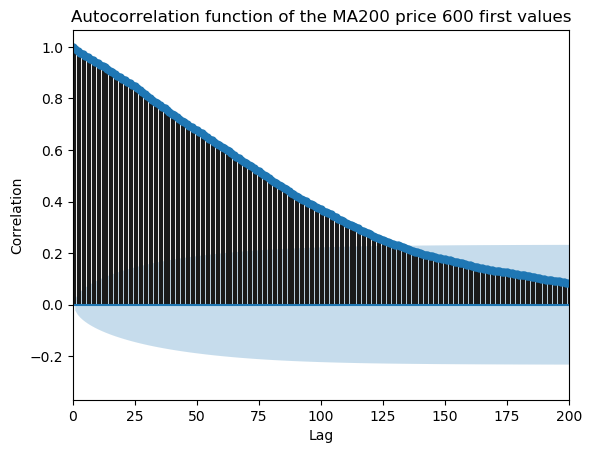

Ljung-Box statistics: p-value= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
If p values > 0.05 then there are significant autocorrelations.


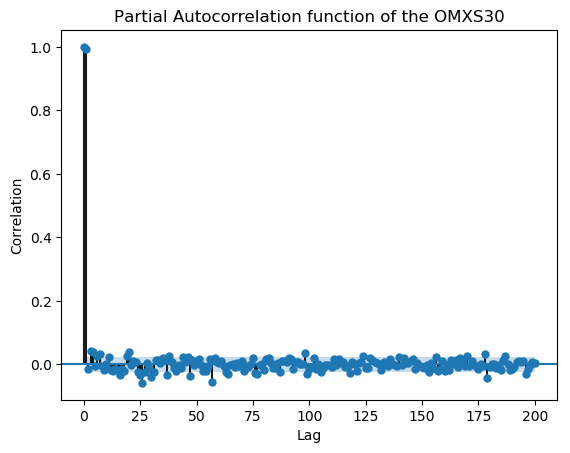

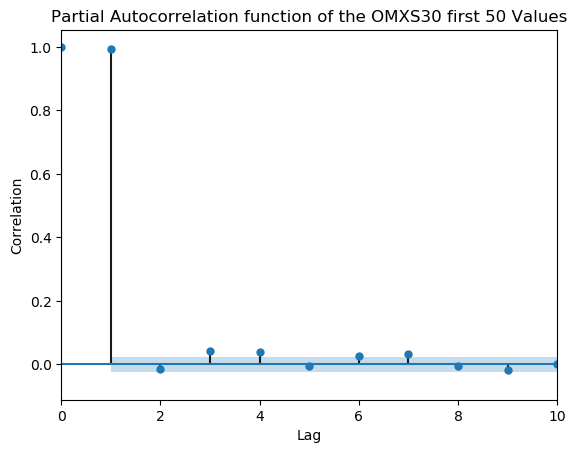

In [269]:
%%skip $skip_feature_analysis
#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")
plot_acf(df.MA200Norm)
plt.title("Autocorrelation function of the MA200 price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

plot_acf(df.MA200Norm)
plt.title("Autocorrelation function of the MA200 price 600 first values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,200])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(df.MA200Norm, lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

plot_pacf(df.MA200Norm, lags=200)
plt.title("Partial Autocorrelation function of the OMXS30")
plt.xlabel("Lag")
plt.ylabel("Correlation")
#plt.xlim([0,700])
plt.show()

plot_pacf(df.MA200Norm, lags=50)
plt.title("Partial Autocorrelation function of the OMXS30 first 50 Values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,10])
plt.show()

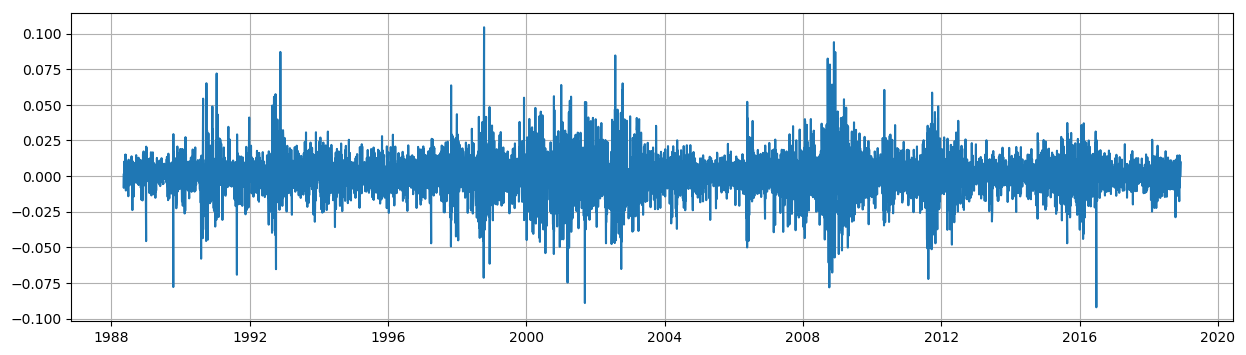

In [270]:
%%skip $skip_feature_analysis
#Plot difference between time values to see if the differences are stationary
diff = pd.DataFrame(data=np.divide(df_timegraph['Close'] - df_timegraph['Close'].shift(1), df_timegraph['Close'])).set_index(df_timegraph['Time'])
diff=diff.iloc[1:,:]
fig = plt.figure(figsize= (15, 4))
plt.plot(df_timegraph['Time'].iloc[1:], diff)
plt.grid()

Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.


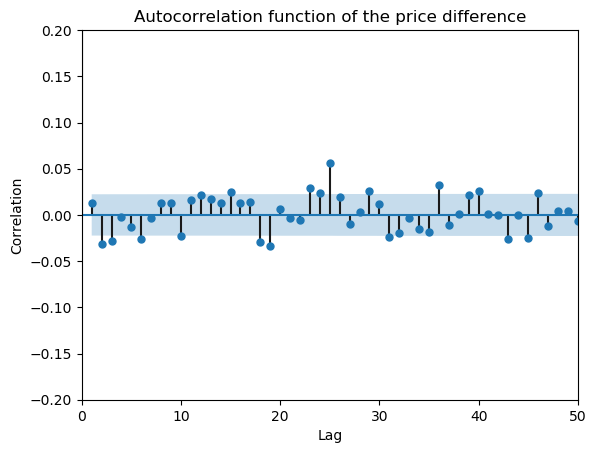

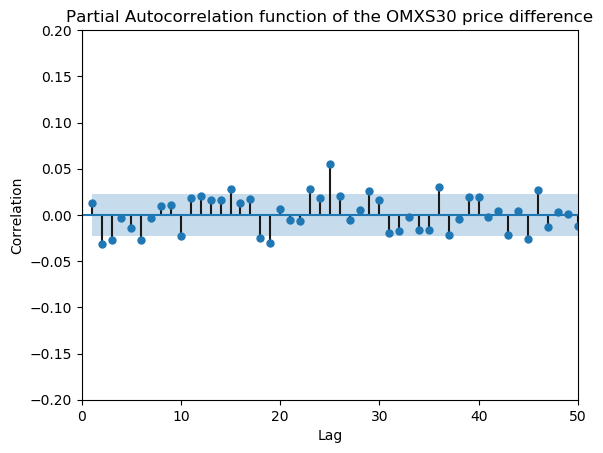

Ljung-Box statistics: p-value= [0.249 0.012 0.002 0.004 0.006 0.001 0.003 0.004 0.004 0.002 0.002 0.001
 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
If p values > 0.05 then there are significant autocorrelations.


In [271]:
%%skip $skip_feature_analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")

plot_acf(diff)
plt.title("Autocorrelation function of the price difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.ylim([-0.2, 0.2])
plt.xlim([0,50])
plt.show()

plot_pacf(diff, lags=100)
plt.title("Partial Autocorrelation function of the OMXS30 price difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,50])
plt.ylim([-0.2, 0.2])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(diff, lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

# Feature Visualization
Here, feature selection and visulization of datasets is performed
Methods
- Feature visualization through t-SNE
- Feature visualization and analysis through PCA

### Standardize Data for Feature Selection and Visualization
Z-Normalize the data around zero and divided by standard deviation. Fit the normalizer on the training data and transform the training and the test data. The reason is that the scaler only must depend on the training data, in order to prevent leakage of information from the test data.

In [272]:
from sklearn import preprocessing

#=== Select the best type of scaler ===#
scaler = preprocessing.StandardScaler() #Because normal distribution. Don't use minmax scaler for PCA or unsupervised learning
# as the axis shall be centered and not shifted.


scaler.fit(features)
#Use this scaler also for the test data at the end
X_scaled = pd.DataFrame(data=scaler.transform(features), index = features.index, columns=features.columns)
print("Unscaled values")
display(features.iloc[0:2,:])
print("Scaled values")
display(X_scaled.iloc[0:2,:])

scaler.fit(y.reshape(-1, 1))
y_scaled = pd.DataFrame(data=scaler.transform(y.reshape(-1, 1)), index = features.index, columns=[class_name])
print("Unscaled values")
display(y[0:10])
print("Scaled values")
display(y_scaled.iloc[0:10,:])

Unscaled values


MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.000887  0.005474  0.006129  0.007285  0.002936 -0.000072  0.001049   
401 -0.000501  0.000770  0.004823  0.005799  0.003158  0.000472 -0.001806   

     MA20Norm  MA22Norm  MA34Norm      ...        month_year__9  \
id                                     ...                        
400  0.004271  0.005723 -0.000678      ...                    0   
401  0.001748  0.004173 -0.001803      ...                    0   

     month_year__10  month_year__11  month_year__12  week_month__1  \
id                                                                   
400               0               0               0              0   
401               0               0               0              0   

     week_month__2  week_month__3  week_month__4  week_month__5  week_month__6  
id                                                                              
400              0              1              0              0              0  
401              0              1              0              0              0  

[2 rows x 116 columns]

Scaled values


MA2Norm   MA5Norm   MA8Norm  MA10Norm  MA13Norm  MA15Norm  MA18Norm  \
id                                                                          
400 -0.110102  0.384970  0.339131  0.360534  0.162219  0.053125  0.094432   
401 -0.055313  0.078908  0.275052  0.295959  0.170615  0.072180  0.004058   

     MA20Norm  MA22Norm  MA34Norm      ...        month_year__9  \
id                                     ...                        
400  0.191692  0.229058  0.067034      ...            -0.307231   
401  0.116492  0.185279  0.042242      ...            -0.307231   

     month_year__10  month_year__11  month_year__12  week_month__1  \
id                                                                   
400       -0.313027       -0.307991        -0.28594      -0.323684   
401       -0.313027       -0.307991        -0.28594      -0.323684   

     week_month__2  week_month__3  week_month__4  week_month__5  week_month__6  
id                                                                              
400      -0.548741       1.803888      -0.544727      -0.494832      -0.115386  
401      -0.548741       1.803888      -0.544727      -0.494832      -0.115386  

[2 rows x 116 columns]

Unscaled values


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Scaled values


LongTrend
id            
400   0.702076
401   0.702076
402   0.702076
403   0.702076
404   0.702076
405   0.702076
406   0.702076
407   0.702076
408   0.702076
409   0.702076

### Feature and Outcomes Correlation Matrix

In [273]:
total_values = X_scaled.join(y_scaled)
print("Merged features and outcomes to use in correlation matrix")

Merged features and outcomes to use in correlation matrix


In [274]:
#Select column values to use in the correlation plot
feature_plot=list(range(0,10,1))
#Select outcomes to show
feature_plot.extend([-4, -3, -2, -1])

print(feature_plot)
print(total_values.columns[feature_plot])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -4, -3, -2, -1]
Index(['MA2Norm', 'MA5Norm', 'MA8Norm', 'MA10Norm', 'MA13Norm', 'MA15Norm',
       'MA18Norm', 'MA20Norm', 'MA22Norm', 'MA34Norm', 'week_month__4',
       'week_month__5', 'week_month__6', 'LongTrend'],
      dtype='object')


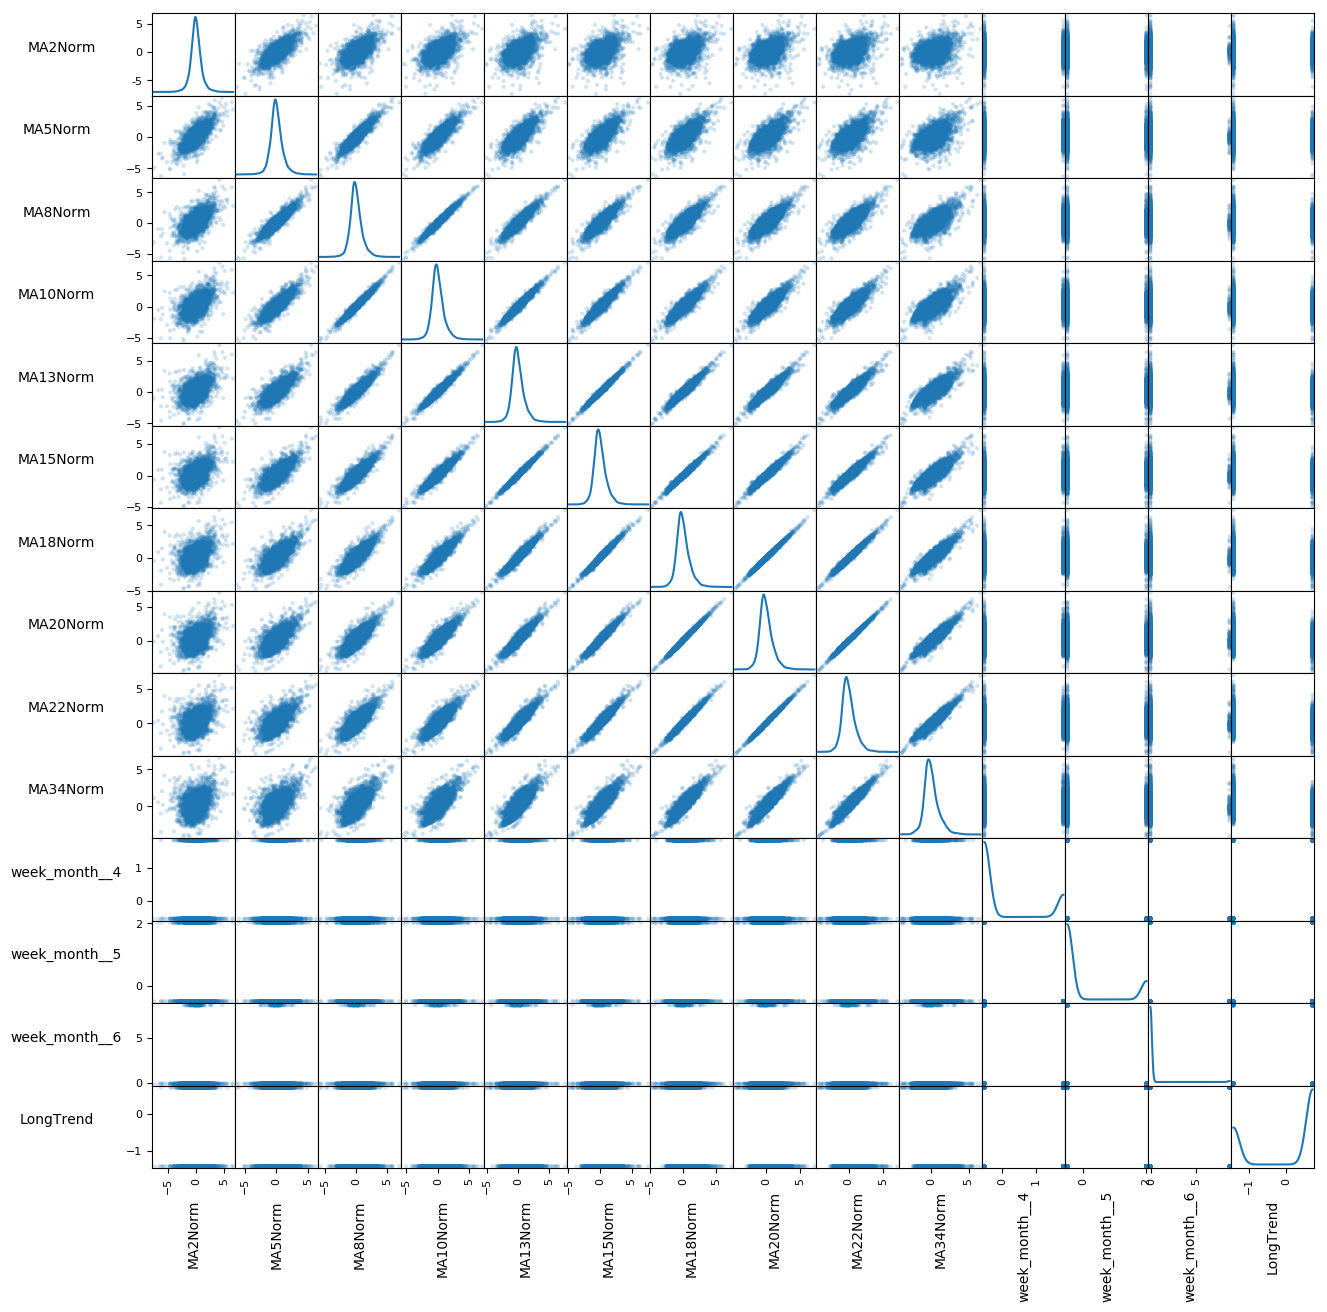

In [275]:
%%skip $skip_feature_analysis
#http://benalexkeen.com/correlation-in-python/
#https://stackoverflow.com/questions/26975089/making-the-labels-of-the-scatterplot-vertical-and-horizontal-in-pandas
from matplotlib.artist import setp

m.rc_file_defaults() #Reset sns

axs = pd.plotting.scatter_matrix(total_values.iloc[:,feature_plot], figsize=(15, 15), alpha=0.2, diagonal='kde')
n = len(df.iloc[:,feature_plot].columns)
for i in range(n):
    for j in range(n):
        # to get the axis of subplots
        ax = axs[i, j]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50
#plt.yticks(rotation=90)
plt.show()

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


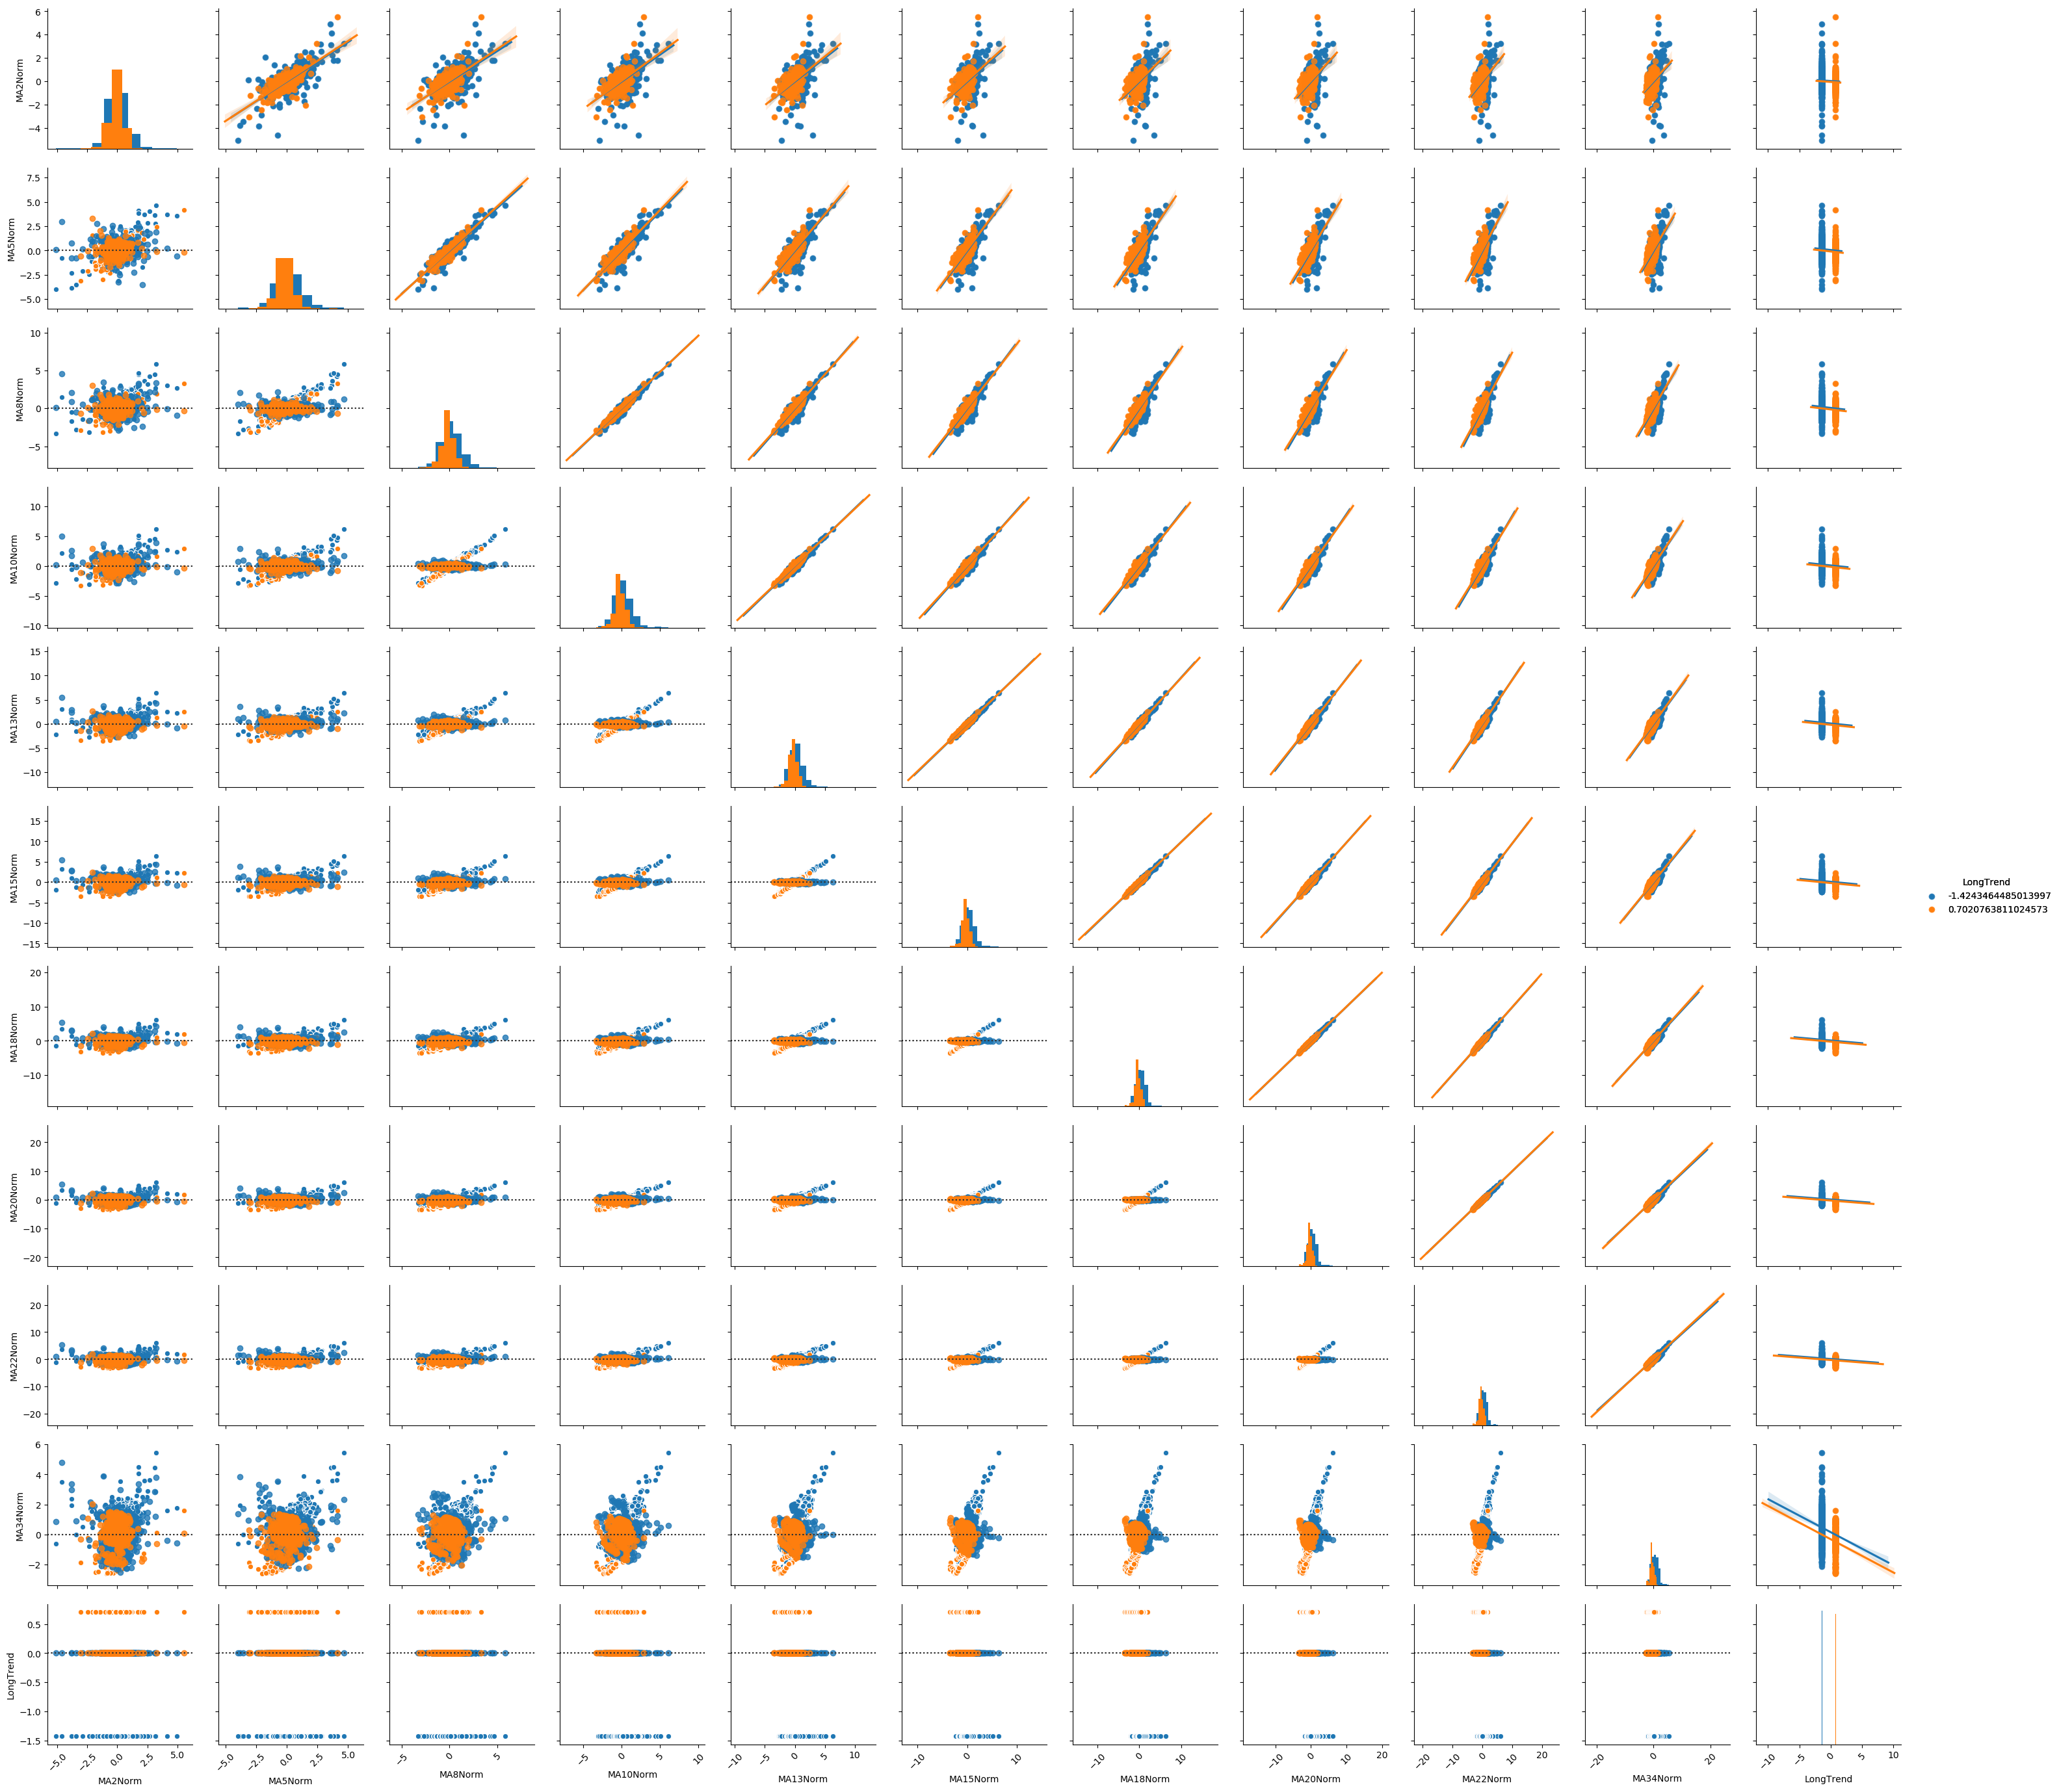

In [276]:
%%skip $skip_feature_analysis
import seaborn as sns

# https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6

feature_plot=list(range(0,10,1))
feature_plot.extend([-1])

g = sns.pairplot(total_values.iloc[0:1000,feature_plot], hue=class_name, diag_kind="hist")
#total_values.columns[-1]
g.map_upper(sns.regplot) 
g.map_lower(sns.residplot) 
g.map_diag(plt.hist) 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45) 
g.add_legend() 
g.set(alpha=0.5)

plt.show()

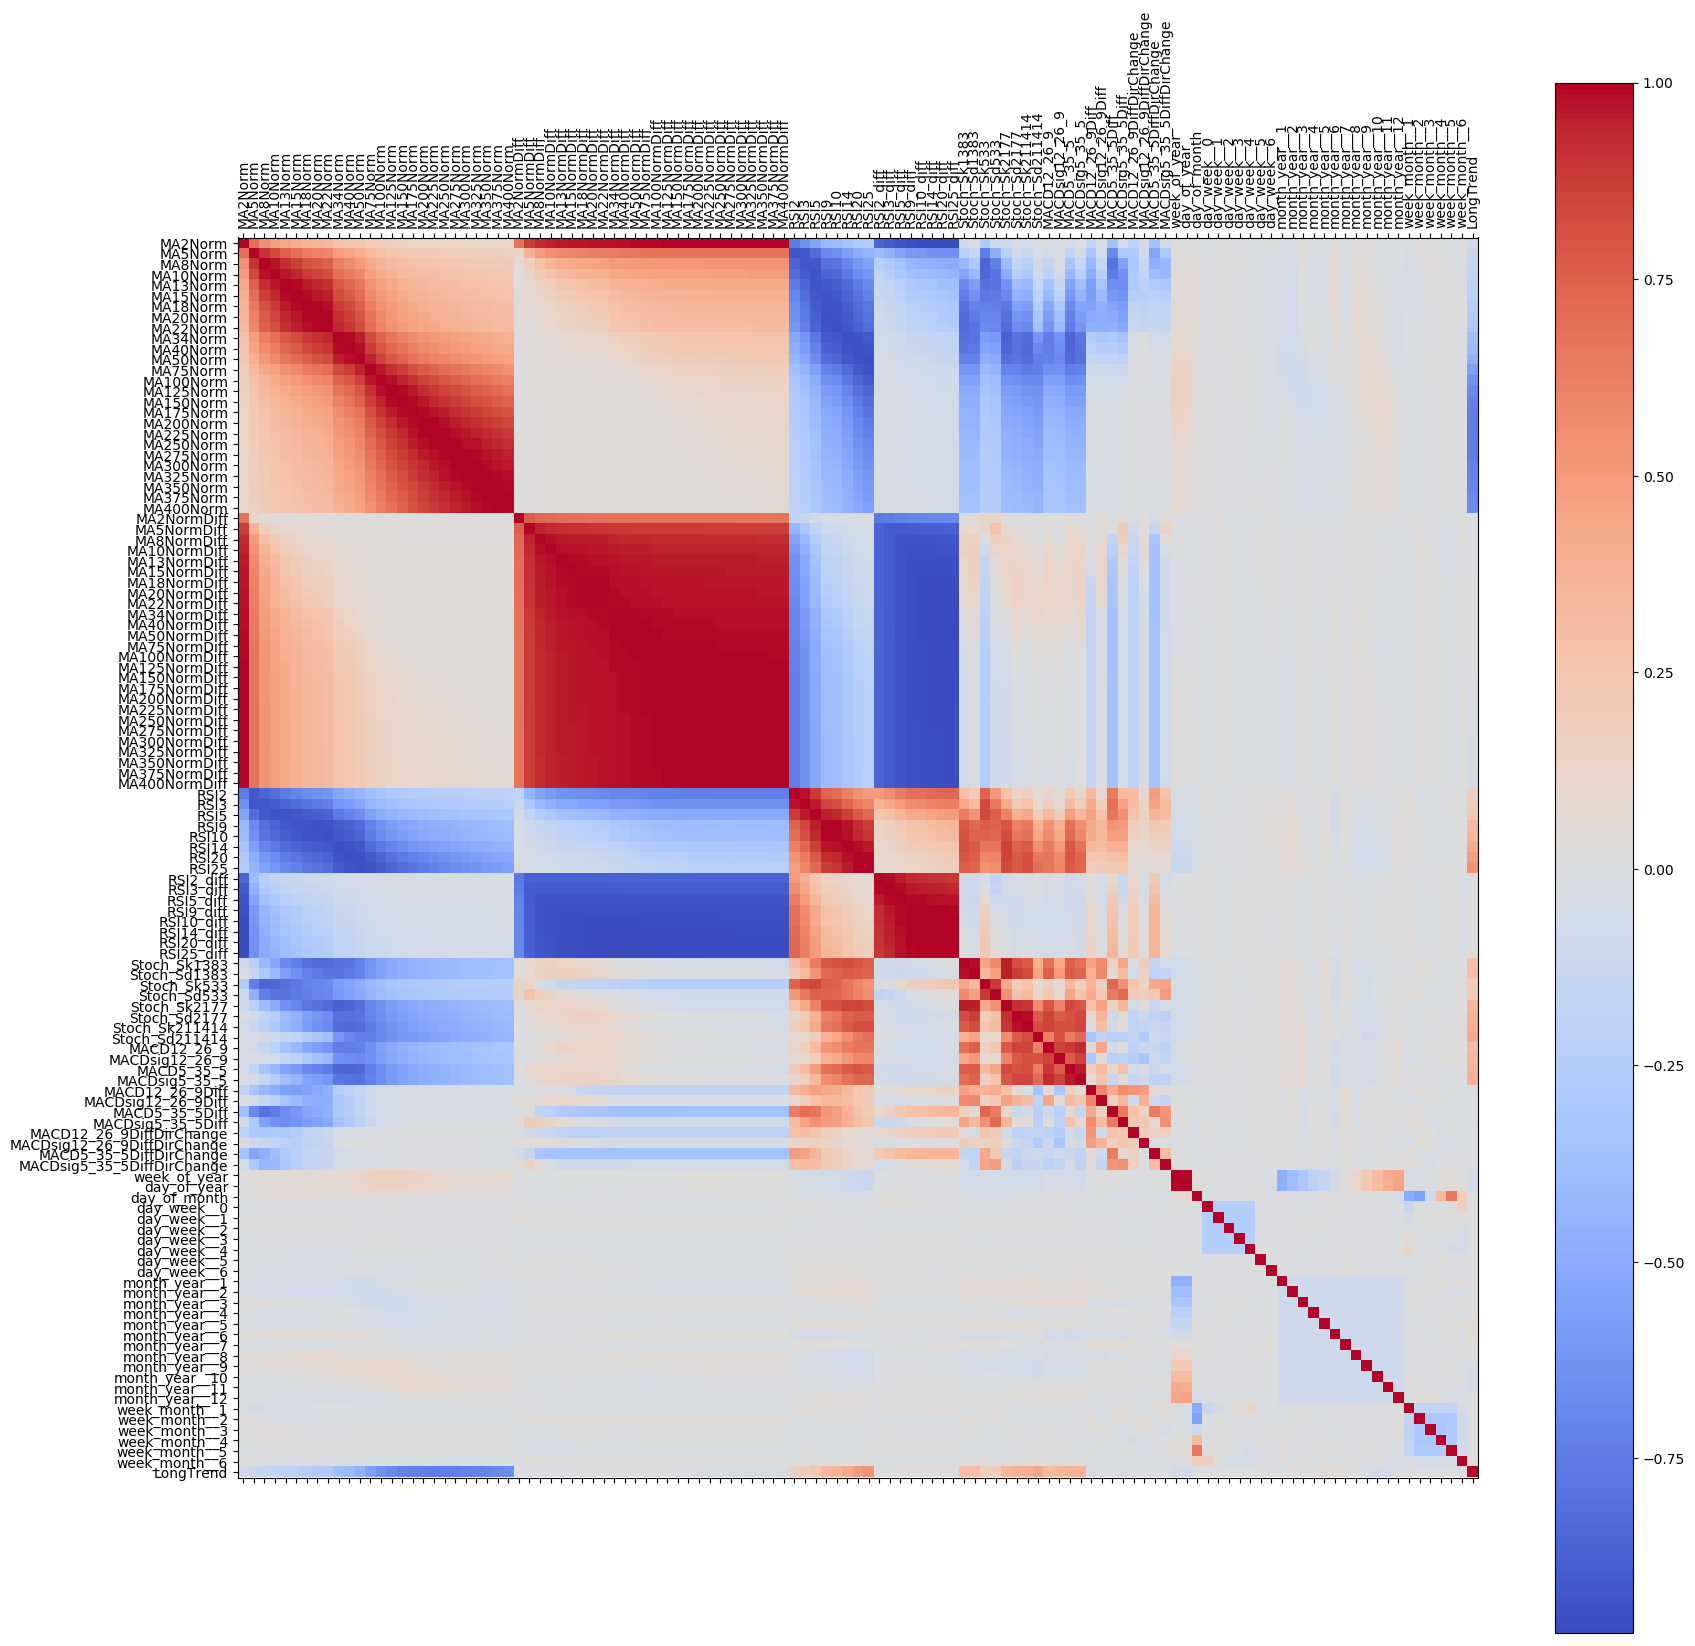

In [277]:
%%skip $skip_feature_analysis
#http://benalexkeen.com/correlation-in-python/
matfig = plt.figure(figsize=(20, 20))
plt.matshow(total_values.corr(method='spearman'), fignum=1, cmap=plt.get_cmap('coolwarm')) #Use spearman correlation instead of pearson to have a robust correlation
plt.xticks(range(len(total_values.columns)), total_values.columns)
plt.yticks(range(len(total_values.columns)), total_values.columns)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

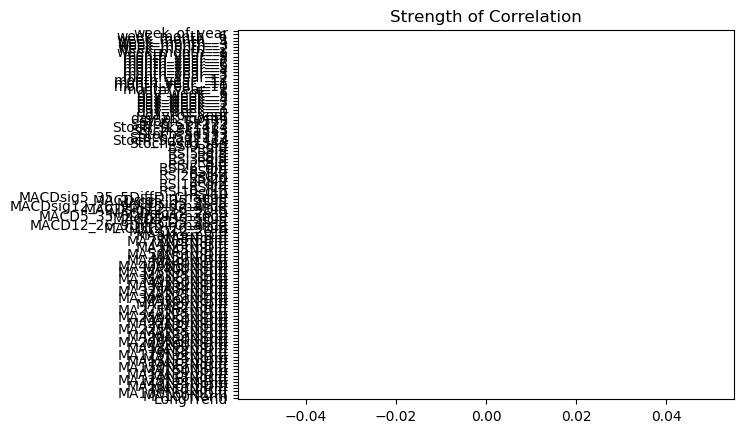

In [278]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

m.rc_file_defaults() #Reset sns

corr = X_scaled.corrwith(y_scaled)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')
#display(corr)

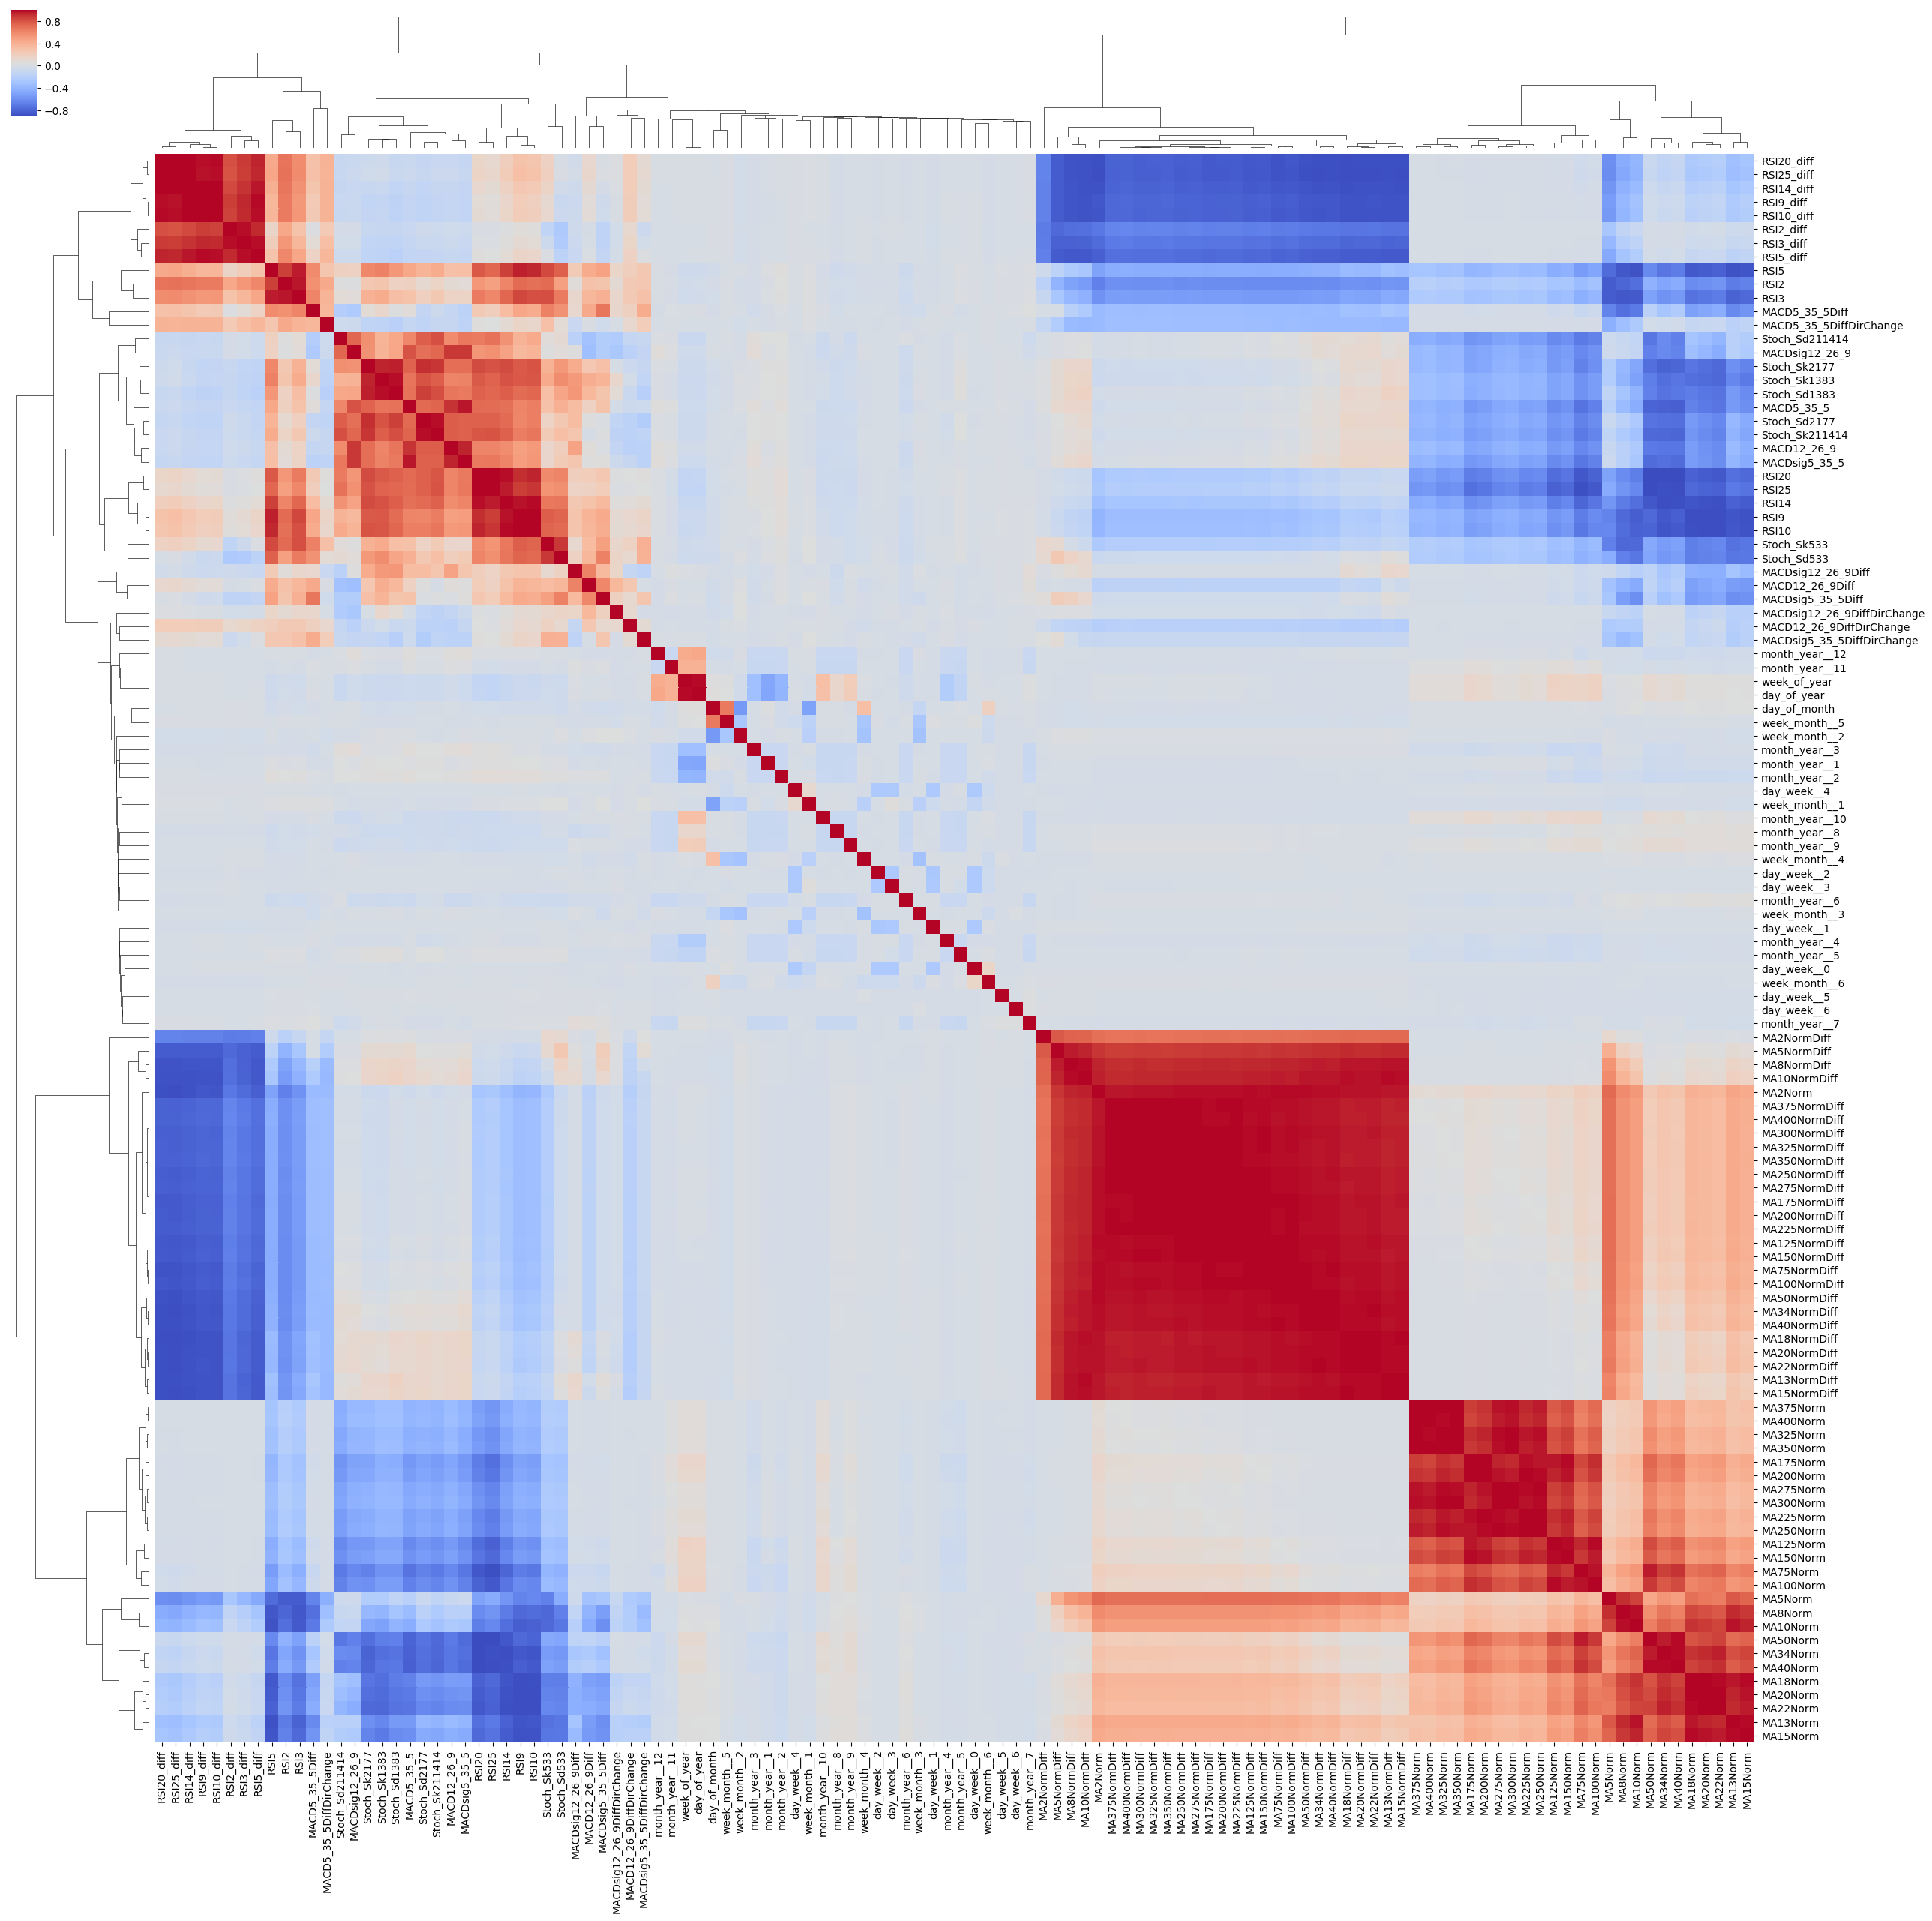

In [279]:
corr_matrix = X_scaled.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage, row_cluster=True,col_cluster=True,figsize=(30,30),cmap=plt.get_cmap('coolwarm'))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

### Feature visualization with Parallel Coordinates

In [280]:
#Select a random subset to visualize
import random

total_values = features.join(outcomes)
print("Merged features and outcomes to use in correlation matrix")

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, features)

#Select column values to use in the correlation plot
feature_plot=list(range(0,10,1))
#cols = ['MA2Norm', 'MA50Norm', 'MA200Norm', 'MA400Norm', 'MA200NormDiff', 'MA400NormDiff']
cols = total_values.columns[feature_plot]
print(feature_plot)
print(cols)

comparison_name = class_name
print("Class name: ", comparison_name)

df_fv = total_values.iloc[X_train_index_subset, :]

Merged features and outcomes to use in correlation matrix
Cutting the data to  1000
Created a training subset
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Index(['MA2Norm', 'MA5Norm', 'MA8Norm', 'MA10Norm', 'MA13Norm', 'MA15Norm',
       'MA18Norm', 'MA20Norm', 'MA22Norm', 'MA34Norm'],
      dtype='object')
Class name:  LongTrend


In [281]:
%%skip $skip_feature_analysis
# Use parallel coordinates to visualize the classes and all features for plotting
#https://plot.ly/python/parallel-coordinates-plot/
#http://benalexkeen.com/parallel-coordinates-in-matplotlib/
from matplotlib import ticker

def plotParallelCoordinates(df, cols, colours, comparison_name):
    x = [i for i, _ in enumerate(cols)]

    # create dict of categories: colours
    colours = {df[comparison_name].astype('category').cat.categories[i]: colours[i] 
               for i, _ in enumerate(df[comparison_name].astype('category').cat.categories)}

    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for col in cols:
        min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
        df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

    # Plot each row
    for i, ax in enumerate(axes):
        for idx in df.index:
            mpg_category = df.loc[idx, comparison_name]
            ax.plot(x, df.loc[idx, cols], colours[mpg_category])
        ax.set_xlim([x[i], x[i+1]])
    
    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        norm_min = df[cols[dim]].min()
        norm_range = np.ptp(df[cols[dim]])
        norm_step = norm_range / float(ticks-1)
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6)
        ax.set_xticklabels([cols[dim]])
    

    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[-2], cols[-1]])

    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df[comparison_name].astype('category').cat.categories],
        df[comparison_name].astype('category').cat.categories,
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    plt.title("Values of car attributes by LongTrend category")

    plt.show()

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


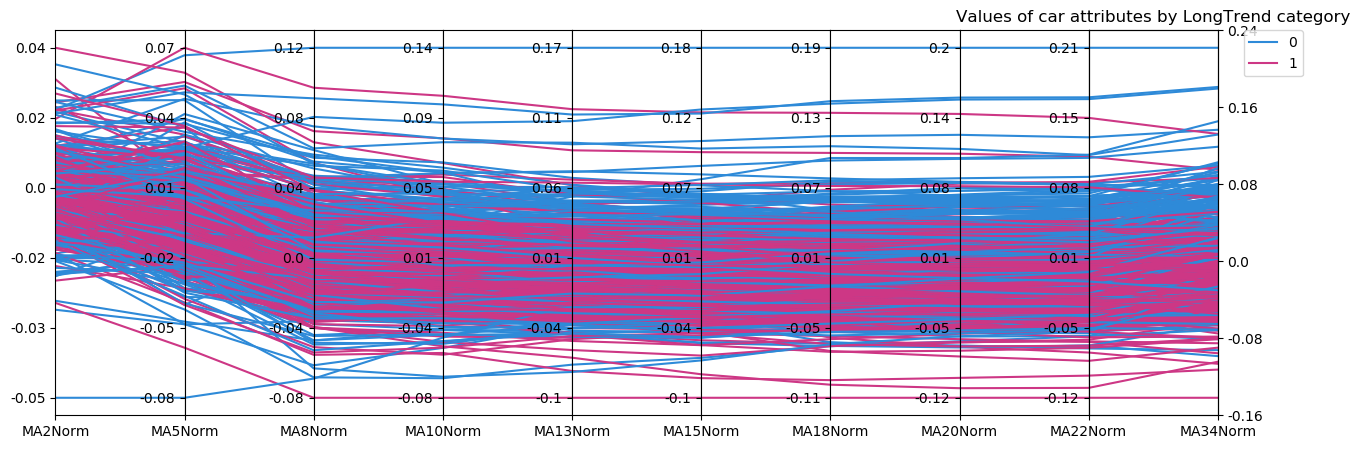

In [282]:
%%skip $skip_feature_analysis
m.rc_file_defaults() #Reset sns

colors = ['#2e8ad8', '#cd3785', '#c64c00', '#889a00']
plotParallelCoordinates(df_fv, cols, colors, comparison_name)

### Visualize Data with t-SNE

In [283]:
%%skip $skip_feature_analysis
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, X_scaled)

Cutting the data to  1000
Created a training subset


In [284]:
%%skip $skip_feature_analysis
from sklearn.manifold import TSNE
#%matplotlib notebook
#%matplotlib inline

np.random.seed(0)
#X_embedded = TSNE(n_components=2, perplexity=5.0, early_exaggeration=12.0, n_iter=5000, 
#                  n_iter_without_progress=1000, learning_rate=10).fit_transform(embedded)
X_embedded = TSNE(n_components=2, perplexity=10.0, early_exaggeration=100.0, n_iter=5000, 
                  n_iter_without_progress=1000, learning_rate=10).fit_transform(X_scaled.iloc[X_train_index_subset,:])

#### Plot t-SNE with best parameters

In [285]:
%matplotlib inline
m.rc_file_defaults() #Reset sns

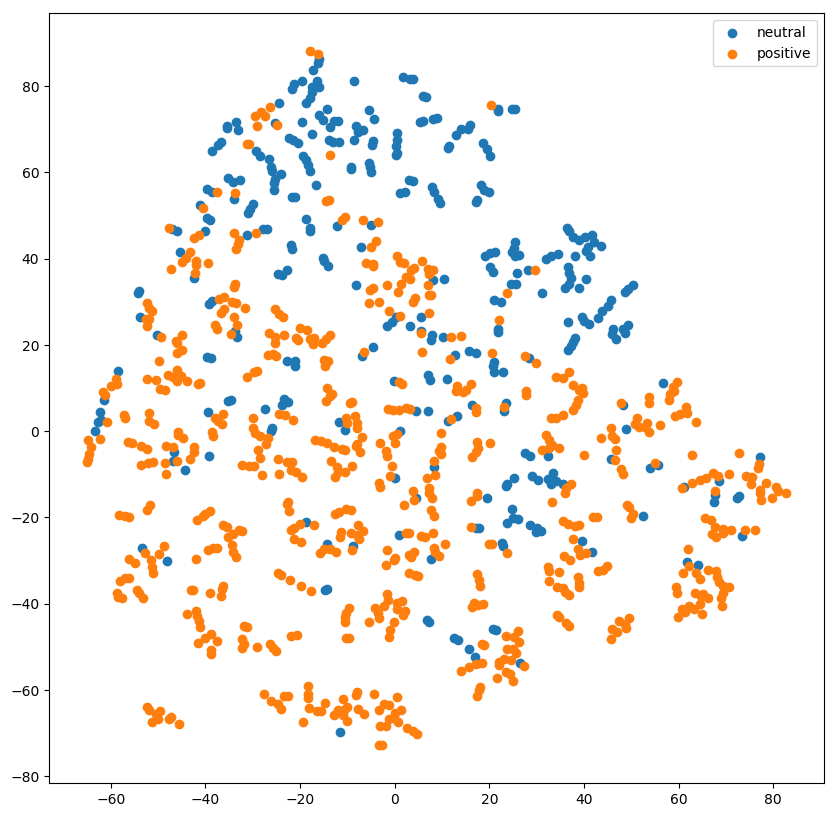

In [286]:
%%skip $skip_feature_analysis
#Plot with texts added to the graphs

#from adjustText import adjust_text
targets = np.array(y[X_train_index_subset]).flatten()

plt.figure(figsize=(10,10))
texts = []
for i, t in enumerate(set(targets)):
    idx = targets == t
    #for x, y in zip(X_embedded[idx, 0], X_embedded[idx, 1]):
        #texts.append(plt.text(x, y, t))
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=class_labels[t])   

#adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5)) 

plt.legend(bbox_to_anchor=(1, 1));

#### t-SNE Parameter Grid Search

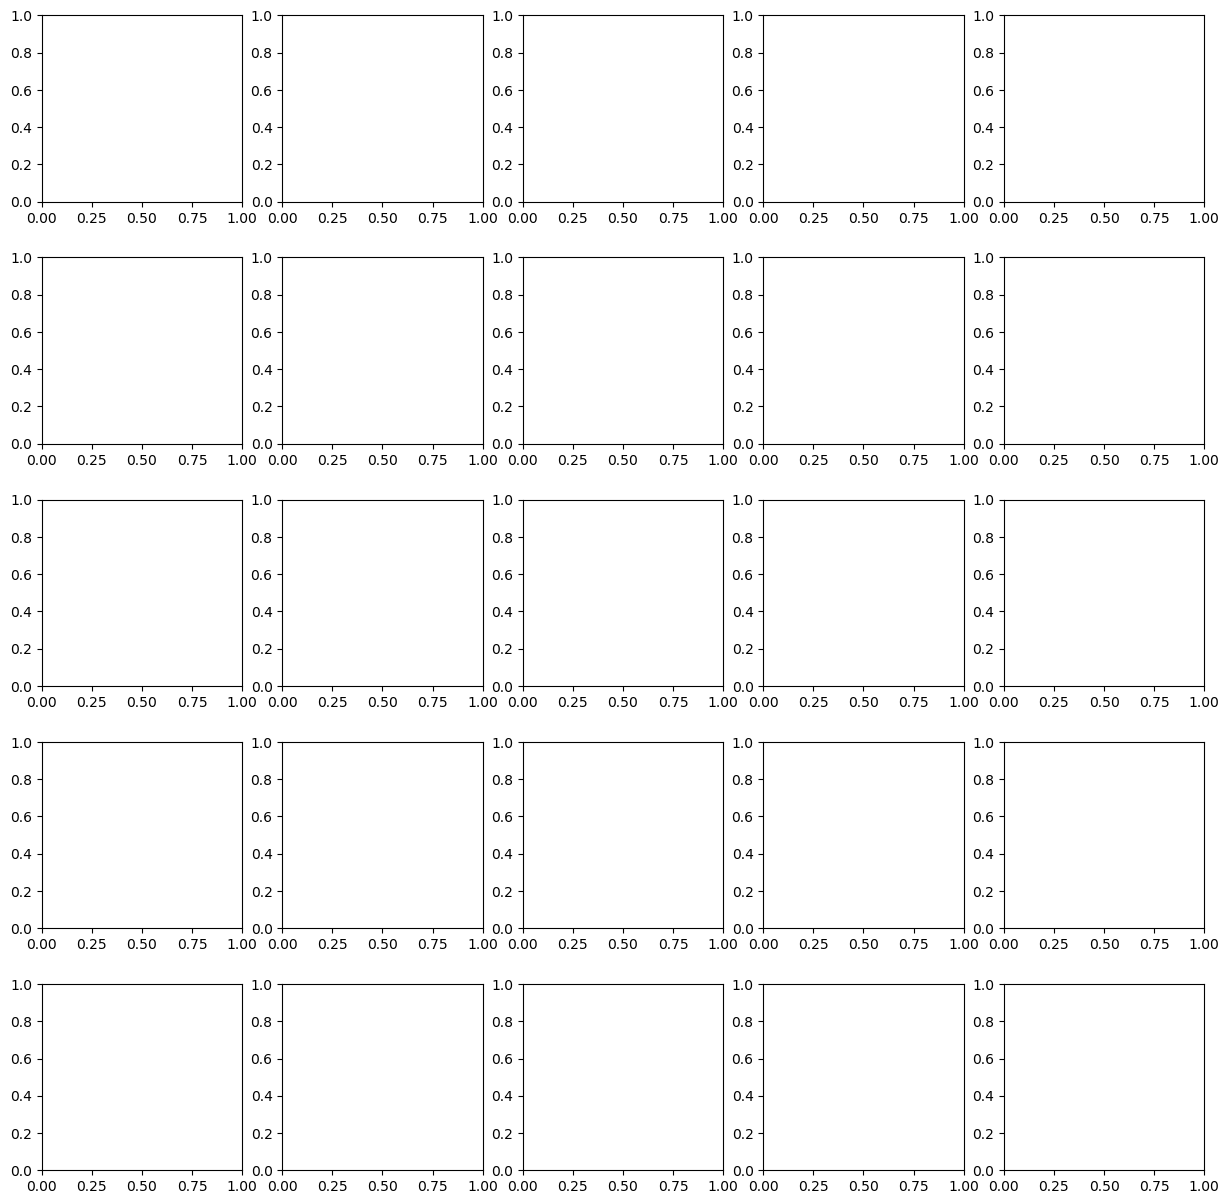

In [287]:
%%skip $skip_feature_analysis
from IPython.display import clear_output

#Optimize t-sne plot
tne_gridsearch = False

#Create a TSNE grid search with two variables
perplex = [5, 10, 30, 50, 100]
exaggregation = [5, 12, 20, 50, 100]
#learning_rate = [10, 50, 200]

fig, axarr = plt.subplots(len(perplex), len(exaggregation), figsize=(15,15))

if tne_gridsearch == True:
    #for m,l in enumerate(learning_rate):
    for k,p in enumerate(perplex):
        #print("i {}, p {}".format(i, p))
        for j,e in enumerate(exaggregation):
            #print("j {}, e {}".format(j, e))
            X_embedded = TSNE(n_components=2, perplexity=p, early_exaggeration=e, n_iter=5000, 
                              n_iter_without_progress=1000, learning_rate=10).fit_transform(X_scaled.iloc[X_train_index_subset,:])

            for i, t in enumerate(set(targets)):
                idx = targets == t
                axarr[k,j].scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=class_labels[t])

            axarr[k,j].set_title("p={}, e={}".format(p, e))
        
            clear_output(wait=True)
            print('perplex paramater={}/{}, exaggregation parameterj={}/{}'.format(k, len(perplex), j, len(exaggregation)))
        
fig.subplots_adjust(hspace=0.3)

### UMAP Cluster Analysis
Use a supervised/unsupervised analysis to make the clusters

In [288]:
%%skip $skip_feature_analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='poster')

import umap

#%time #Time of the whole cell
embeddingUnsupervised = umap.UMAP(n_neighbors=5).fit_transform(X_scaled)
#%time #Time of the whole cell
embeddingSupervised = umap.UMAP(n_neighbors=5).fit_transform(X_scaled, y=y)

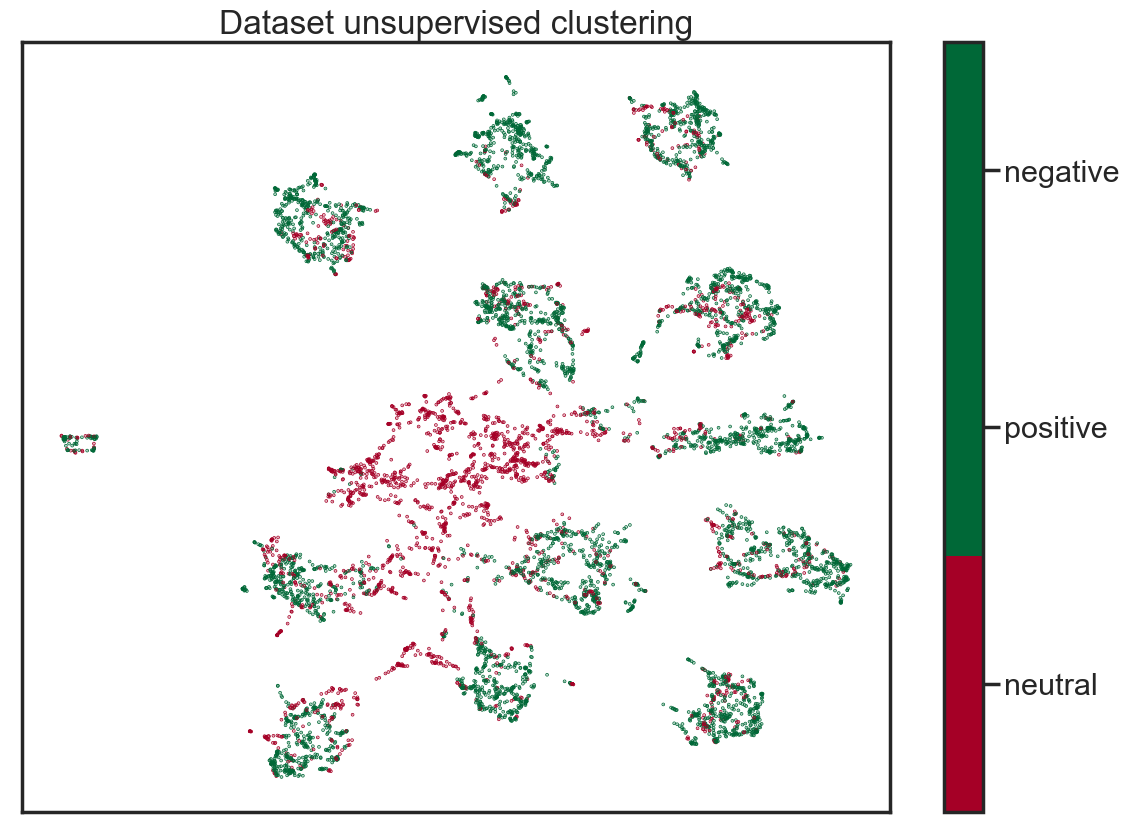

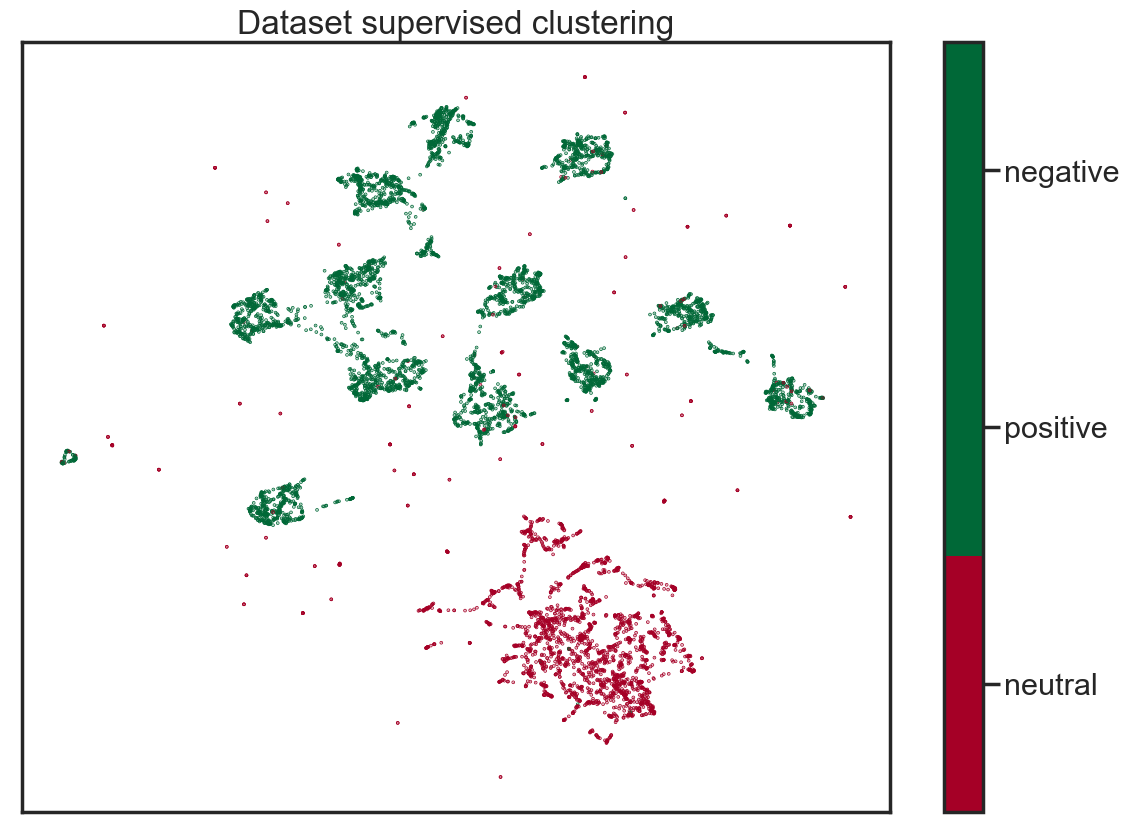

In [289]:
%%skip $skip_feature_analysis
vis.plotUmap(embeddingUnsupervised, y, list(class_labels.values()), 'Dataset unsupervised clustering', cmapString='RdYlGn')
vis.plotUmap(embeddingSupervised, y, list(class_labels.values()), 'Dataset supervised clustering')

### PCA Analysis

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


95% variance covered with the 30 first components. Values=[0.316 0.532 0.603 0.645 0.671 0.692 0.711 0.73  0.742 0.754 0.765 0.776
 0.787 0.798 0.809 0.819 0.828 0.838 0.847 0.857 0.866 0.876 0.885 0.894
 0.903 0.912 0.921 0.929 0.938 0.946]


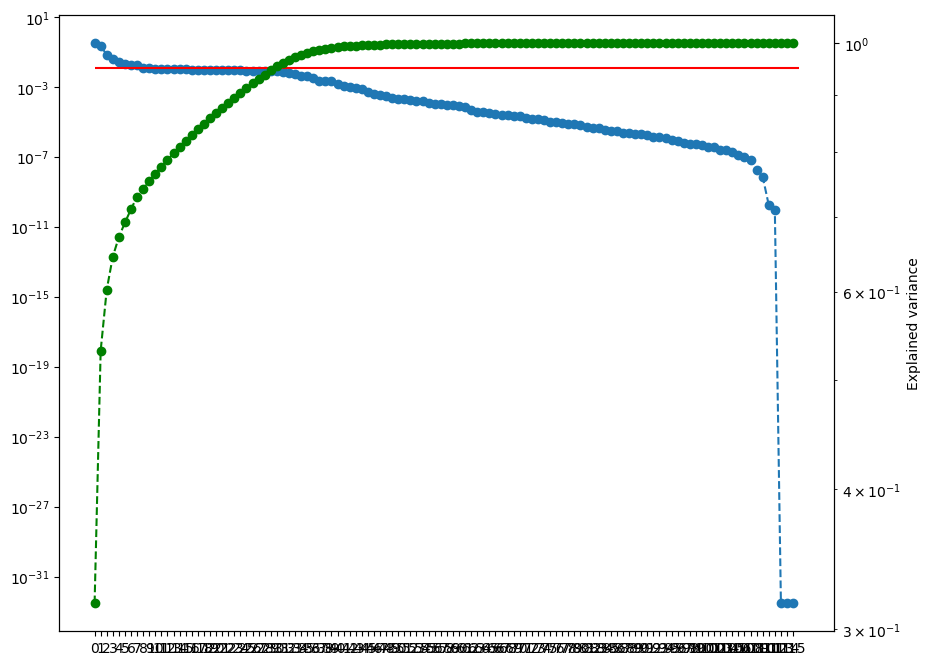

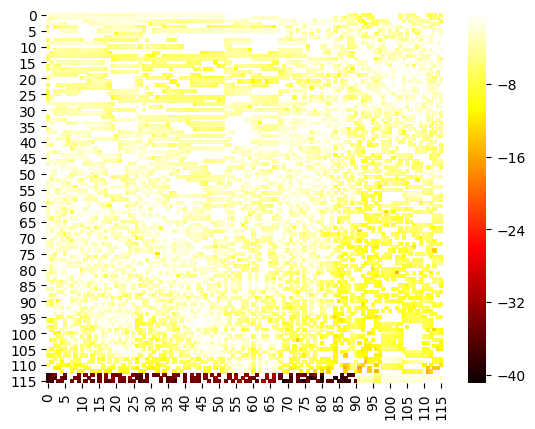

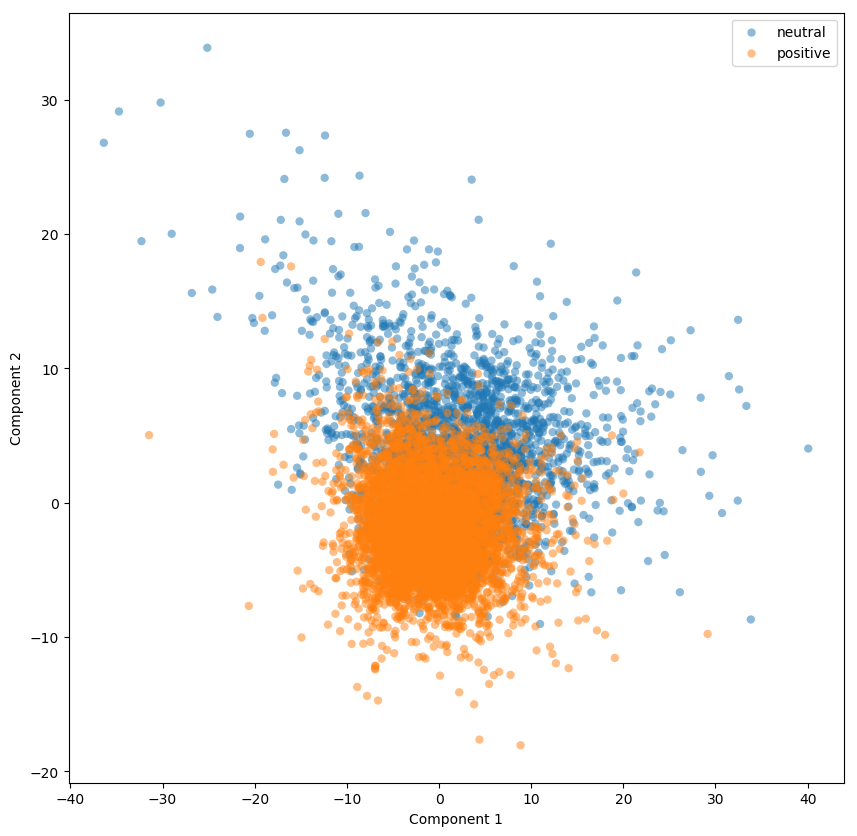

In [290]:
%%skip $skip_feature_analysis
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

m.rc_file_defaults() #Reset sns

pca_trafo = PCA().fit(X_scaled);
pca_values = pca_trafo.transform(X_scaled)
#from adjustText import adjust_text
targets = np.array(y).flatten()

fig, ax1 = plt.subplots(figsize=(10, 8))
plt.semilogy(pca_trafo.explained_variance_ratio_, '--o');
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o', color='green');
plt.xlabel("Principal Component")
plt.ylabel("Explained variance")
plt.xticks(np.arange(0, len(pca_trafo.explained_variance_ratio_)))
plt.hlines(0.95, 0, len(pca_trafo.explained_variance_ratio_.cumsum()), colors='red', linestyles='solid', label='95% variance covered')

fig = plt.figure()
sns.heatmap(np.log(pca_trafo.inverse_transform(np.eye(X_scaled.shape[1]))), cmap="hot", cbar=True)

necessary_components = pca_trafo.explained_variance_ratio_.cumsum()[pca_trafo.explained_variance_ratio_.cumsum()<0.95]
print("95% variance covered with the {} first components. Values={}". format(len(necessary_components), necessary_components))

plt.figure(figsize=(10,10))
#plt.scatter(pca_values[:,0], pca_values[:,1], c=targets, edgecolor='none', label=class_labels.values(), alpha=0.5)
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(pca_values[idx, 0], pca_values[idx, 1], label=class_labels[t], edgecolor='none', alpha=0.5)  

plt.legend(labels=class_labels.values(), bbox_to_anchor=(1, 1));
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Feature Selection

In [291]:
#Data has already been scaled

In [292]:
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, X_scaled)

relevantFeatureList = []
selected_feature_list = pd.DataFrame()

Cutting the data to  1000
Created a training subset


In [293]:
#Predict with logistic regression
from sklearn.linear_model import LogisticRegression

def predict_features_simple(X, y):
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)
    return clf.score(X, y)

### Lasso Feature Selection

Best alpha using built-in LassoCV: 0.014984
Best score using built-in LassoCV: 0.546409
Lasso picked 3 variables and eliminated the other 113 variables
['MA250Norm', 'MA225Norm', 'Stoch_Sd211414']


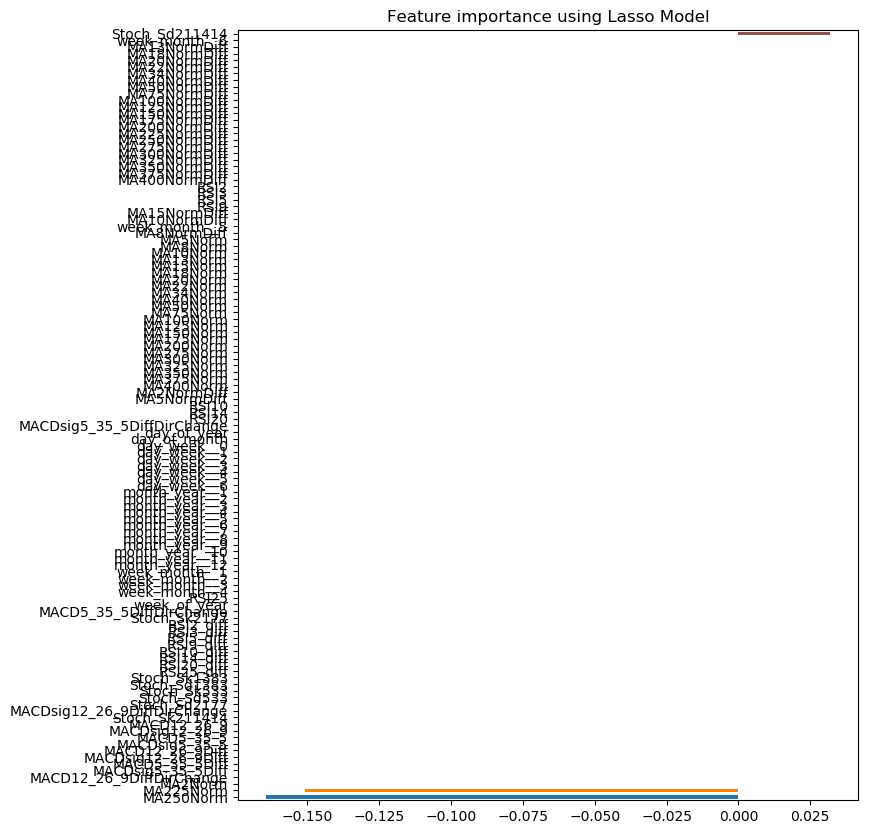

Prediction of training data with logistic regression: 0.91


In [294]:
%%skip $skip_feature_selection
#%matplotlib inline
from sklearn.linear_model import LassoCV

m.rc_file_defaults() #Reset sns

def execute_lasso_feature_selection(X_scaled, y):
    reg = LassoCV(cv=10, max_iter = 100000)
    reg.fit(X_scaled, y)
    coef = pd.Series(reg.coef_, index = X_scaled.columns)
    print("Best alpha using built-in LassoCV: %f" %reg.alpha_)
    print("Best score using built-in LassoCV: %f" %reg.score(X_scaled,y))
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    imp_coef = coef.sort_values()
    coefList = list(imp_coef[imp_coef!=0].index)
    print(coefList)

    #plt.figure()
    m.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")
    plt.show()
    
    return coefList
    
#if do_feature_analysis==True:
coefList = execute_lasso_feature_selection(X_scaled, y)
selected_feature_list = selected_feature_list.append(pd.Series(name='Lasso', data=coefList))
relevantFeatureList.extend(coefList)

print("Prediction of training data with logistic regression: {0:.2f}".format(predict_features_simple(X_scaled[coefList], y)))

### Tree based feature selection

[0.001 0.002 0.003 0.003 0.005 0.005 0.004 0.004 0.005 0.005 0.01  0.014
 0.022 0.033 0.022 0.06  0.05  0.066 0.055 0.074 0.055 0.044 0.06  0.041
 0.041 0.038 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.002
 0.001 0.001 0.001 0.001 0.002 0.001 0.002 0.001 0.001 0.002 0.001 0.001
 0.001 0.001 0.002 0.001 0.002 0.003 0.004 0.005 0.008 0.009 0.01  0.022
 0.001 0.001 0.001 0.001 0.001 0.001 0.002 0.001 0.004 0.004 0.003 0.003
 0.007 0.01  0.006 0.013 0.007 0.005 0.007 0.005 0.003 0.004 0.003 0.004
 0.002 0.002 0.002 0.002 0.007 0.007 0.003 0.001 0.001 0.001 0.001 0.001
 0.    0.    0.002 0.002 0.002 0.003 0.005 0.004 0.005 0.006 0.005 0.003
 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.   ]
Best score: 1.000000
Tree search picked 19 variables and eliminated the other 97 variables
['MA40Norm', 'Stoch_Sd2177', 'Stoch_Sd211414', 'MA50Norm', 'MA75Norm', 'RSI25', 'MA125Norm', 'MA100Norm', 'MA400Norm', 'MA375Norm', 'MA350Norm', 'MA300Norm', 'MA175Norm', 'MA225Norm', 'MA275Norm', 'MA32

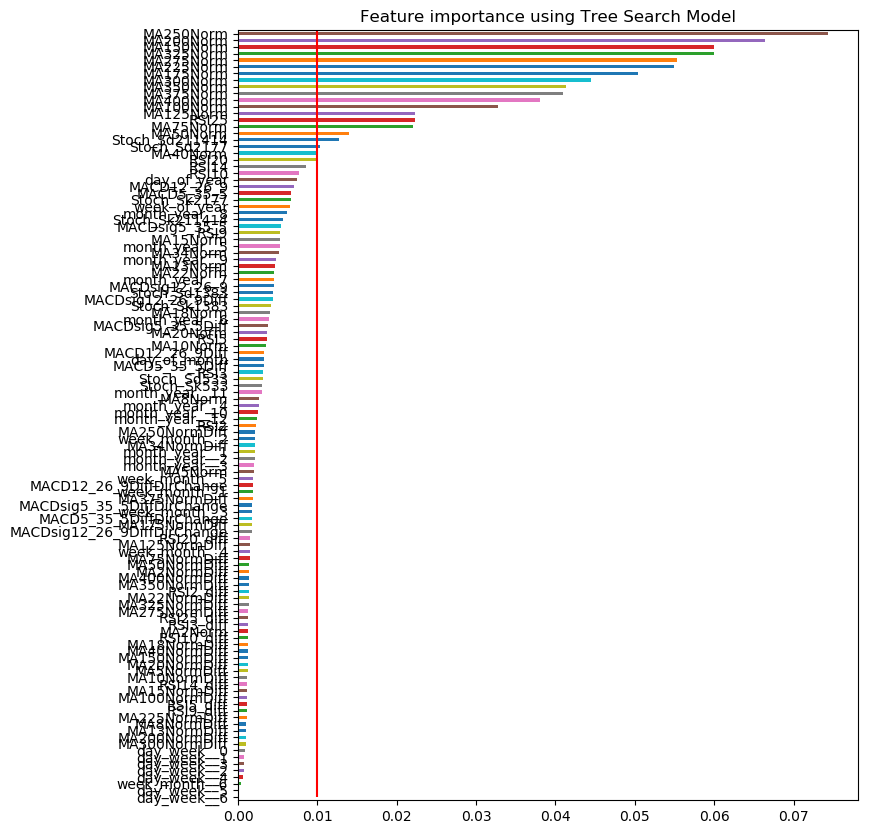

Prediction of training data with logistic regression: 0.91


C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [295]:
%%skip $skip_feature_selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def execute_treebased_feature_selection(X_scaled, y):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_scaled, y)
    print(clf.feature_importances_)
    print("Best score: %f" %clf.score(X_scaled, y))
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X_scaled)
    X_new.shape

    threshold = 0.010
    tree_coef = pd.Series(clf.feature_importances_, index = X_scaled.columns)

    print("Tree search picked " + str(sum(tree_coef >= threshold)) + " variables and eliminated the other " +  str(sum(tree_coef < threshold)) + " variables")
    imp_treecoef = tree_coef.sort_values()
    treecoefList = list(imp_treecoef[imp_treecoef>threshold].index)
    print(treecoefList)

    plt.figure()
    m.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_treecoef.plot(kind = "barh")
    plt.title("Feature importance using Tree Search Model")
    plt.vlines(threshold, 0, len(X_scaled.columns), color='red')
    plt.show()
    
    return treecoefList

#if do_feature_analysis==True:
treecoefList = execute_treebased_feature_selection(X_scaled, y)
selected_feature_list = selected_feature_list.append(pd.Series(name='Tree', data=treecoefList))
relevantFeatureList.extend(treecoefList)

print("Prediction of training data with logistic regression: {0:.2f}".format(predict_features_simple(X_scaled[treecoefList], y)))

### Backward Elimination

In [296]:
%%skip $skip_feature_selection
#Backward Elimination - Wrapper method
import statsmodels.api as sm

def execute_backwardelimination_feature_selection(X_scaled, y):
    cols = list(X_scaled.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X_scaled[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols

    print(selected_features_BE)
    print("\nNumber of features={}. Original number of features={}\n".format(len(selected_features_BE), len(X_scaled.columns)))
    [print("column {} removed".format(x)) for x in X_scaled.columns if x not in selected_features_BE]
    print("Finished")
    
    return selected_features_BE

#if do_feature_analysis==True:
selected_features_BE = execute_backwardelimination_feature_selection(X_scaled, y)
relevantFeatureList.extend(selected_features_BE)
selected_feature_list = selected_feature_list.append(pd.Series(name='Backward_Elimination', data=selected_features_BE))

print("Prediction of training data with logistic regression: {0:.2f}".format(predict_features_simple(X_scaled[selected_features_BE], y)))

['MA8Norm', 'MA18Norm', 'MA40Norm', 'MA75Norm', 'MA100Norm', 'MA125Norm', 'MA150Norm', 'MA200Norm', 'MA325Norm', 'MA350Norm', 'MA8NormDiff', 'MA125NormDiff', 'MA175NormDiff', 'MA225NormDiff', 'MA300NormDiff', 'MA325NormDiff', 'MA375NormDiff', 'MA400NormDiff', 'RSI5', 'RSI9', 'RSI10', 'RSI14', 'RSI20', 'RSI25', 'RSI5_diff', 'RSI14_diff', 'RSI20_diff', 'Stoch_Sd1383', 'Stoch_Sk2177', 'Stoch_Sd211414', 'day_of_year', 'day_of_month', 'month_year__1', 'month_year__2', 'month_year__3', 'month_year__4', 'month_year__5', 'month_year__6', 'month_year__7', 'month_year__8', 'month_year__9', 'month_year__10', 'month_year__11', 'month_year__12']

Number of features=44. Original number of features=116

column MA2Norm removed
column MA5Norm removed
column MA10Norm removed
column MA13Norm removed
column MA15Norm removed
column MA20Norm removed
column MA22Norm removed
column MA34Norm removed
column MA50Norm removed
column MA175Norm removed
column MA225Norm removed
column MA250Norm removed
column MA275N

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Recursive Elimination with Logistic Regression

In [297]:
%%skip $skip_feature_selection
#Recursive Elimination - Wrapper method, Feature ranking with recursive feature elimination
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE

def execute_recursive_elimination_feature_selection(X_scaled, y):
    model = LogisticRegressionCV(solver='liblinear', cv=3)
    print("Start Recursive Elimination. Fit model with {} examples.".format(X_scaled.shape[0]))
    #Initializing RFE model, 3 features selected
    rfe = RFE(model, 1) #It has to be one to get a unique index
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(X_scaled,y)
    #Fitting the data to model
    model.fit(X_rfe,y)

    print("Best accuracy score using built-in Logistic Regression: ", model.score(X_rfe, y))
    print("Ranking")
    rfe_coef = pd.Series(X_scaled.columns, index = rfe.ranking_-1).sort_index()
    print(rfe_coef)
    print("Select columns")

    
    print(X_scaled.columns[rfe.support_].values)
    
    return X_scaled.columns[rfe.support_].values, rfe_coef

#if do_feature_analysis==True:
relevant_features, rfe_coef = execute_recursive_elimination_feature_selection(X_scaled.iloc[X_train_index_subset], y[X_train_index_subset])
relevantFeatureList.extend(relevant_features)

step_size = np.round(len(X_scaled.columns)/4,0).astype("int")
for i in range(step_size, len(X_scaled.columns), step_size):
    selected_feature_list = selected_feature_list.append(pd.Series(name='RecursiveTop' + str(i), data=rfe_coef.loc[0:i-1]))
    print('Created RecursiveTop{}'.format(str(i)))

Start Recursive Elimination. Fit model with 1000 examples.
Best accuracy score using built-in Logistic Regression:  0.92
Ranking
0                     MA250Norm
1                     MA150Norm
2                         RSI25
3                      MA50Norm
4                     MA225Norm
5                     MA275Norm
6                     MA125Norm
7                     MA175Norm
8                Stoch_Sk211414
9                     MA200Norm
10                    MA300Norm
11                    MA325Norm
12                        RSI20
13                    MA400Norm
14                     MA20Norm
15                    MA100Norm
16                month_year__5
17                   RSI25_diff
18                    RSI3_diff
19                     MA22Norm
20               month_year__10
21                    MA350Norm
22                month_year__1
23            MACDsig5_35_5Diff
24                    MA375Norm
25                   RSI20_diff
26                        RSI14
27     

In [298]:
#rfe_coef.loc[0:10].values

### Weighted values

In [299]:
#Weights
values, counts = np.unique(relevantFeatureList, return_counts=True)
s = pd.Series(index=values, data=counts).sort_values(ascending=False)
print(s)

Stoch_Sd211414    3
MA250Norm         3
MA100Norm         2
MA225Norm         2
MA40Norm          2
RSI25             2
MA350Norm         2
MA325Norm         2
MA75Norm          2
MA200Norm         2
MA125Norm         2
MA150Norm         2
MA275Norm         1
MA8Norm           1
MA300NormDiff     1
MA175NormDiff     1
MA175Norm         1
MA325NormDiff     1
MA225NormDiff     1
MA375Norm         1
MA375NormDiff     1
MA125NormDiff     1
MA400Norm         1
MA400NormDiff     1
MA18Norm          1
MA50Norm          1
MA300Norm         1
month_year__9     1
MA8NormDiff       1
day_of_year       1
month_year__7     1
month_year__6     1
month_year__5     1
month_year__4     1
month_year__3     1
month_year__2     1
month_year__12    1
month_year__11    1
month_year__10    1
month_year__1     1
day_of_month      1
month_year__8     1
Stoch_Sk2177      1
Stoch_Sd2177      1
Stoch_Sd1383      1
RSI9              1
RSI5_diff         1
RSI5              1
RSI20_diff        1
RSI20             1


### Add Manually Selected Subset

In [300]:
#print subset
newval = [x for x, c in zip(values, counts) if c>1]
subsetColumns = newval#X.columns[rfe.support_].values #list(values)
display(subsetColumns)
selected_feature_list = selected_feature_list.append(pd.Series(name='Manual', data=subsetColumns))

['MA100Norm',
 'MA125Norm',
 'MA150Norm',
 'MA200Norm',
 'MA225Norm',
 'MA250Norm',
 'MA325Norm',
 'MA350Norm',
 'MA40Norm',
 'MA75Norm',
 'RSI25',
 'Stoch_Sd211414']

### Add all columns

In [301]:
selected_feature_list = selected_feature_list.append(pd.Series(name='All', data=X_scaled.columns))

In [302]:
#subsetColumns = X.columns[rfe.support_].values
#X_subset = X_raw[subsetColumns]
#display(X_subset.head(5))
selected_feature_list.transpose()

Lasso            Tree Backward_Elimination     RecursiveTop29  \
0         MA250Norm        MA40Norm              MA8Norm          MA250Norm   
1         MA225Norm    Stoch_Sd2177             MA18Norm          MA150Norm   
2    Stoch_Sd211414  Stoch_Sd211414             MA40Norm              RSI25   
3               NaN        MA50Norm             MA75Norm           MA50Norm   
4               NaN        MA75Norm            MA100Norm          MA225Norm   
5               NaN           RSI25            MA125Norm          MA275Norm   
6               NaN       MA125Norm            MA150Norm          MA125Norm   
7               NaN       MA100Norm            MA200Norm          MA175Norm   
8               NaN       MA400Norm            MA325Norm     Stoch_Sk211414   
9               NaN       MA375Norm            MA350Norm          MA200Norm   
10              NaN       MA350Norm          MA8NormDiff          MA300Norm   
11              NaN       MA300Norm        MA125NormDiff          MA325Norm   
12              NaN       MA175Norm        MA175NormDiff              RSI20   
13              NaN       MA225Norm        MA225NormDiff          MA400Norm   
14              NaN       MA275Norm        MA300NormDiff           MA20Norm   
15              NaN       MA325Norm        MA325NormDiff          MA100Norm   
16              NaN       MA150Norm        MA375NormDiff      month_year__5   
17              NaN       MA200Norm        MA400NormDiff         RSI25_diff   
18              NaN       MA250Norm                 RSI5          RSI3_diff   
19              NaN             NaN                 RSI9           MA22Norm   
20              NaN             NaN                RSI10     month_year__10   
21              NaN             NaN                RSI14          MA350Norm   
22              NaN             NaN                RSI20      month_year__1   
23              NaN             NaN                RSI25  MACDsig5_35_5Diff   
24              NaN             NaN            RSI5_diff          MA375Norm   
25              NaN             NaN           RSI14_diff         RSI20_diff   
26              NaN             NaN           RSI20_diff              RSI14   
27              NaN             NaN         Stoch_Sd1383      week_month__5   
28              NaN             NaN         Stoch_Sk2177       day_of_month   
29              NaN             NaN       Stoch_Sd211414                NaN   
..              ...             ...                  ...                ...   
86              NaN             NaN                  NaN                NaN   
87              NaN             NaN                  NaN                NaN   
88              NaN             NaN                  NaN                NaN   
89              NaN             NaN                  NaN                NaN   
90              NaN             NaN                  NaN                NaN   
91              NaN             NaN                  NaN                NaN   
92              NaN             NaN                  NaN                NaN   
93              NaN             NaN                  NaN                NaN   
94              NaN             NaN                  NaN                NaN   
95              NaN             NaN                  NaN                NaN   
96              NaN             NaN                  NaN                NaN   
97              NaN             NaN                  NaN                NaN   
98              NaN             NaN                  NaN                NaN   
99              NaN             NaN                  NaN                NaN   
100             NaN             NaN                  NaN                NaN   
101             NaN             NaN                  NaN                NaN   
102             NaN             NaN                  NaN                NaN   
103             NaN             NaN                  NaN                NaN   
104             NaN             NaN                  NaN        

## Save Subset

In [303]:
import csv

#Save features to a csv file
print("Features shape {}".format(df.shape, features.shape))
features.to_csv(X_filename, sep=';', index=True)
#np.savetxt(filenameprefix + "_X.csv", X, delimiter=";", fmt='%s')
print("Saved features to " + X_filename)

#Save y to a csv file
print("y shape {}".format(y.shape))
outcomes[class_name].to_csv(y_filename, sep=';', index=True, header=True)
print("Saved features to " + y_filename)

#Save y labels to a csv file as a dict
#print("Class labels length {}".format(len(y_labels)))
#with open(ylabel_filename, 'w') as f:
#    for key in y_labels.keys():
#        f.write("%s;%s\n"%(key,y_labels[key]))
#print("Saved class names and id to " + ylabel_filename)

#Save x subset column names to a csv file as a list
selected_feature_list.transpose().to_csv(X_filename_selected_feature_column, sep=';', index=False, header=True)
#print("Selected columns length {}".format(len(subsetColumns)))
#with open(X_filename_selected_feature_column, 'w') as f:
#    for item in subsetColumns:
#        f.write("%s\n"%(item))
print("Saved selected feature columns to " + X_filename_selected_feature_column)

print("=== Data for {} prepared to be trained ===". format(filenameprefix))

Features shape (7687, 120)
Saved features to 02_Training_Data/omxs30_LongTrend_X.csv
y shape (7687,)
Saved features to 02_Training_Data/omxs30_LongTrend_y.csv
Saved selected feature columns to 02_Training_Data/omxs30_LongTrend_X_selected_feature_columns.csv
=== Data for omxs30_LongTrend prepared to be trained ===


## Debug and Experiment

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

from tqdm import tqdm
import time
%matplotlib inline

pbar = tqdm(total=100)
for i in range(10):
    time.sleep(0.1)
    pbar.update(10)
pbar.close()

from statsmodels import robust

a = np.matrix( [
    [ 80, 76, 77, 78, 79, 81, 76, 77, 79, 84, 75, 79, 76, 78 ],
    [ 66, 69, 76, 72, 79, 77, 74, 77, 71, 79, 74, 66, 67, 73 ]
    ], dtype=float )
robust.mad(a, axis=1)

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_timegraph['Close'])
plt.show()